# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.


# Exploracion de datos

Exportamos librerias utiles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sweetviz
from sklearn.metrics import r2_score
from datetime import datetime, timedelta

In [2]:
datos=pd.read_csv('src/owid-covid-data.csv', infer_datetime_format=True)
datos.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

In [3]:
datos[datos['location'] == 'World'].head()

iso_code continent location        date  total_cases  new_cases  \
182040  OWID_WRL       NaN    World  2020-01-22        557.0        0.0   
182041  OWID_WRL       NaN    World  2020-01-23        657.0      100.0   
182042  OWID_WRL       NaN    World  2020-01-24        944.0      287.0   
182043  OWID_WRL       NaN    World  2020-01-25       1437.0      493.0   
182044  OWID_WRL       NaN    World  2020-01-26       2120.0      683.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
182040                 NaN          17.0         0.0                  NaN   
182041                 NaN          18.0         1.0                  NaN   
182042                 NaN          26.0         8.0                  NaN   
182043                 NaN          42.0        16.0                  NaN   
182044                 NaN          56.0        14.0                  NaN   

        ...  female_smokers  male_smokers  handwashing_facilities  \
182040  ...           6.434        34.635                   60.13   
182041  ...           6.434        34.635                   60.13   
182042  ...           6.434        34.635                   60.13   
182043  ...           6.434        34.635                   60.13   
182044  ...           6.434        34.635                   60.13   

        hospital_beds_per_thousand  life_expectancy  human_development_index  \
182040                       2.705            72.58                    0.737   
182041                       2.705            72.58                    0.737   
182042                       2.705            72.58                    0.737   
182043                       2.705            72.58                    0.737   
182044                       2.705            72.58                    0.737   

        excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
182040                                   NaN                          NaN   
182041                                   NaN                          NaN   
182042                                   NaN                          NaN   
182043                                   NaN                          NaN   
182044                                   NaN                          NaN   

        excess_mortality  excess_mortality_cumulative_per_million  
182040               NaN                                      NaN  
182041               NaN                                      NaN  
182042               NaN                                      NaN  
182043               NaN                                      NaN  
182044               NaN                                      NaN  

[5 rows x 67 columns]

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185207 entries, 0 to 185206
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    185207 non-null  object 
 1   continent                                   174393 non-null  object 
 2   location                                    185207 non-null  object 
 3   date                                        185207 non-null  object 
 4   total_cases                                 178341 non-null  float64
 5   new_cases                                   178115 non-null  float64
 6   new_cases_smoothed                          176946 non-null  float64
 7   total_deaths                                160021 non-null  float64
 8   new_deaths                                  160014 non-null  float64
 9   new_deaths_smoothed                         158857 non-null  float64
 

## Que significa cada una de nuestras columnas?

# Information about each attribute



## The complete _Our World in Data_ COVID-19 dataset


The variables represent all of our main data related to confirmed cases, deaths, hospitalizations, and testing, as well as other variables of potential interest.

### Confirmed cases
| Variable                         | Description                                                                                                                                                                                            |
|:---------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_cases`                    | Total confirmed cases of COVID-19. Counts can include probable cases, where reported.                                                                                                                  |
| `new_cases`                      | New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA. |
| `new_cases_smoothed`             | New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported.                                                                                                   |
| `total_cases_per_million`        | Total confirmed cases of COVID-19 per 1,000,000 people. Counts can include probable cases, where reported.                                                                                             |
| `new_cases_per_million`          | New confirmed cases of COVID-19 per 1,000,000 people. Counts can include probable cases, where reported.                                                                                               |
| `new_cases_smoothed_per_million` | New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people. Counts can include probable cases, where reported.                                                                              |

### Confirmed deaths
| Variable                          | Description                                                                                                                                                                                               |
|:----------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_deaths`                    | Total deaths attributed to COVID-19. Counts can include probable deaths, where reported.                                                                                                                  |
| `new_deaths`                      | New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA. |
| `new_deaths_smoothed`             | New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported.                                                                                                   |
| `total_deaths_per_million`        | Total deaths attributed to COVID-19 per 1,000,000 people. Counts can include probable deaths, where reported.                                                                                             |
| `new_deaths_per_million`          | New deaths attributed to COVID-19 per 1,000,000 people. Counts can include probable deaths, where reported.                                                                                               |
| `new_deaths_smoothed_per_million` | New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people. Counts can include probable deaths, where reported.                                                                              |

#### Notes:
* Due to varying protocols and challenges in the attribution of the cause of death, the number of confirmed deaths may not accurately represent the true number of deaths caused by COVID-19.

### Excess mortality
| Variable                                  | Description                                                                                                                                                                                                                                                                                   |
|:------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `excess_mortality`                        | Percentage difference between the reported number of weekly or monthly deaths in 2020–2021 and the projected number of deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality           |
| `excess_mortality_cumulative`             | Percentage difference between the cumulative number of deaths since 1 January 2020 and the cumulative projected deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality                  |
| `excess_mortality_cumulative_absolute`    | Cumulative difference between the reported number of deaths since 1 January 2020 and the projected number of deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality                     |
| `excess_mortality_cumulative_per_million` | Cumulative difference between the reported number of deaths since 1 January 2020 and the projected number of deaths for the same period based on previous years, per million people. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality |

### Hospital & ICU
| Variable                             | Description                                                                                                    |
|:-------------------------------------|:---------------------------------------------------------------------------------------------------------------|
| `icu_patients`                       | Number of COVID-19 patients in intensive care units (ICUs) on a given day                                      |
| `icu_patients_per_million`           | Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people                 |
| `hosp_patients`                      | Number of COVID-19 patients in hospital on a given day                                                         |
| `hosp_patients_per_million`          | Number of COVID-19 patients in hospital on a given day per 1,000,000 people                                    |
| `weekly_icu_admissions`              | Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week                      |
| `weekly_icu_admissions_per_million`  | Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week per 1,000,000 people |
| `weekly_hosp_admissions`             | Number of COVID-19 patients newly admitted to hospitals in a given week                                        |
| `weekly_hosp_admissions_per_million` | Number of COVID-19 patients newly admitted to hospitals in a given week per 1,000,000 people                   |

### Policy responses
| Variable           | Description                                                                                                                                                                                                         |
|:-------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `stringency_index` | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response) |

### Reproduction rate
| Variable            | Description                                                                                                                                   |
|:--------------------|:----------------------------------------------------------------------------------------------------------------------------------------------|
| `reproduction_rate` | Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database |

### Tests & positivity
| Variable                          | Description                                                                                                                                                                                                                                                                                                          |
|:----------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_tests`                     | Total tests for COVID-19                                                                                                                                                                                                                                                                                             |
| `new_tests`                       | New tests for COVID-19 (only calculated for consecutive days)                                                                                                                                                                                                                                                        |
| `total_tests_per_thousand`        | Total tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                            |
| `new_tests_per_thousand`          | New tests for COVID-19 per 1,000 people                                                                                                                                                                                                                                                                              |
| `new_tests_smoothed`              | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `new_tests_smoothed_per_thousand` | New tests for COVID-19 (7-day smoothed) per 1,000 people                                                                                                                                                                                                                                                             |
| `positive_rate`                   | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)                                                                                                                                                                                              |
| `tests_per_case`                  | Tests conducted per new confirmed case of COVID-19, given as a rolling 7-day average (this is the inverse of positive_rate)                                                                                                                                                                                          |
| `tests_units`                     | Units used by the location to report its testing data                                                                                                                                                                                                                                                                |

### Vaccinations
| Variable                                     | Description                                                                                                                                                                                                                                                                                                                                       |
|:---------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `total_vaccinations`                         | Total number of COVID-19 vaccination doses administered                                                                                                                                                                                                                                                                                           |
| `people_vaccinated`                          | Total number of people who received at least one vaccine dose                                                                                                                                                                                                                                                                                     |
| `people_fully_vaccinated`                    | Total number of people who received all doses prescribed by the initial vaccination protocol                                                                                                                                                                                                                                                      |
| `total_boosters`                             | Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol)                                                                                                                                                                                                     |
| `new_vaccinations`                           | New COVID-19 vaccination doses administered (only calculated for consecutive days)                                                                                                                                                                                                                                                                |
| `new_vaccinations_smoothed`                  | New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `total_vaccinations_per_hundred`             | Total number of COVID-19 vaccination doses administered per 100 people in the total population                                                                                                                                                                                                                                                    |
| `people_vaccinated_per_hundred`              | Total number of people who received at least one vaccine dose per 100 people in the total population                                                                                                                                                                                                                                              |
| `people_fully_vaccinated_per_hundred`        | Total number of people who received all doses prescribed by the initial vaccination protocol per 100 people in the total population                                                                                                                                                                                                               |
| `total_boosters_per_hundred`                 | Total number of COVID-19 vaccination booster doses administered per 100 people in the total population                                                                                                                                                                                                                                            |
| `new_vaccinations_smoothed_per_million`      | New COVID-19 vaccination doses administered (7-day smoothed) per 1,000,000 people in the total population                                                                                                                                                                                                                                         |
| `new_people_vaccinated_smoothed`             | Daily number of people receiving their first vaccine dose (7-day smoothed)                                                                                                                                                                                                                                                                        |
| `new_people_vaccinated_smoothed_per_hundred` | Daily number of people receiving their first vaccine dose (7-day smoothed) per 100 people in the total population                                                                                                                                                                                                                                 |

### Others
| Variable                     | Description                                                                                                                                                                                                                                |
|:-----------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `iso_code`                   | ISO 3166-1 alpha-3 – three-letter country codes                                                                                                                                                                                            |
| `continent`                  | Continent of the geographical location                                                                                                                                                                                                     |
| `location`                   | Geographical location                                                                                                                                                                                                                      |
| `date`                       | Date of observation                                                                                                                                                                                                                        |
| `population`                 | Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources                                                                                |
| `population_density`         | Number of people divided by land area, measured in square kilometers, most recent year available                                                                                                                                           |
| `median_age`                 | Median age of the population, UN projection for 2020                                                                                                                                                                                       |
| `aged_65_older`              | Share of the population that is 65 years and older, most recent year available                                                                                                                                                             |
| `aged_70_older`              | Share of the population that is 70 years and older in 2015                                                                                                                                                                                 |
| `gdp_per_capita`             | Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available                                                                                                                        |
| `extreme_poverty`            | Share of the population living in extreme poverty, most recent year available since 2010                                                                                                                                                   |
| `cardiovasc_death_rate`      | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)                                                                                                                                                |
| `diabetes_prevalence`        | Diabetes prevalence (% of population aged 20 to 79) in 2017                                                                                                                                                                                |
| `female_smokers`             | Share of women who smoke, most recent year available                                                                                                                                                                                       |
| `male_smokers`               | Share of men who smoke, most recent year available                                                                                                                                                                                         |
| `handwashing_facilities`     | Share of the population with basic handwashing facilities on premises, most recent year available                                                                                                                                          |
| `hospital_beds_per_thousand` | Hospital beds per 1,000 people, most recent year available since 2010                                                                                                                                                                      |
| `life_expectancy`            | Life expectancy at birth in 2019                                                                                                                                                                                                           |
| `human_development_index`    | A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506 |




## Data alterations

- In rare cases where our source for confirmed cases & deaths reports a _negative_ daily change due to a data correction, we set the corresponding metric (`new_cases` or `new_deaths`) to `NA`. This also means that rolling metrics (7-day rolling average, weekly rolling sum, biweekly rolling sum) are set to `NA` until this missing value leaves the rolling window.
- The population estimates we use to calculate per-capita metrics are based on the last revision of the [United Nations World Population Prospects](https://population.un.org/wpp/). The exact values can be viewed [here](https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv). In a few cases, we use other sources (see column `source` in the population file) when the figures provided by the UN differ substantially from reliable and more recent national estimates. Population estimates for a few subnational locations are taken from national reports, and are stored [here](https://github.com/owid/covid-19-data/blob/master/scripts/input/owid/subnational_population_2020.csv).
- We standardize names of countries and regions. Since the names of countries and regions are different in different data sources, we standardize all names to the [_Our World in Data_ standard entity names](https://github.com/owid/covid-19-data/blob/master/public/data/jhu/locations.csv).
- We may correct or discard inconsistencies that we detect in the original data.
- Testing data is collected from many different sources. A detailed documentation for each country is available in [our post on COVID-19 testing](https://ourworldindata.org/coronavirus-testing#source-information-country-by-country).


## Authors

This data has been collected, aggregated, and documented by Cameron Appel, Diana Beltekian, Daniel Gavrilov, Charlie Giattino, Joe Hasell, Bobbie Macdonald, Edouard Mathieu, Esteban Ortiz-Ospina, Hannah Ritchie, Lucas Rodés-Guirao, Max Roser.

The mission of _Our World in Data_ is to make data and research on the world's largest problems understandable and accessible. [Read more about our mission](https://ourworldindata.org/about).

## Como estan nuestros datos distribuidos?

In [5]:
my_report = sweetviz.analyze(datos)

                                             |      | [  0%]   00:00 -> (? left)

/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.ap

/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/home/juancparra/.local/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWar


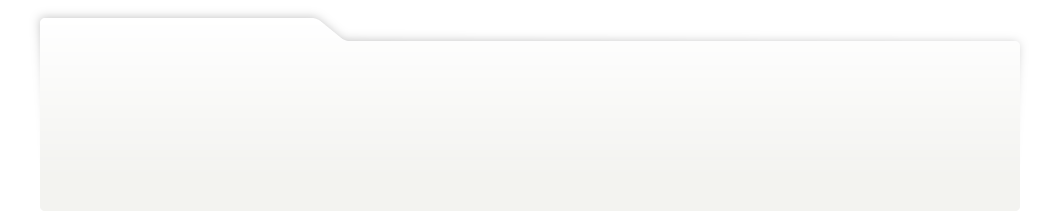
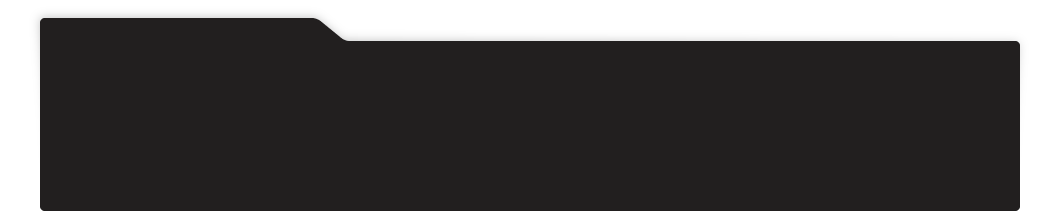
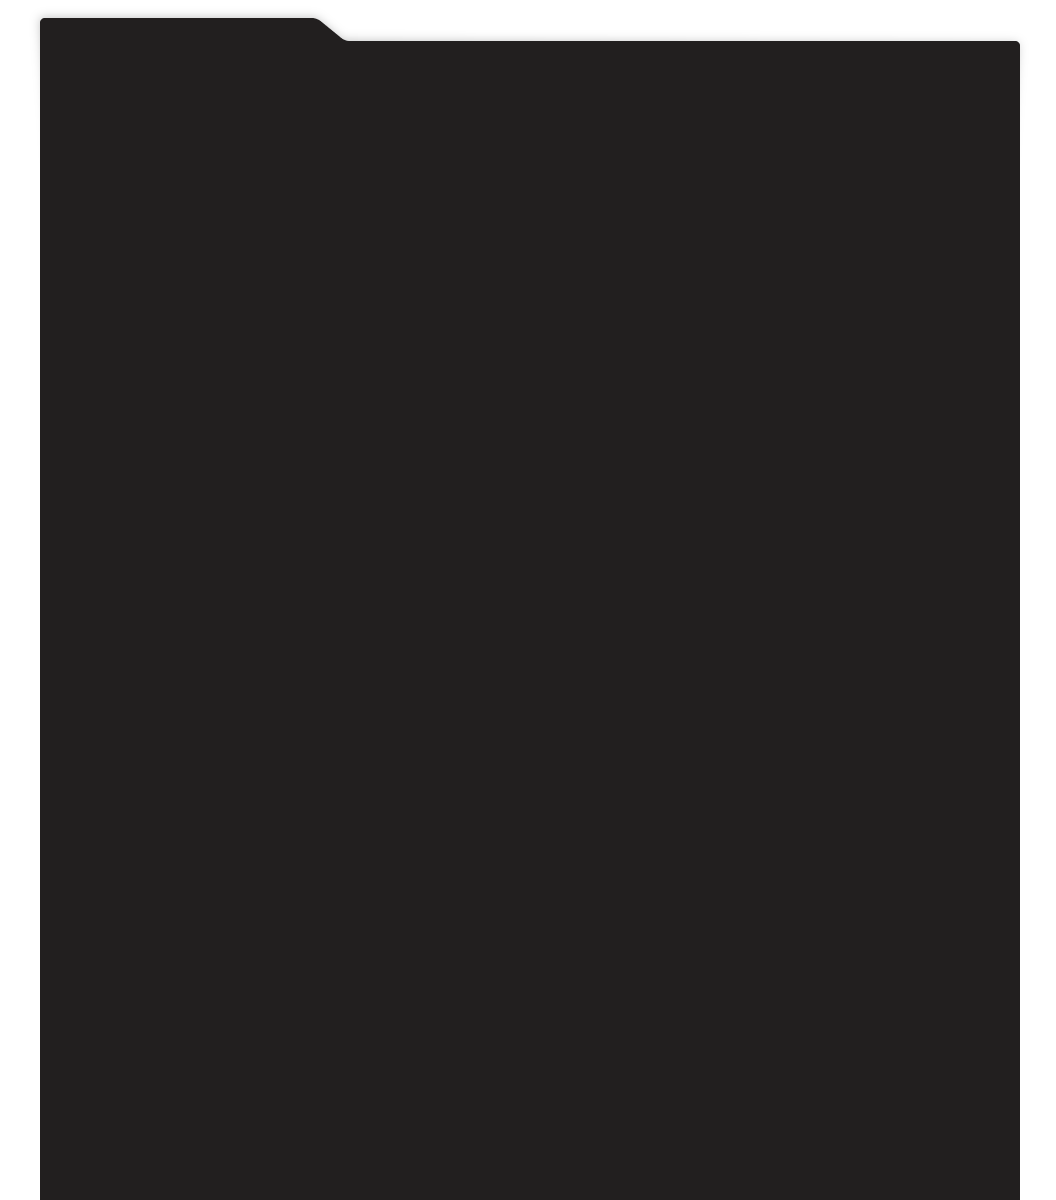
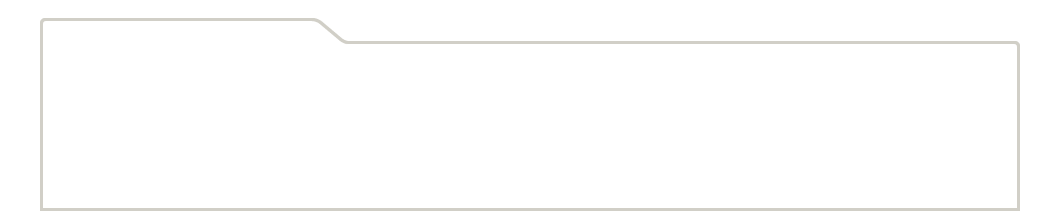
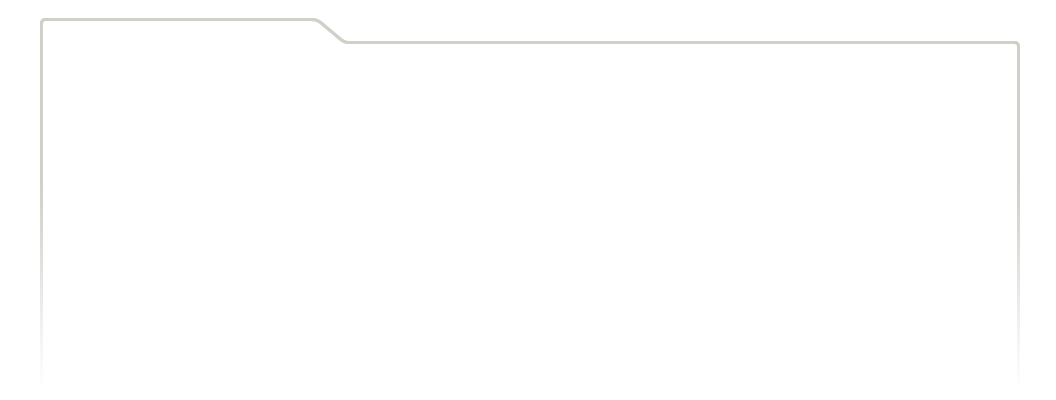
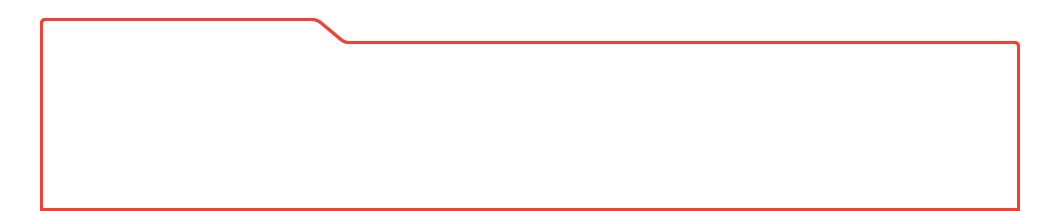
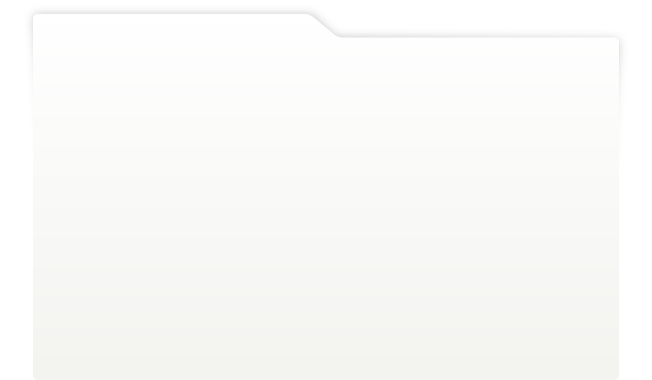
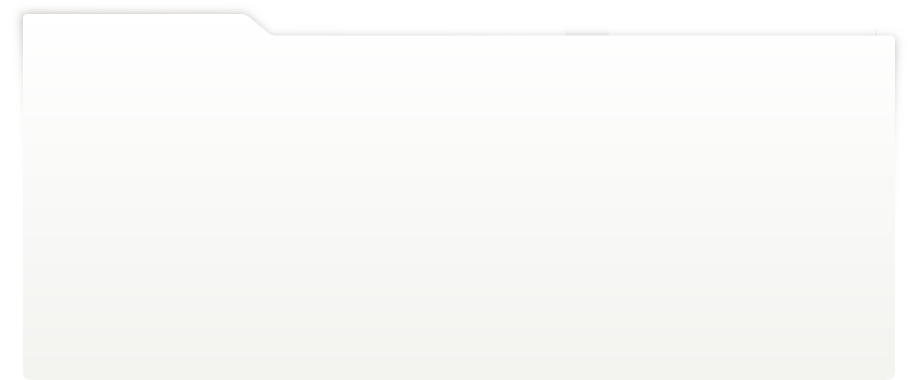
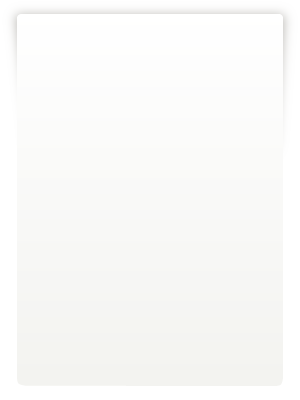
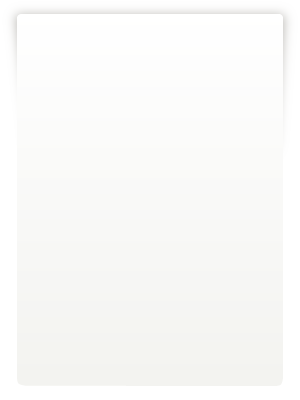
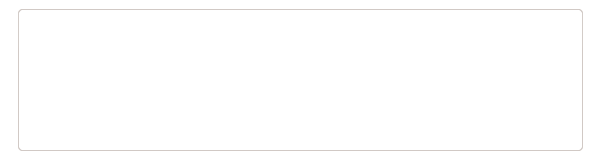
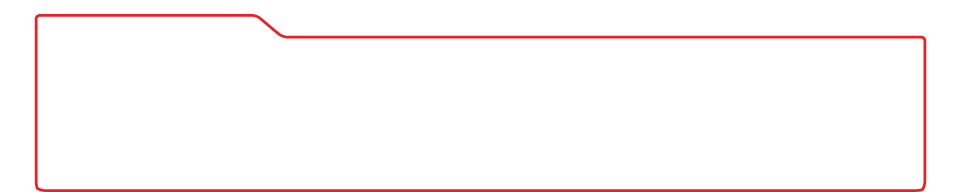
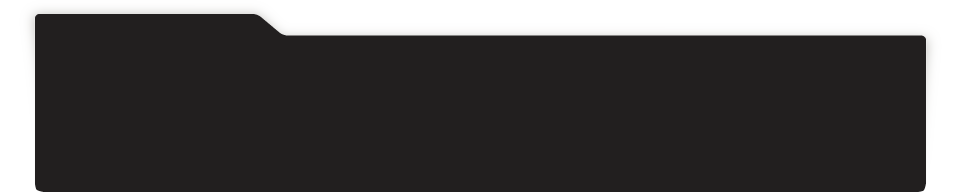
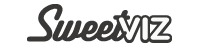
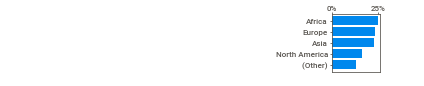
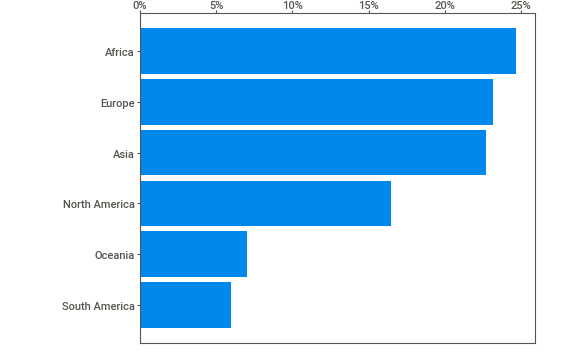
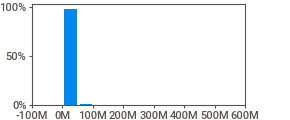
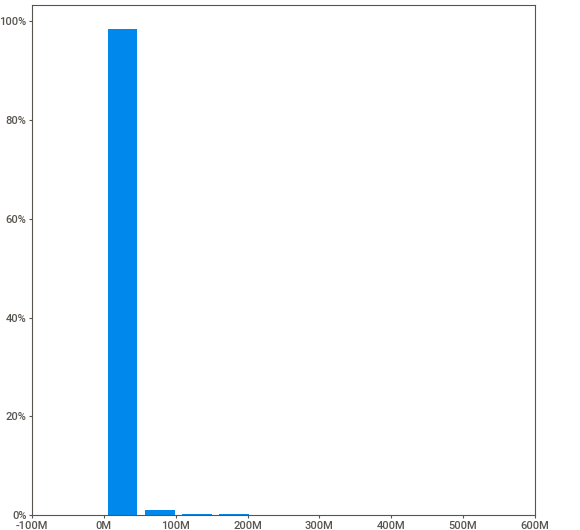
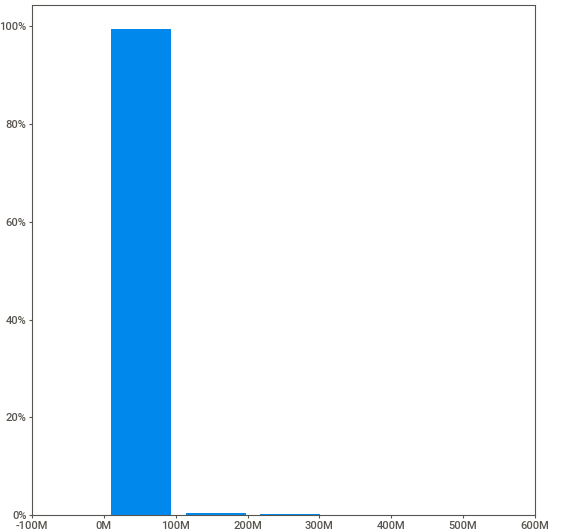
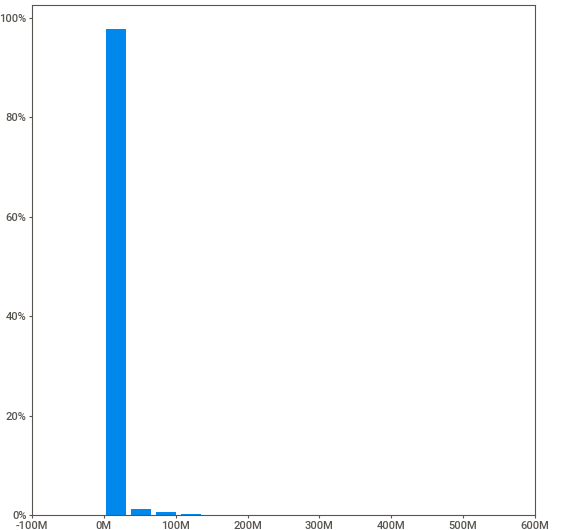
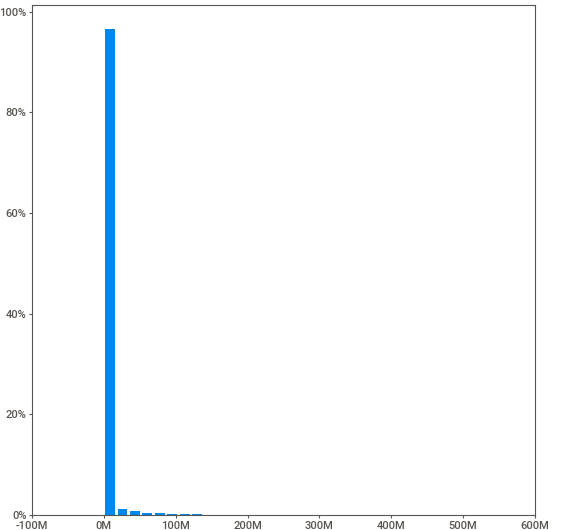
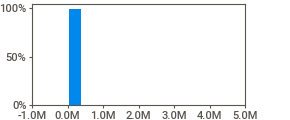
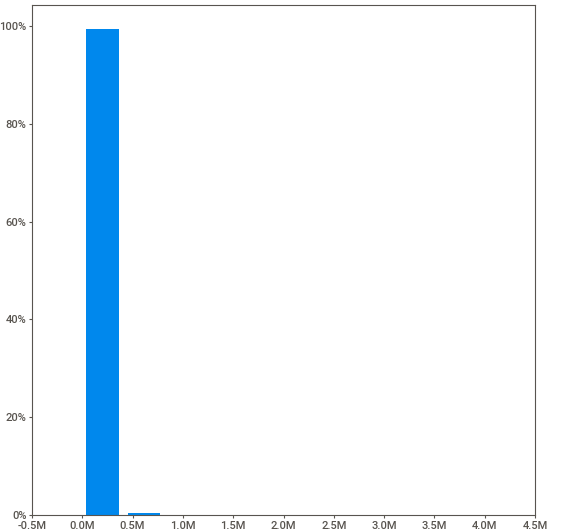
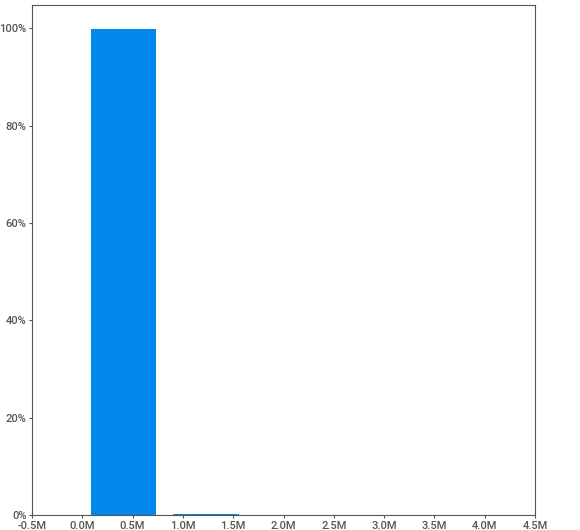
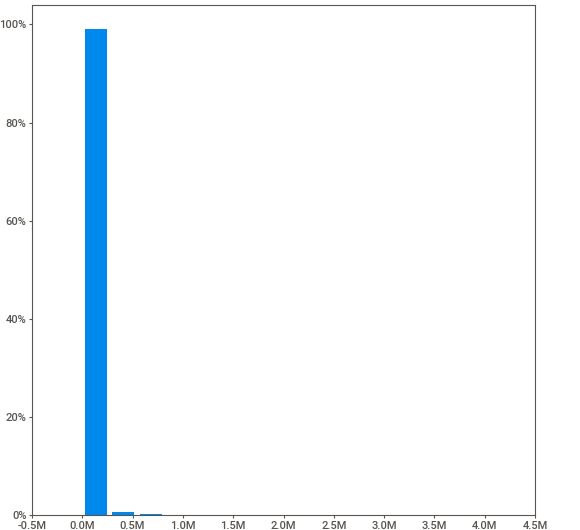
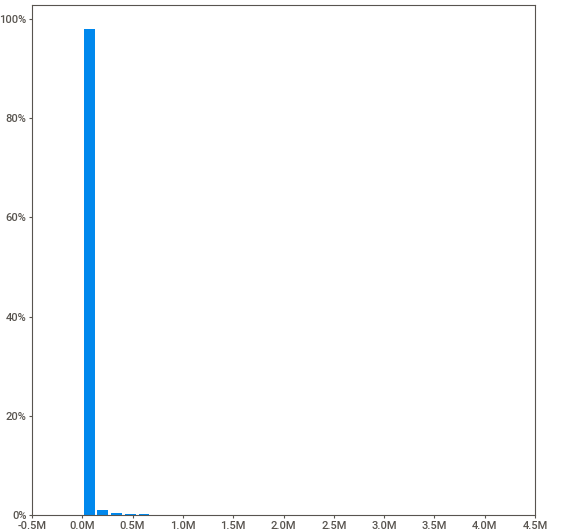
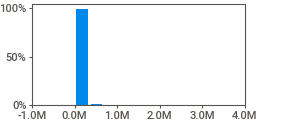
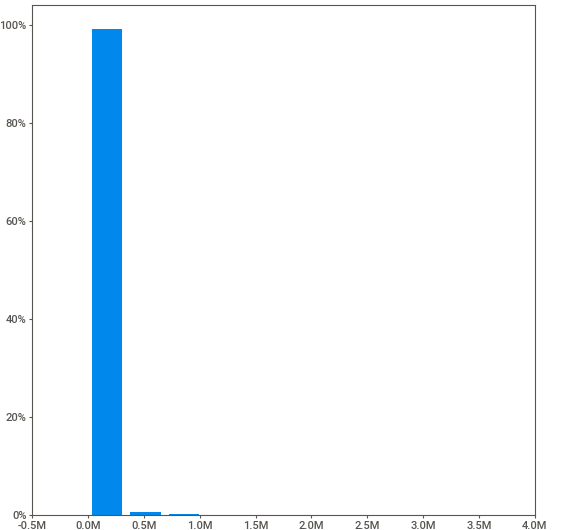
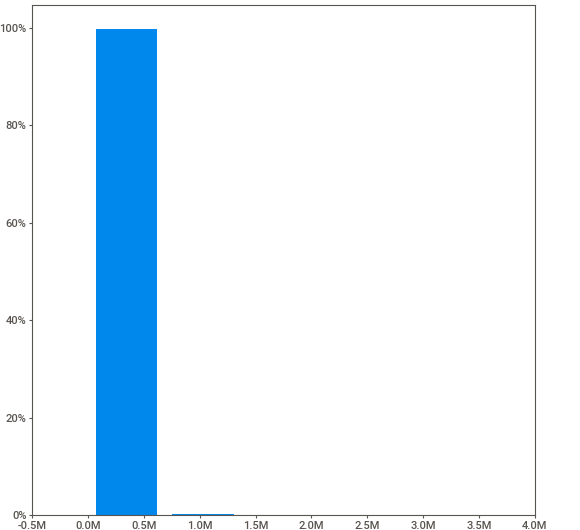
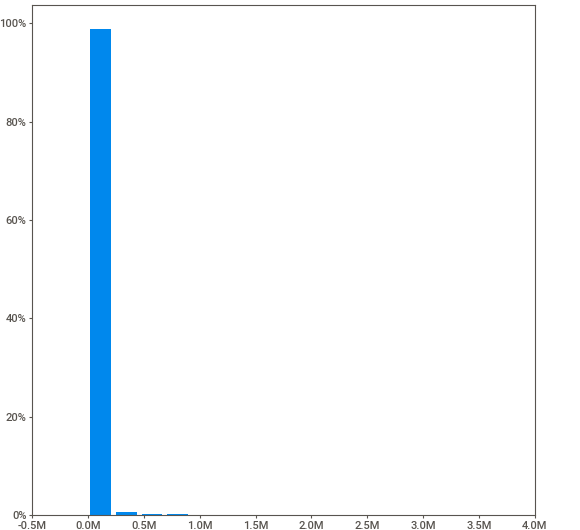
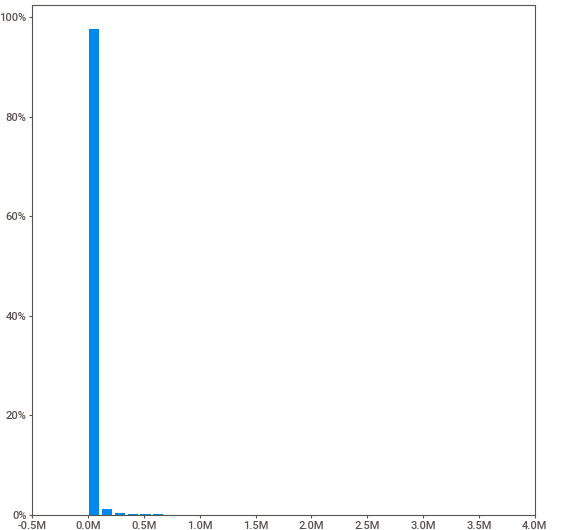
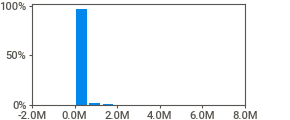
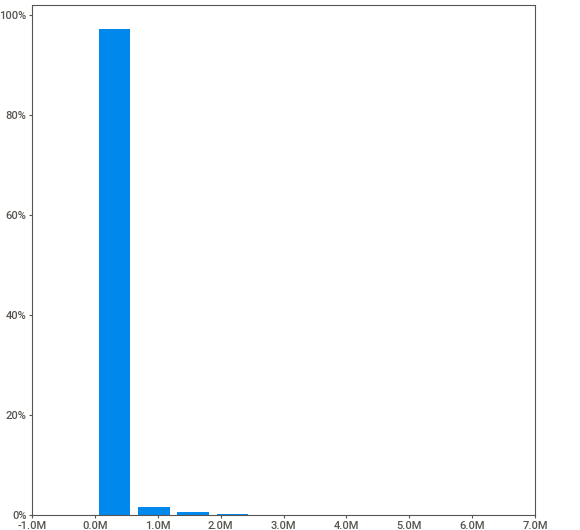
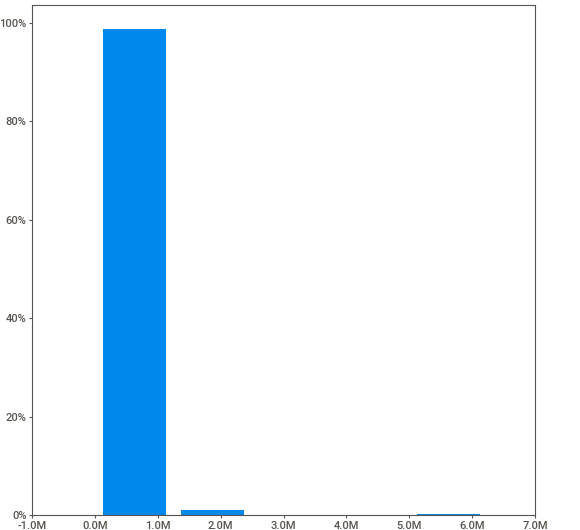
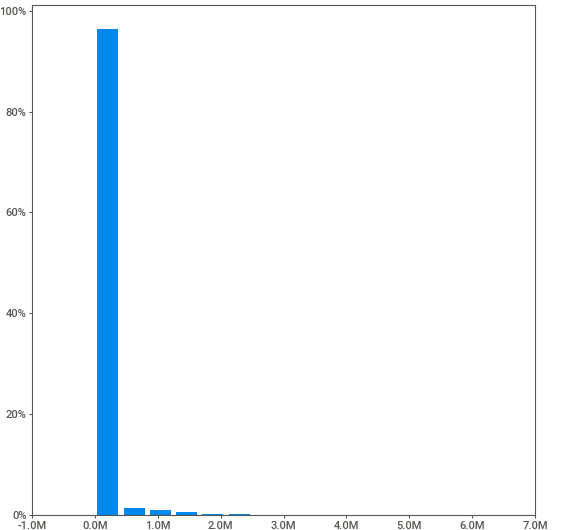
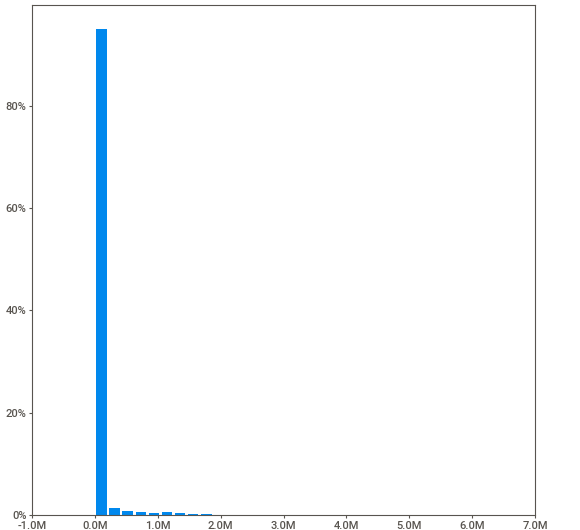
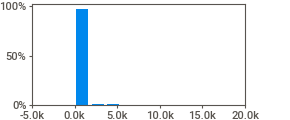
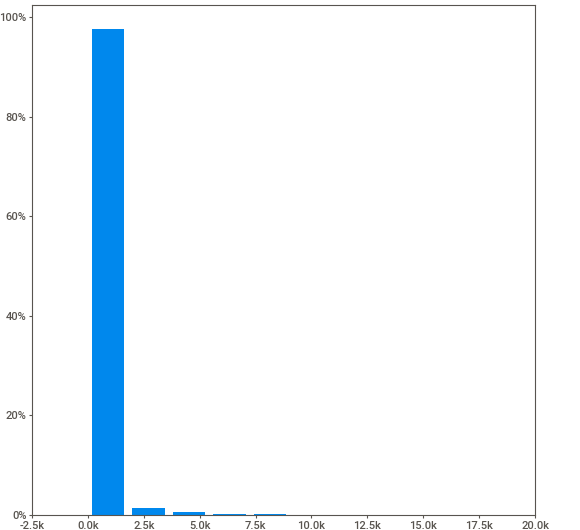
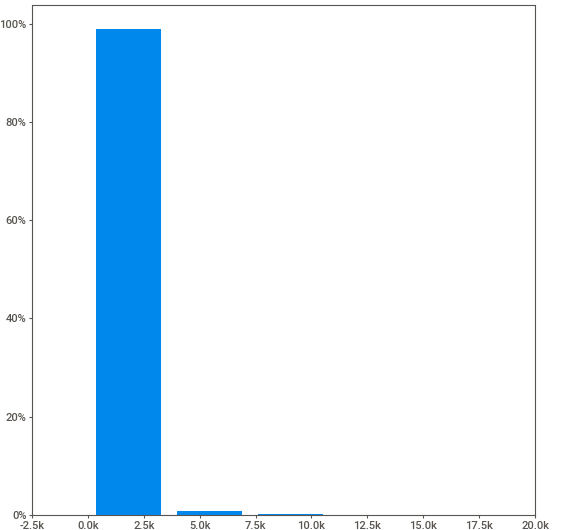
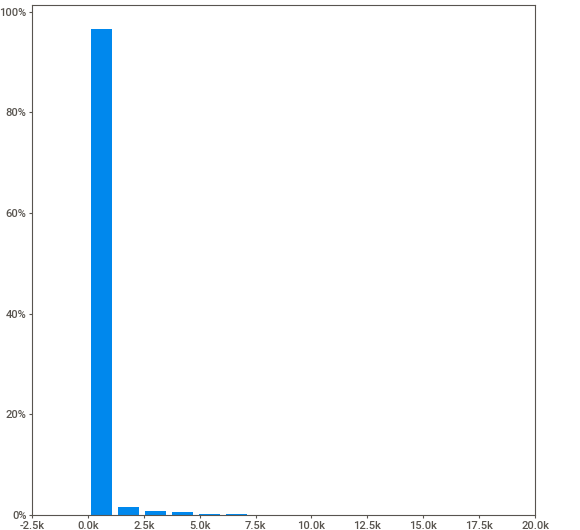
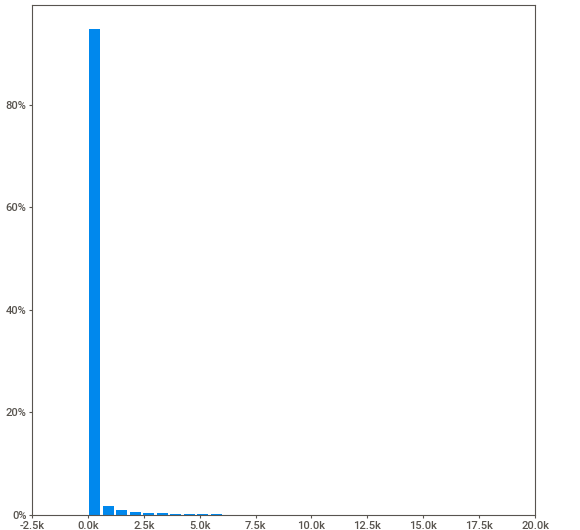
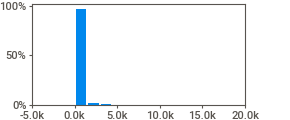
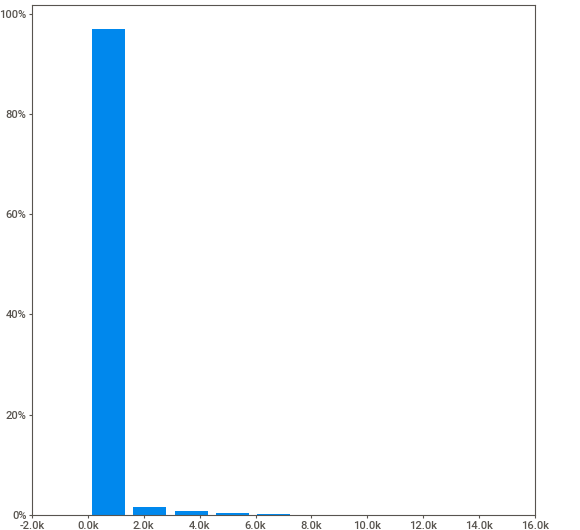
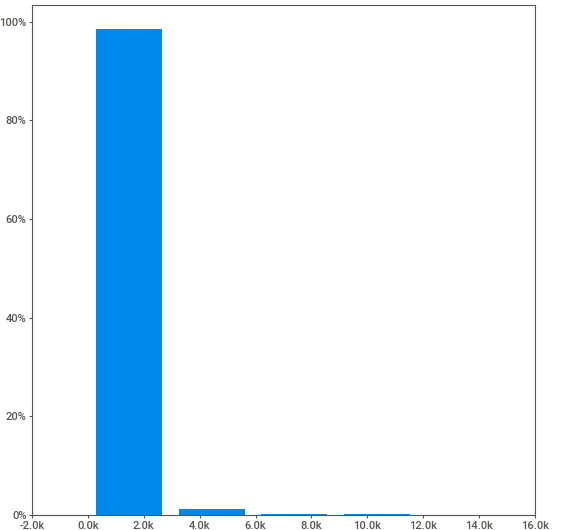
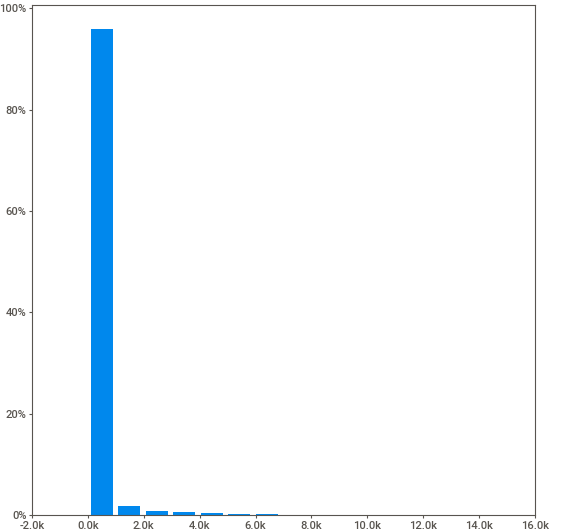
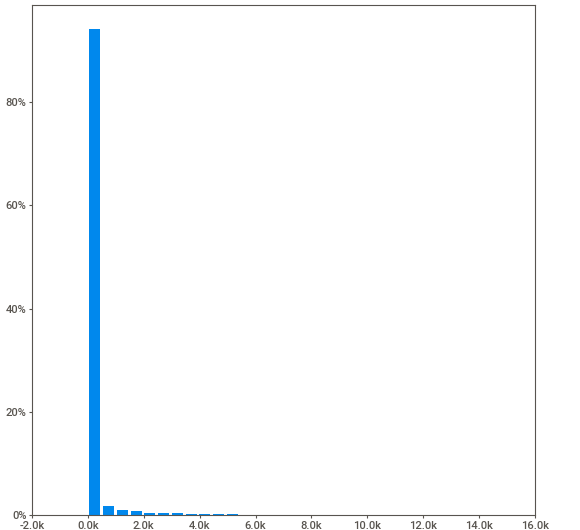
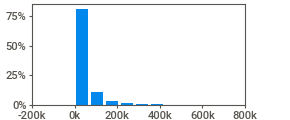
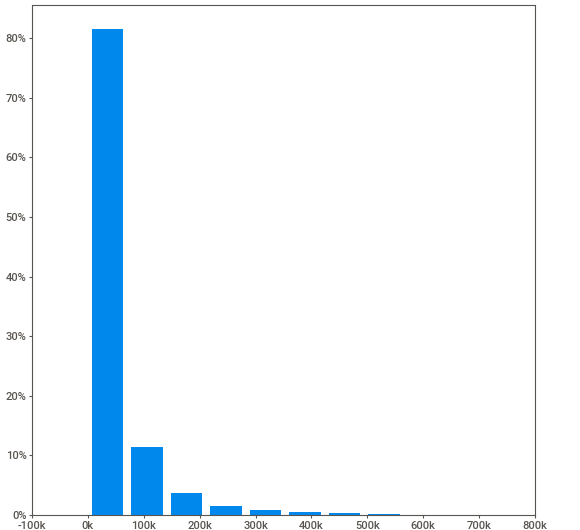
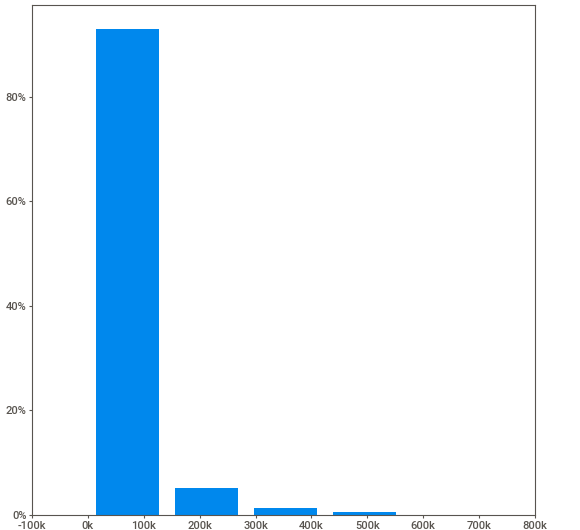
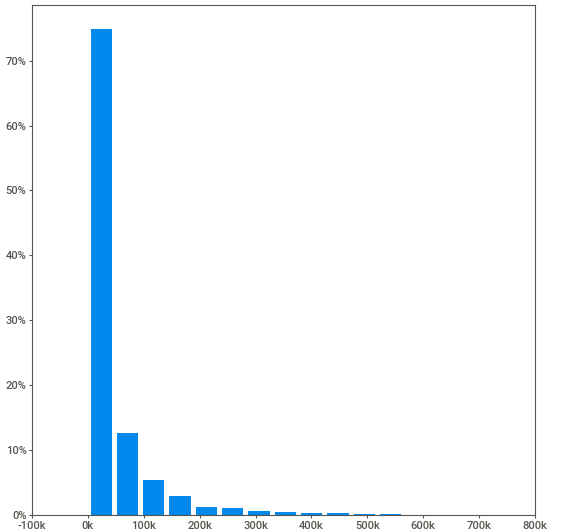
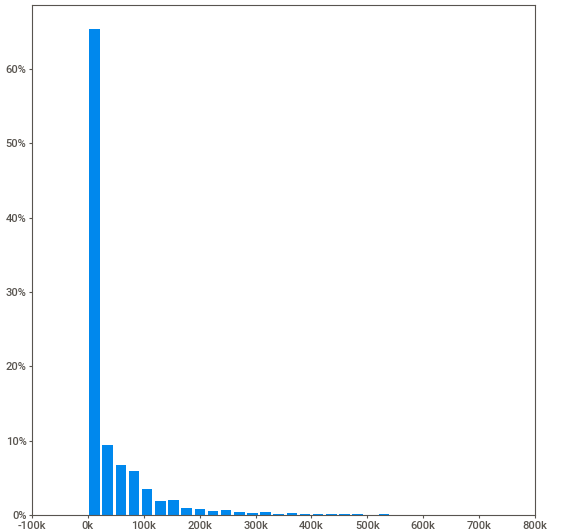
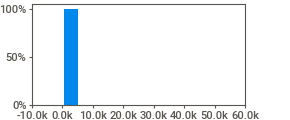
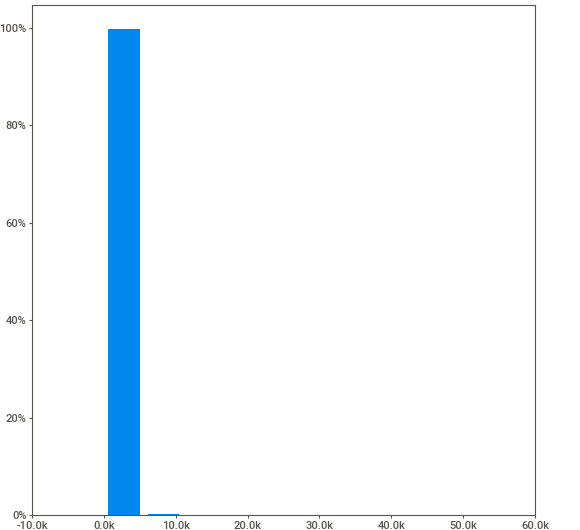
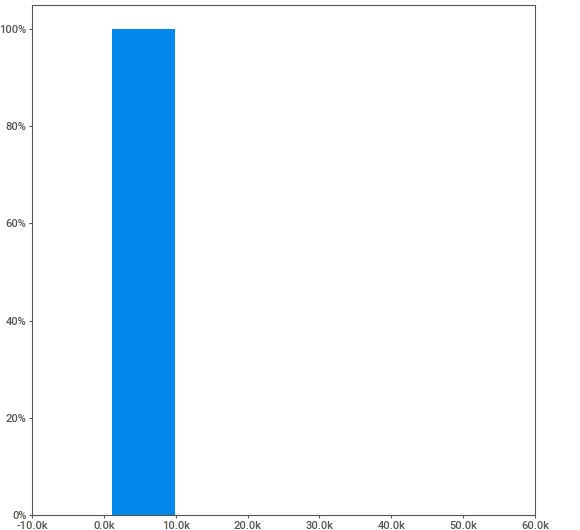
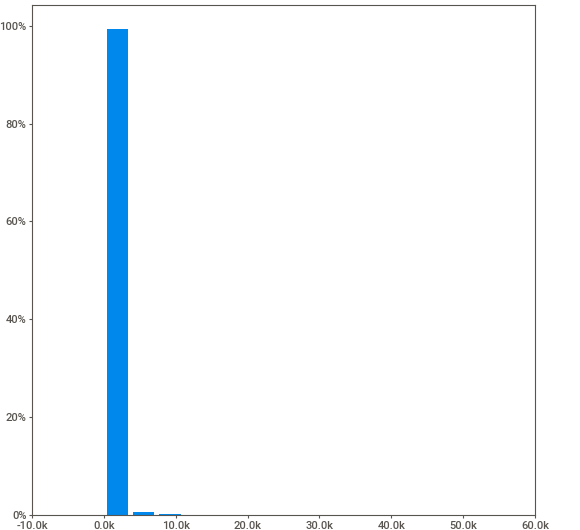
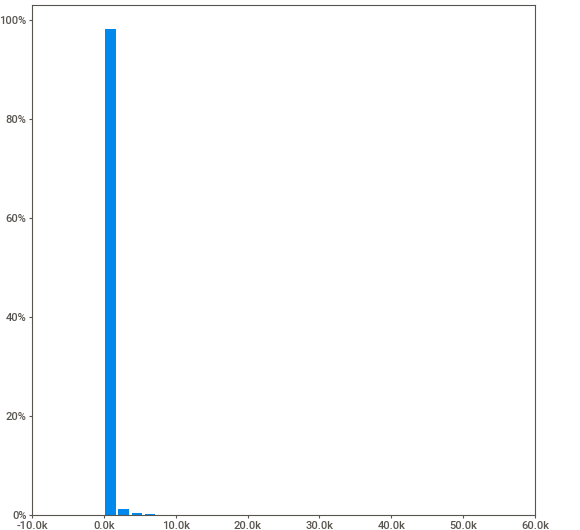
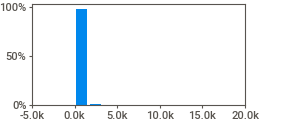
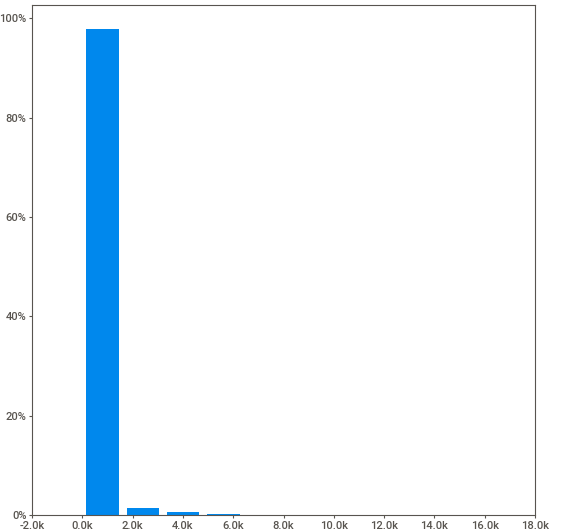
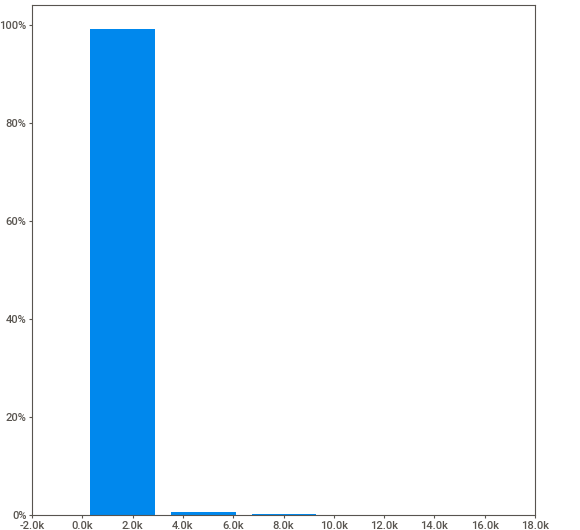
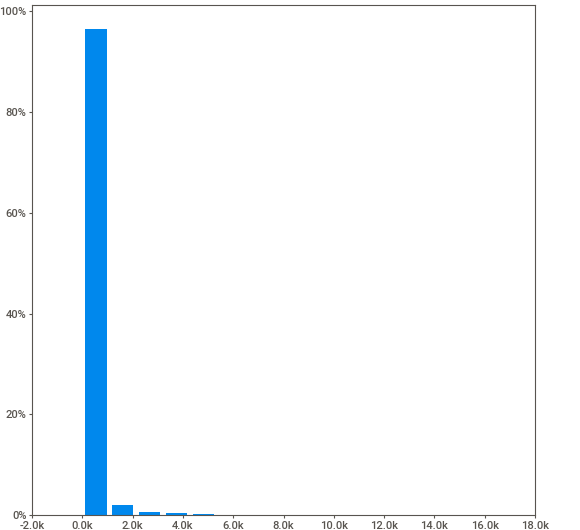
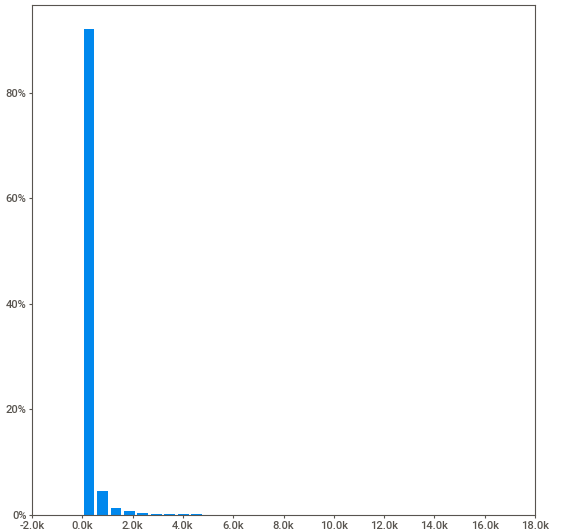
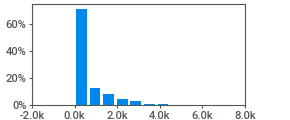
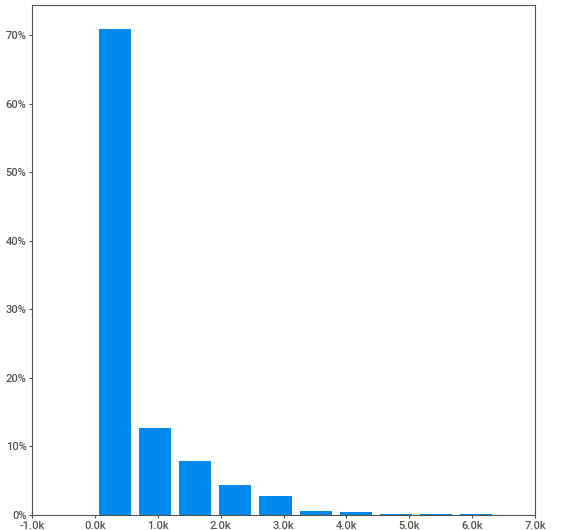
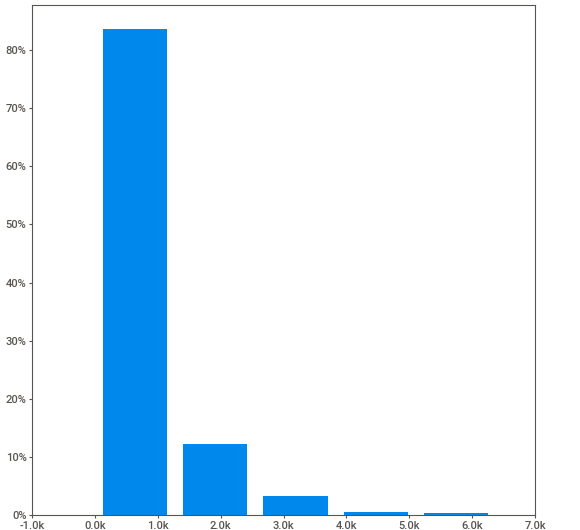
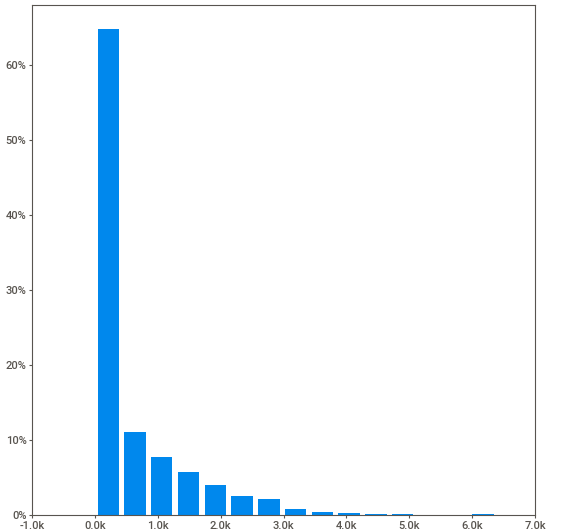
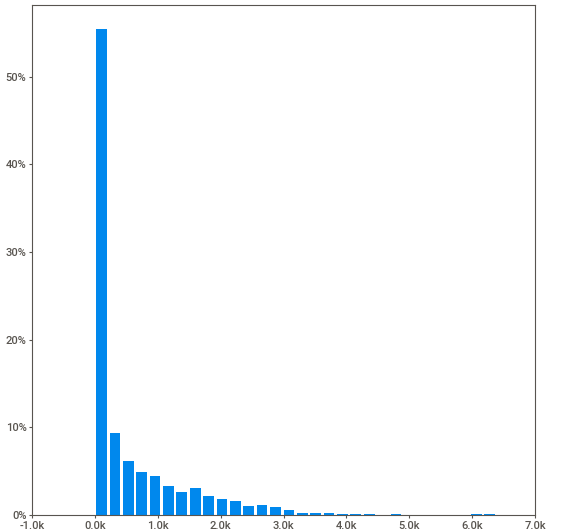
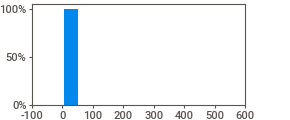
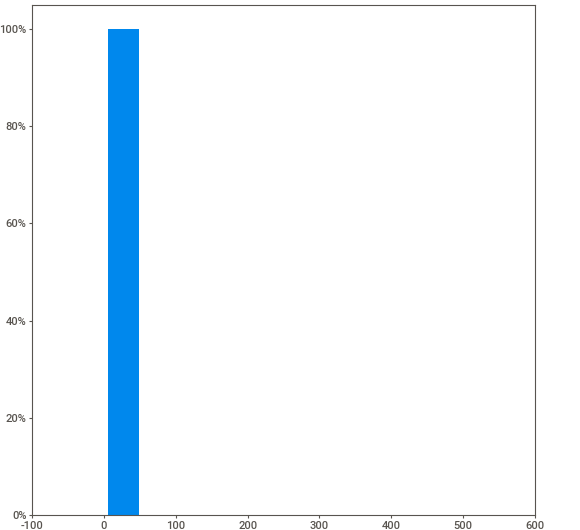
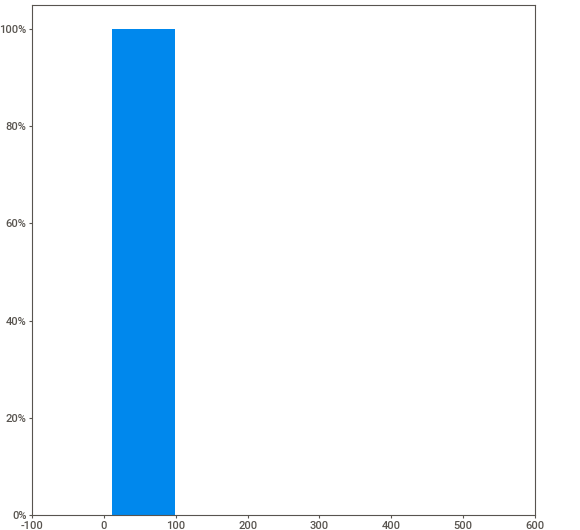
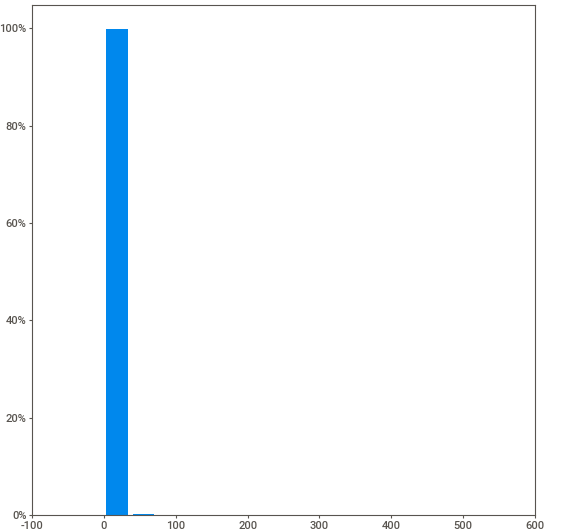
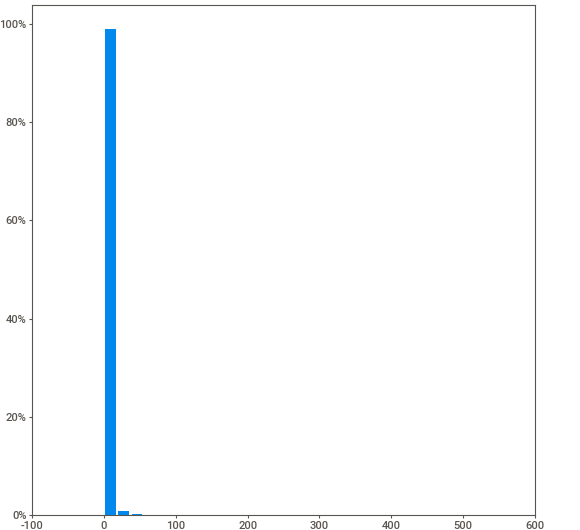
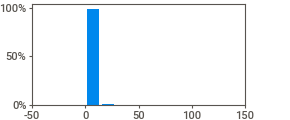
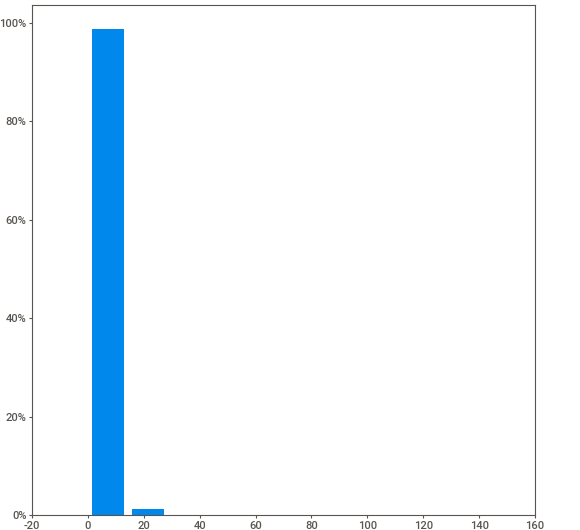
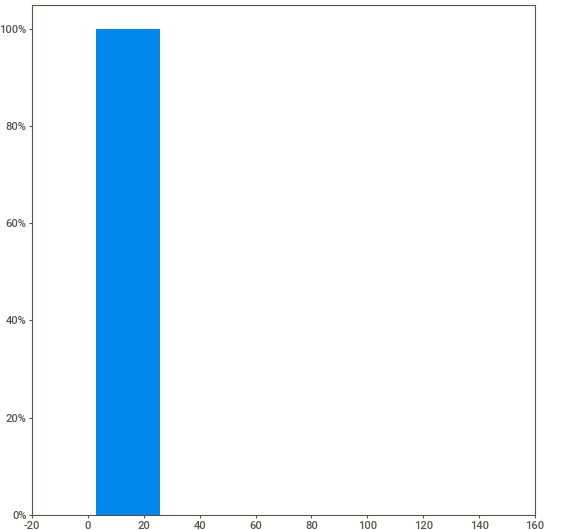
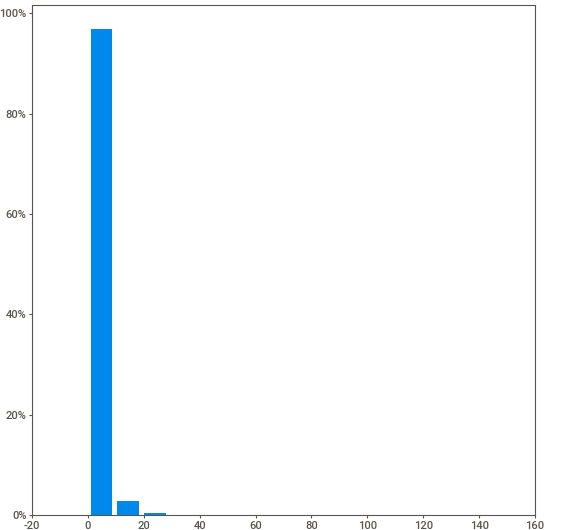
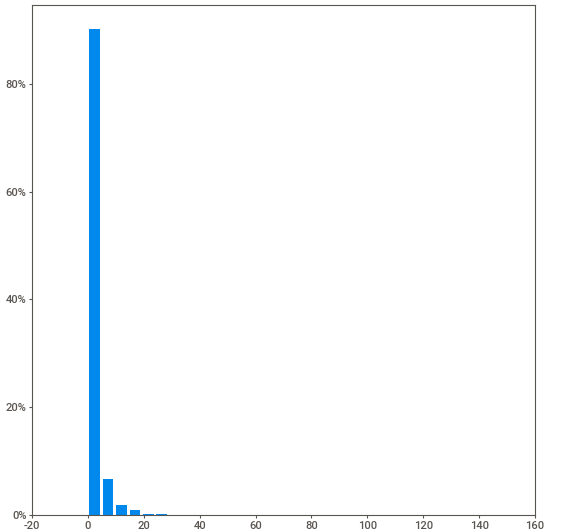
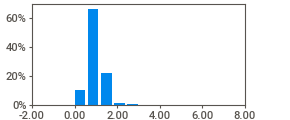
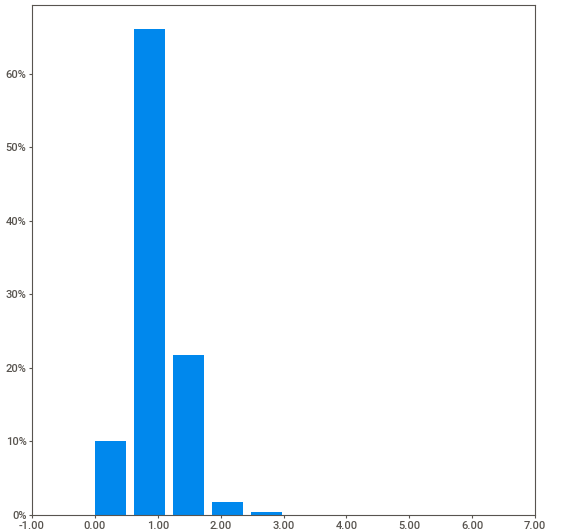
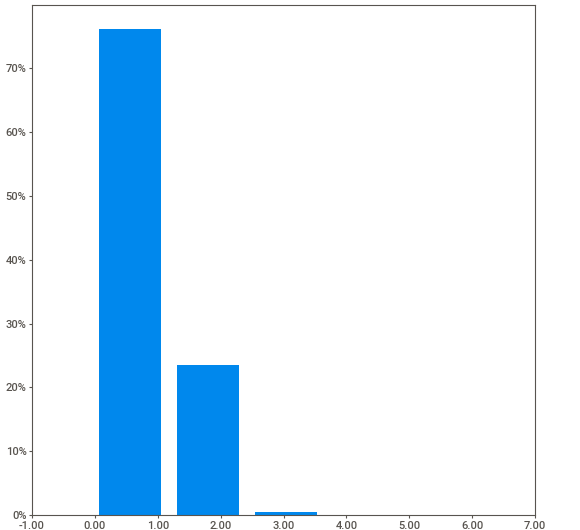
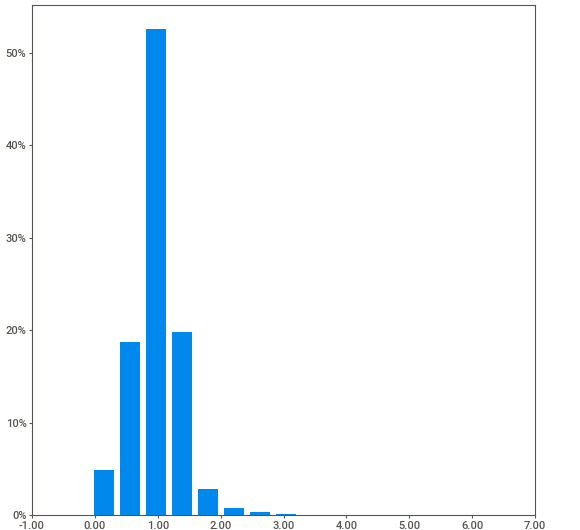
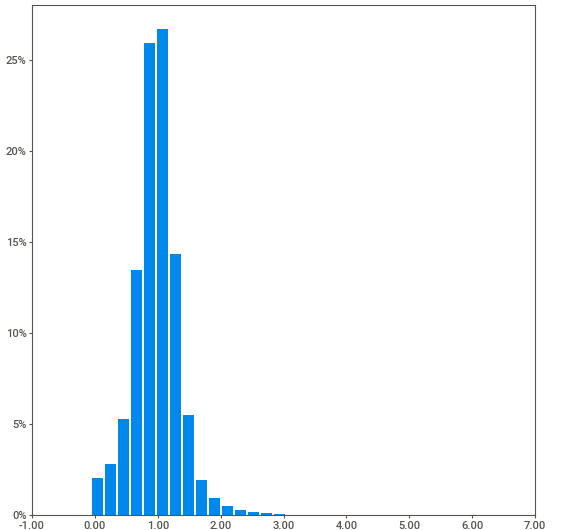
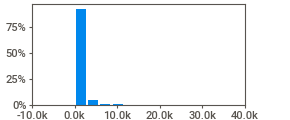
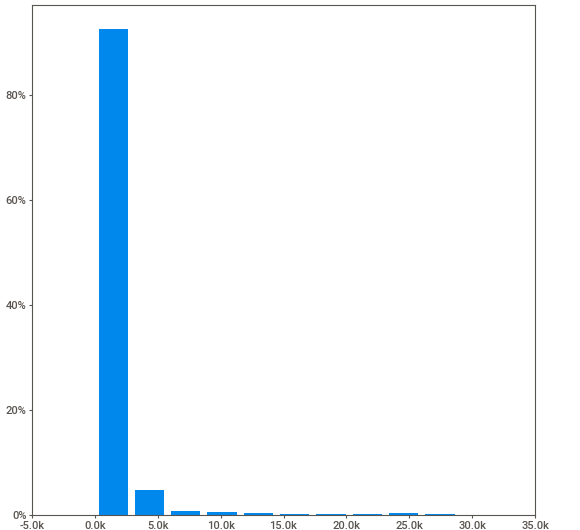
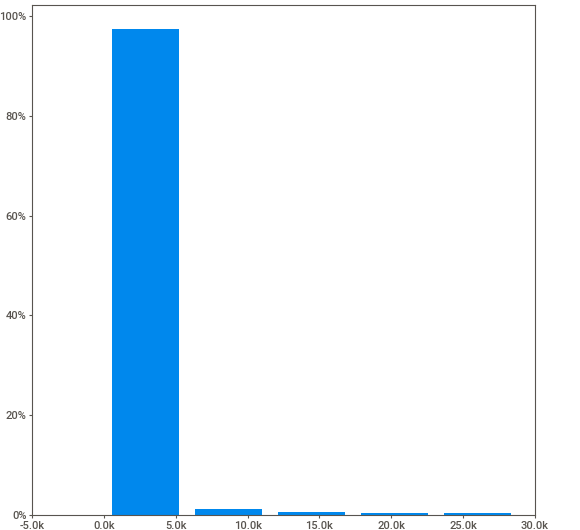
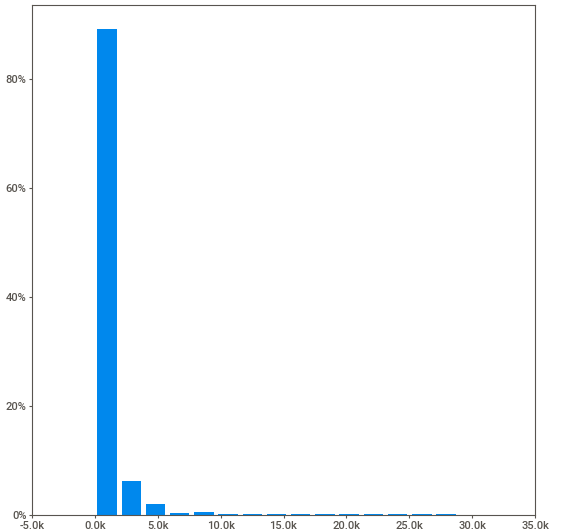
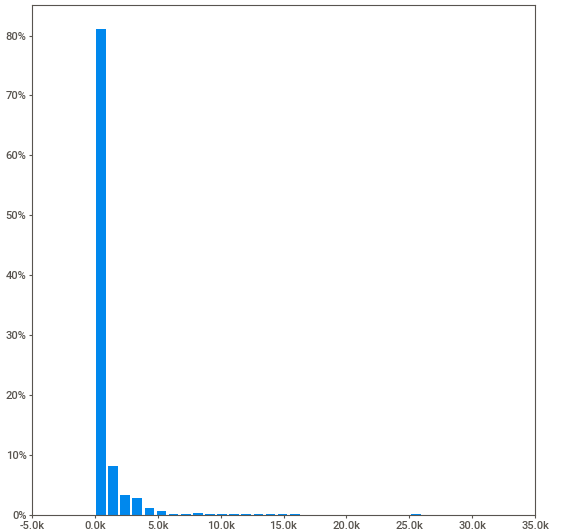
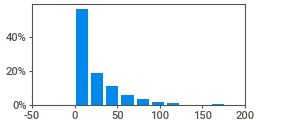
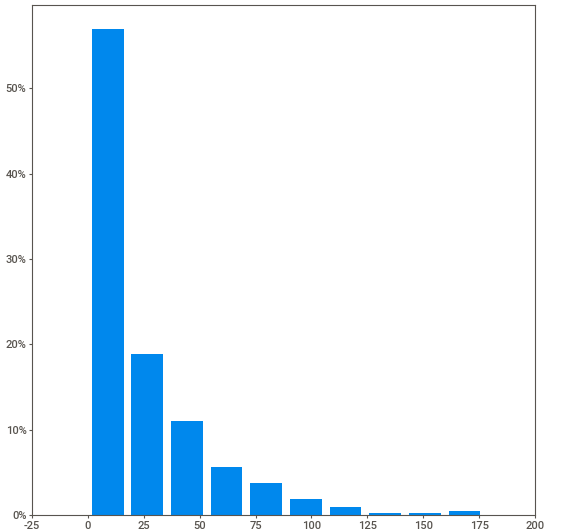
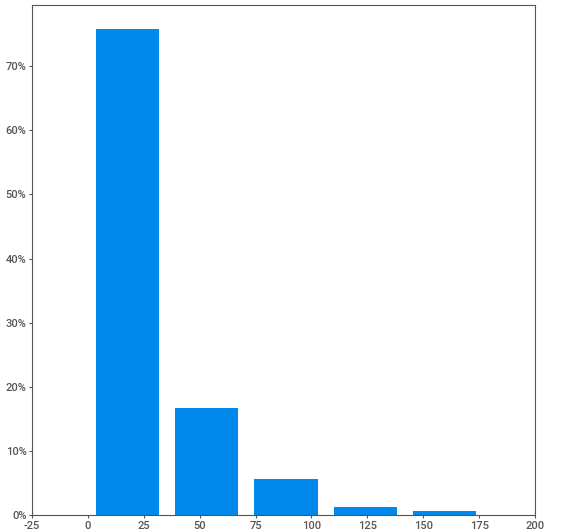
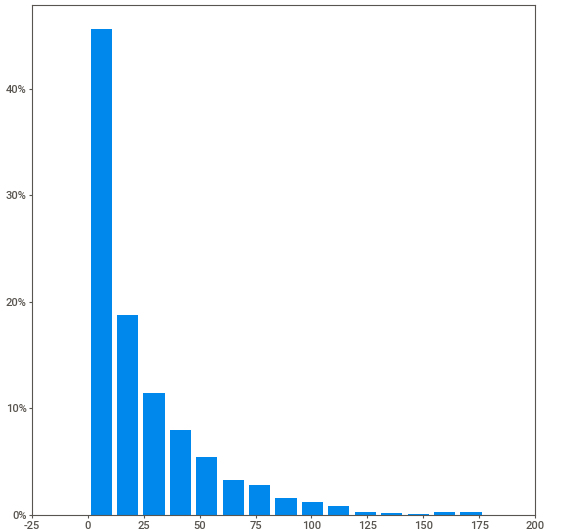
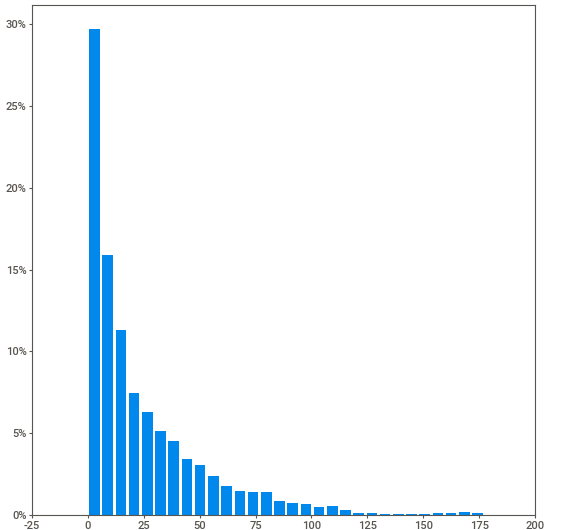
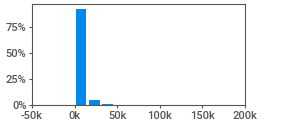
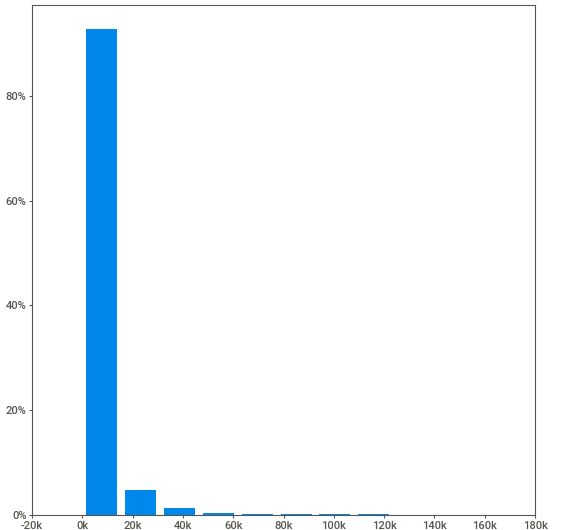
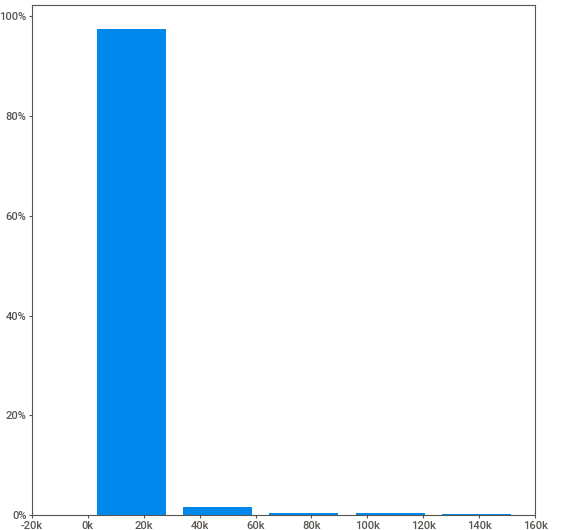
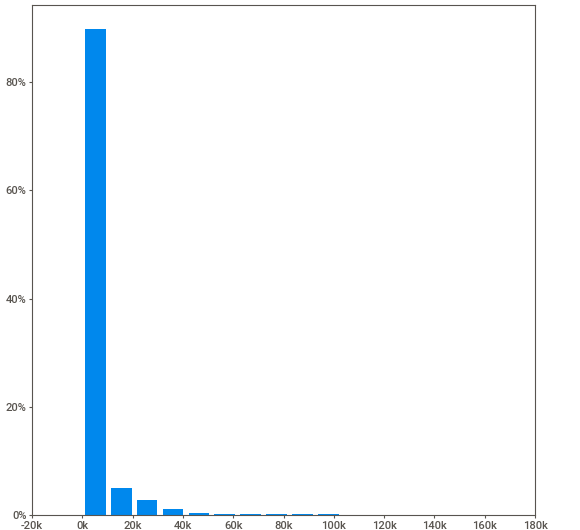
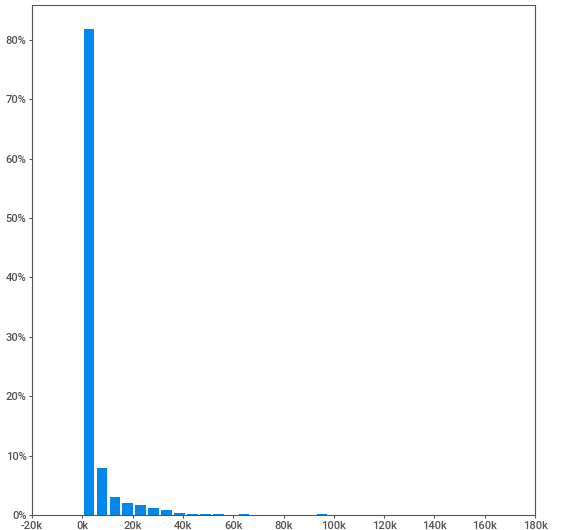
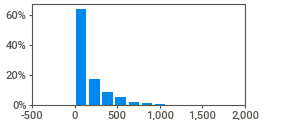
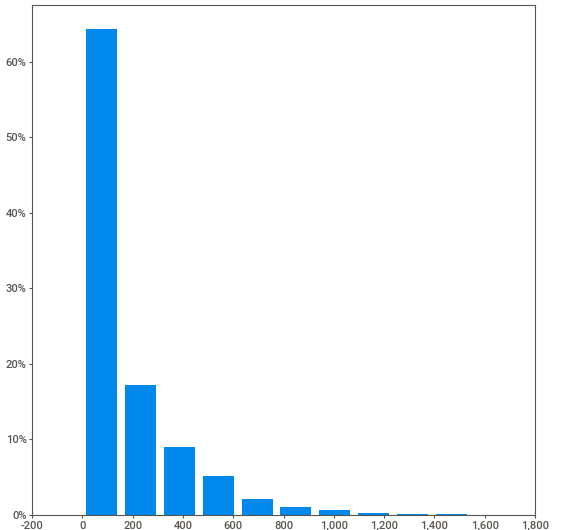
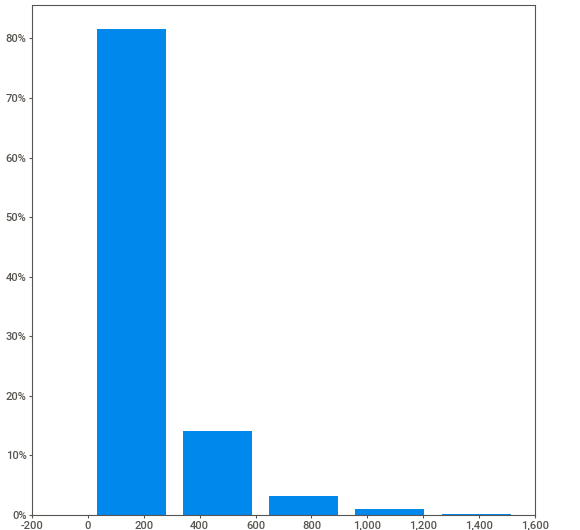
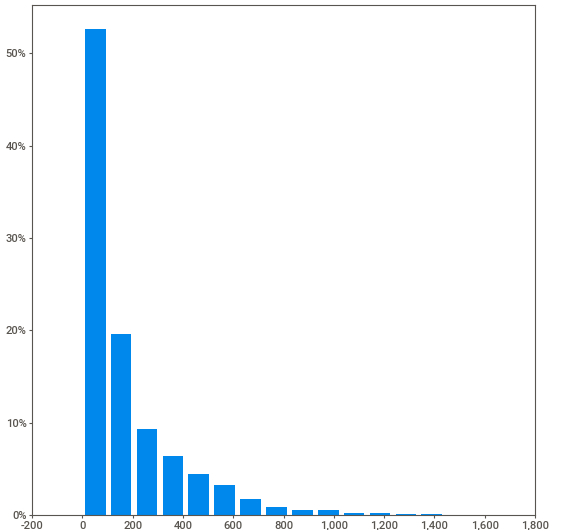
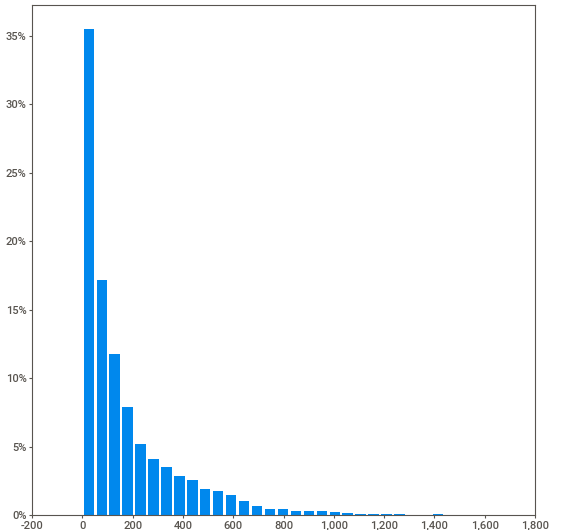
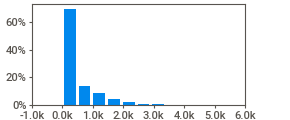
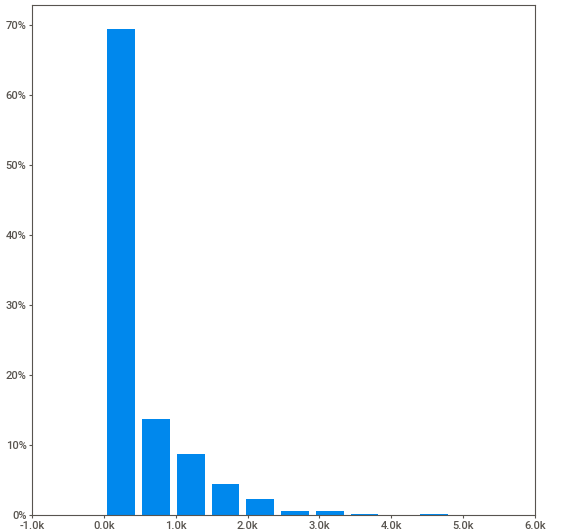
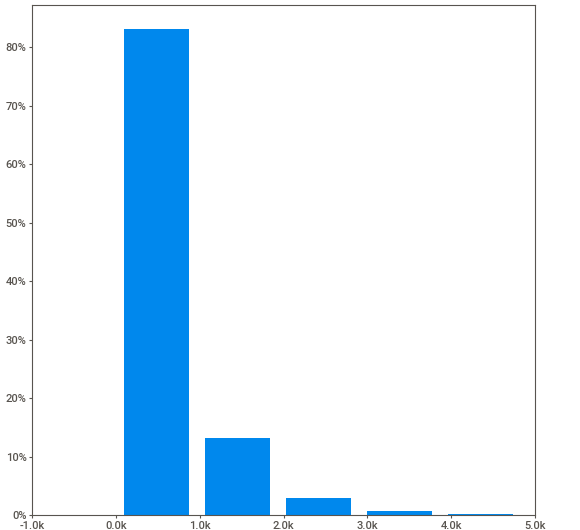
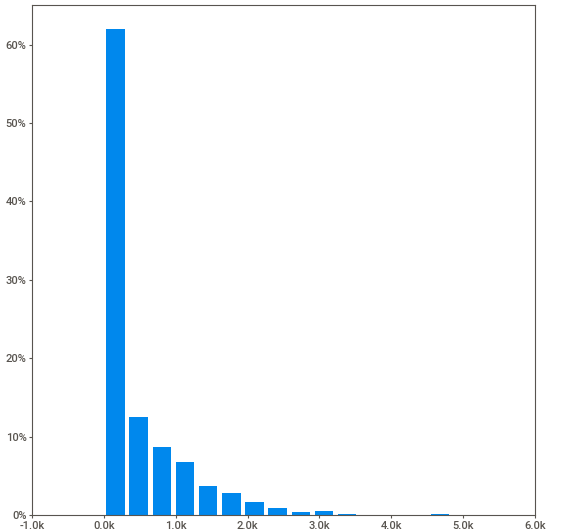
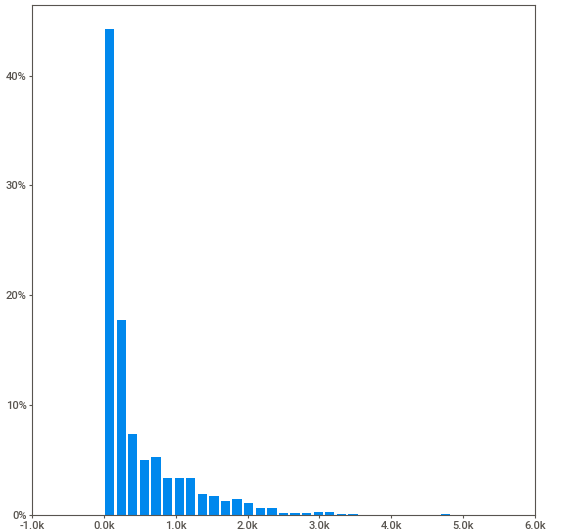
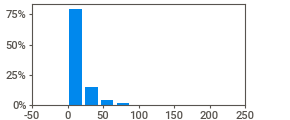
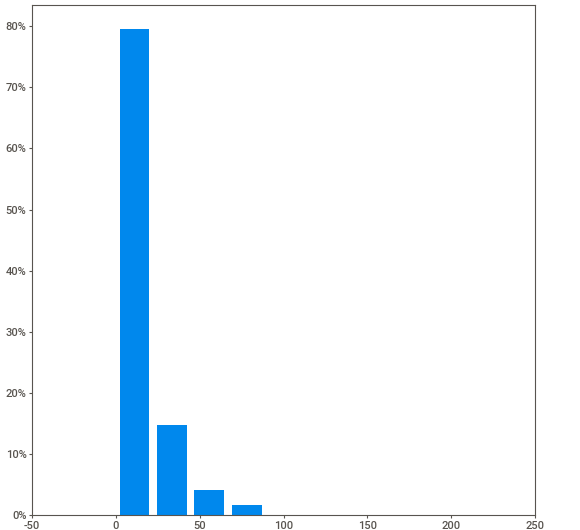
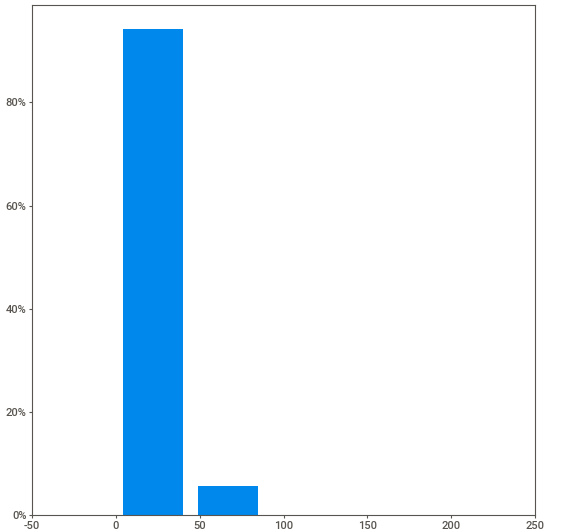
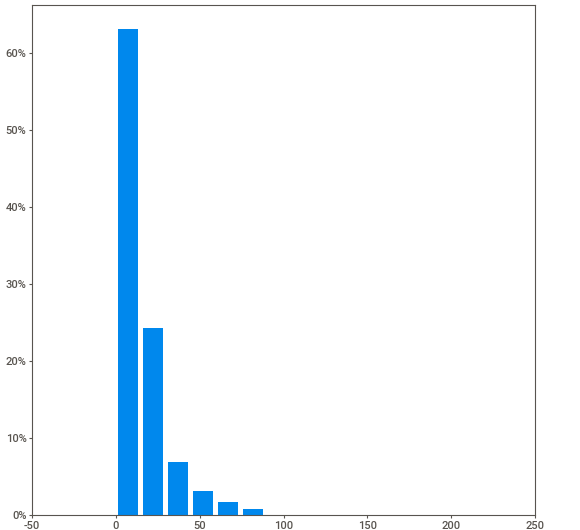
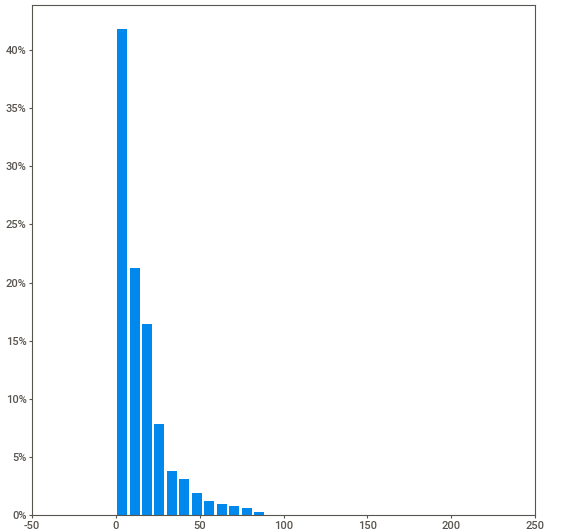
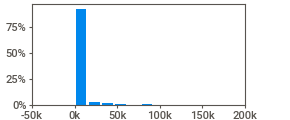
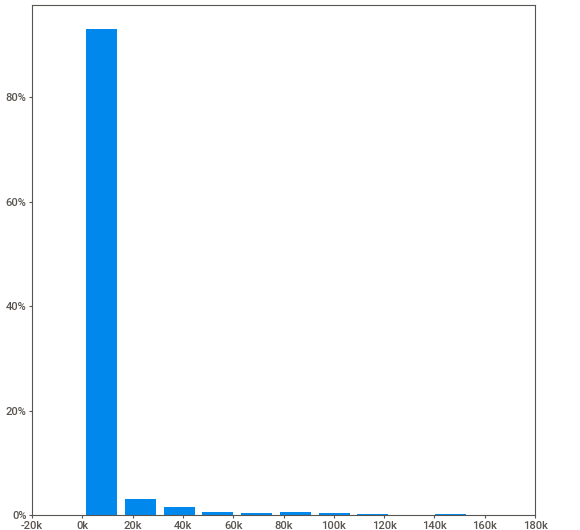
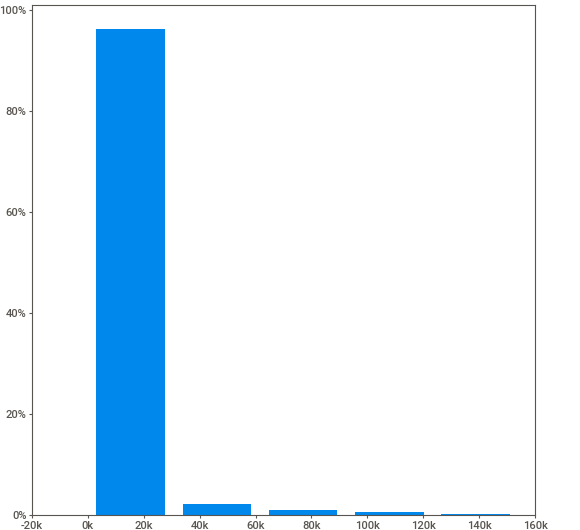
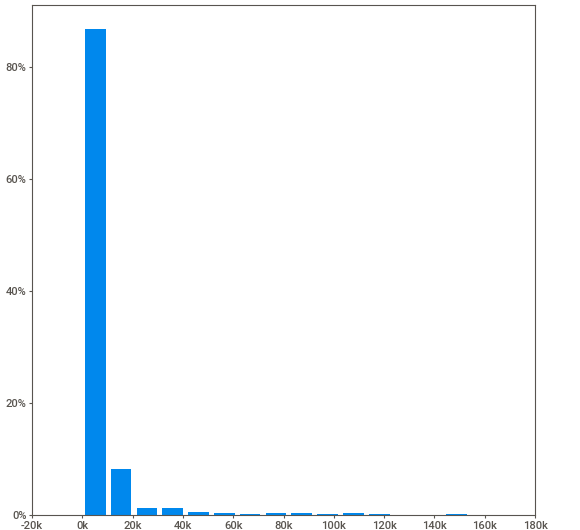
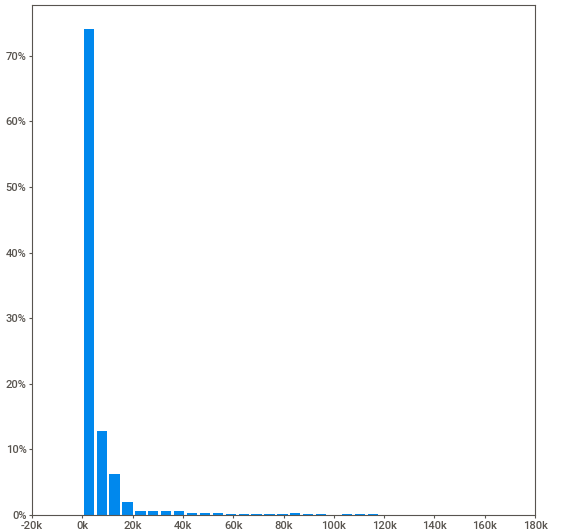
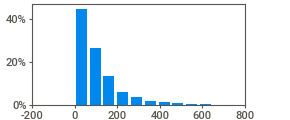
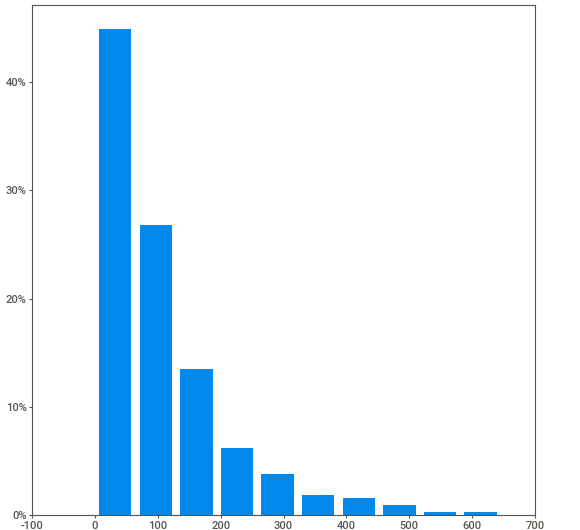
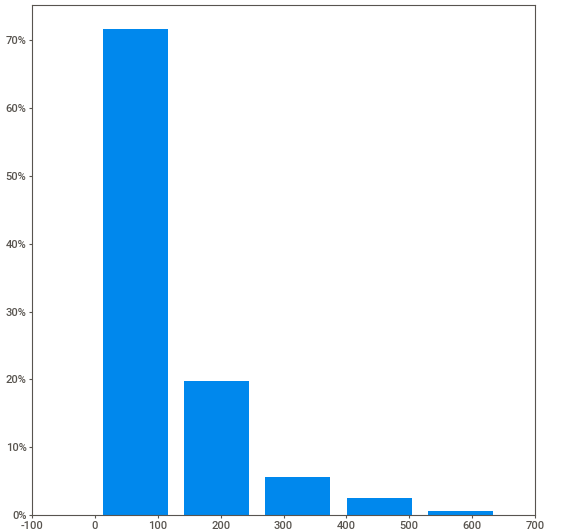
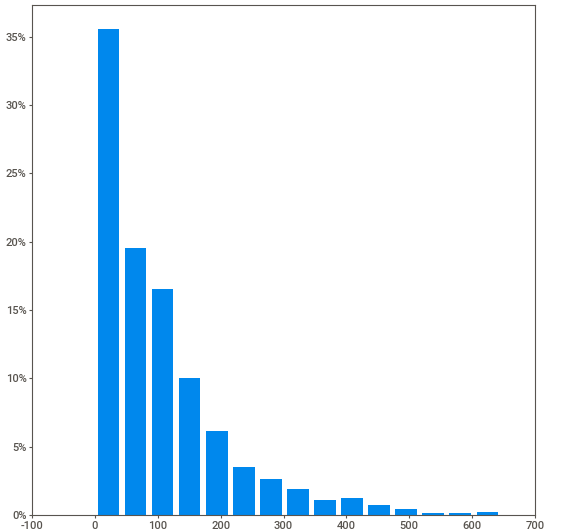
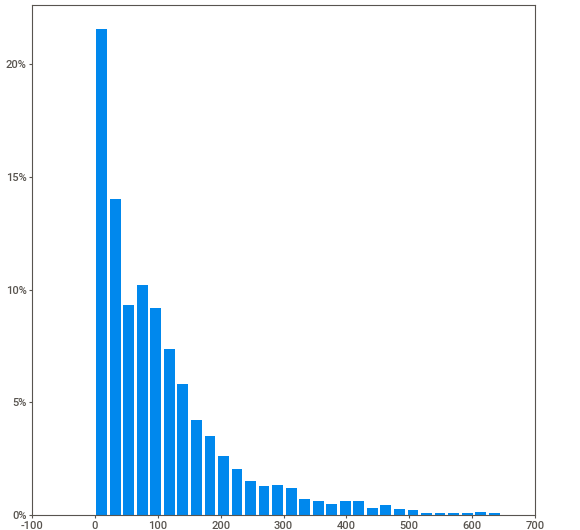
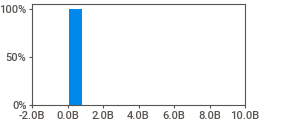
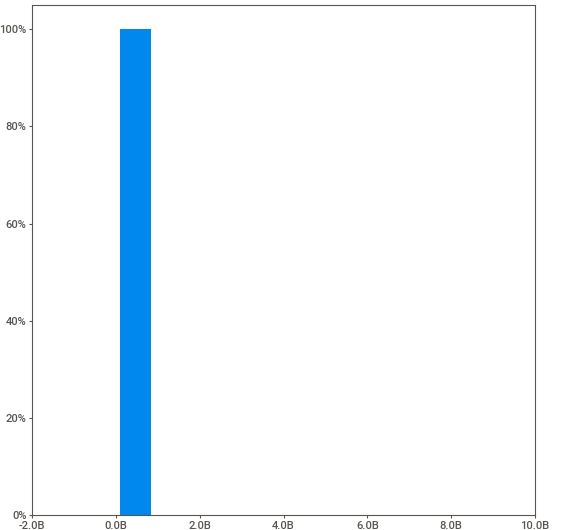
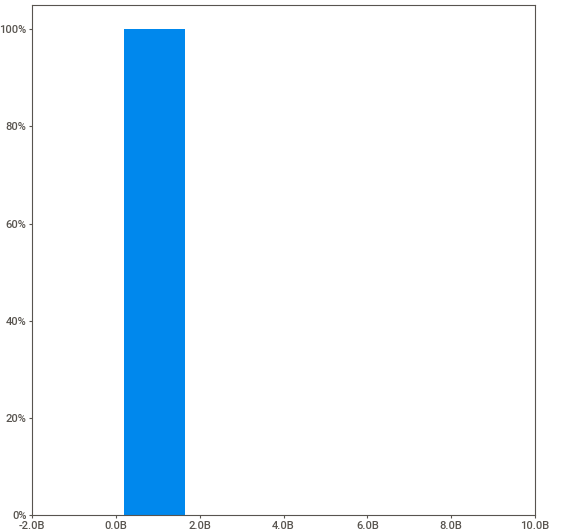
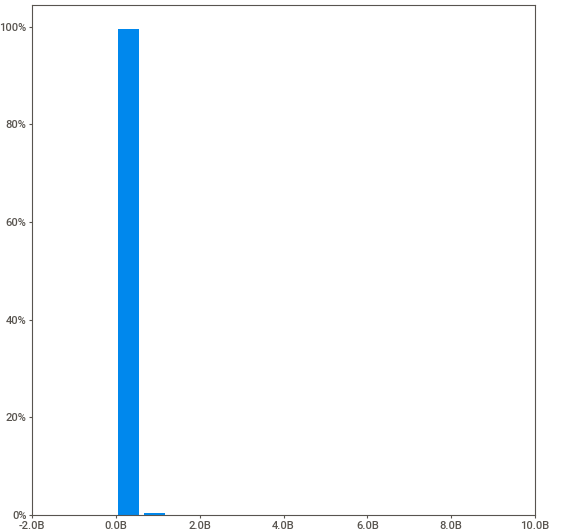
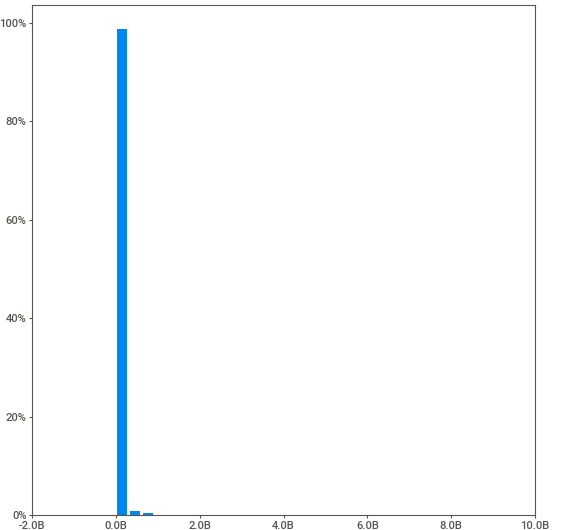
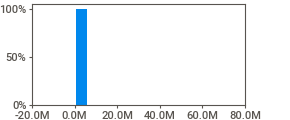
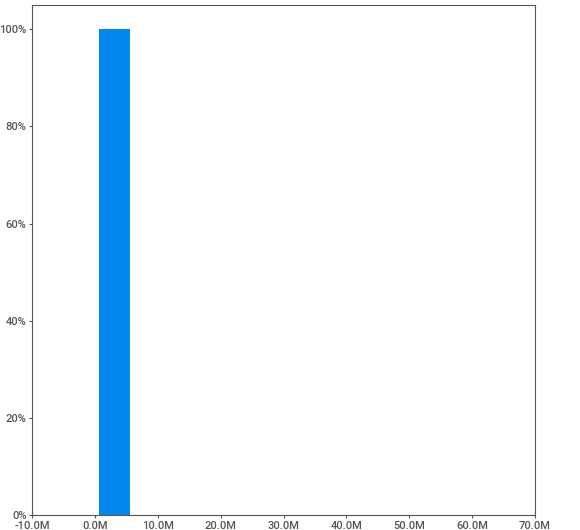
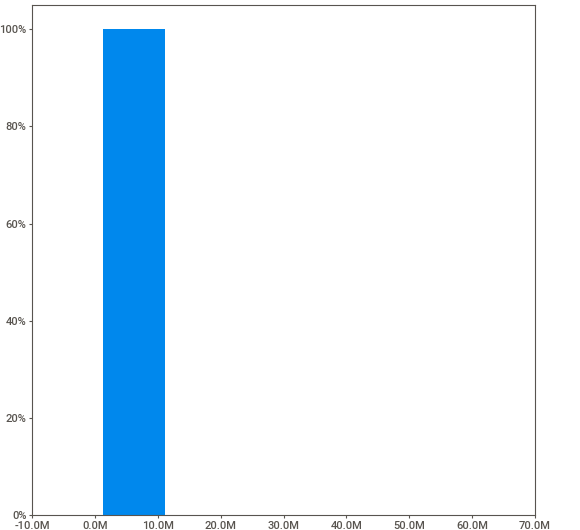
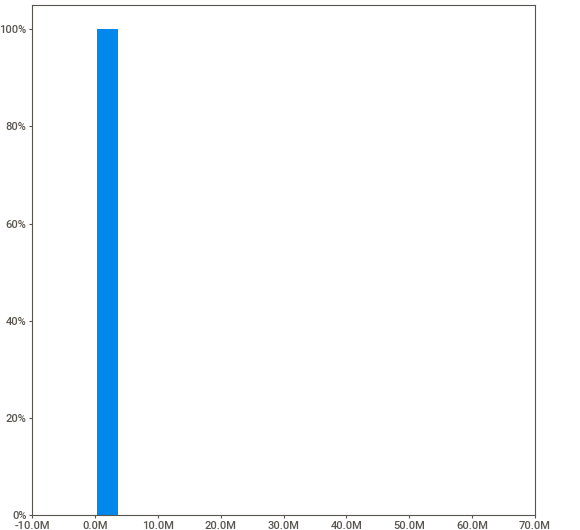
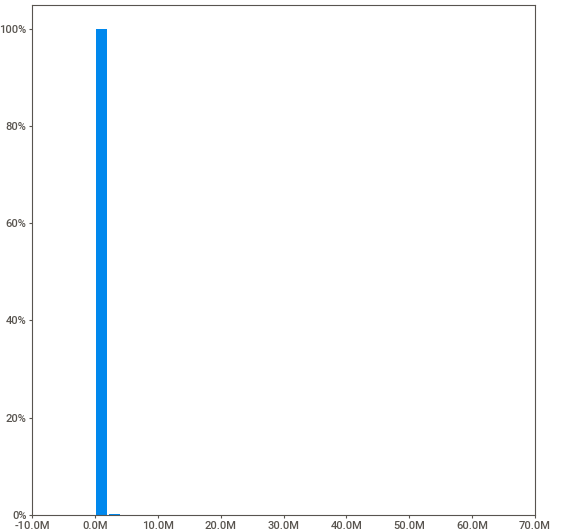
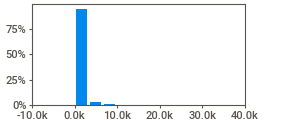
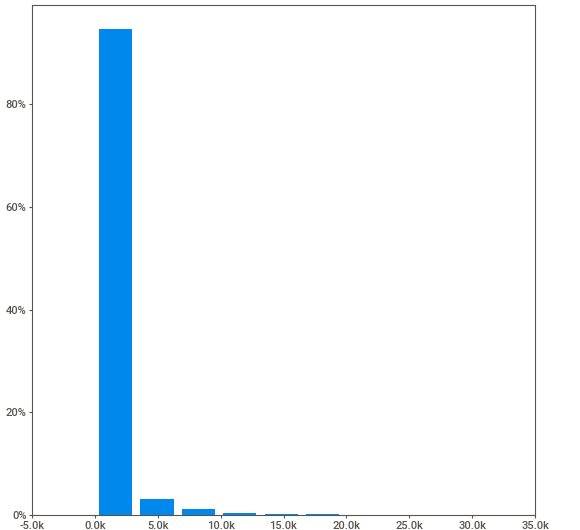
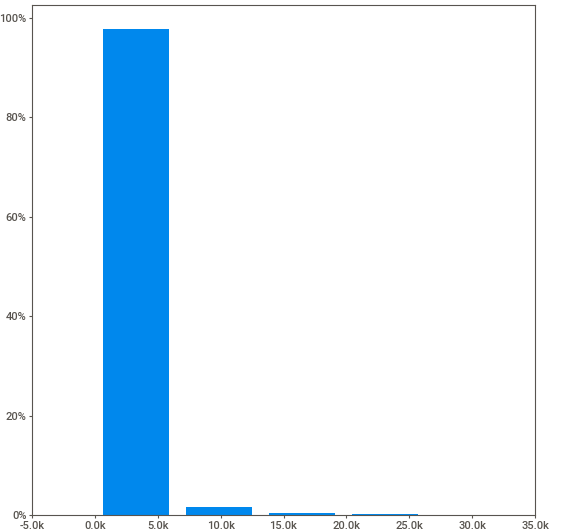
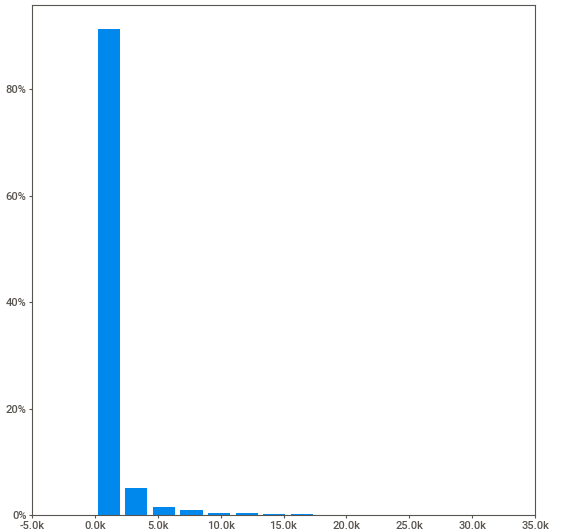
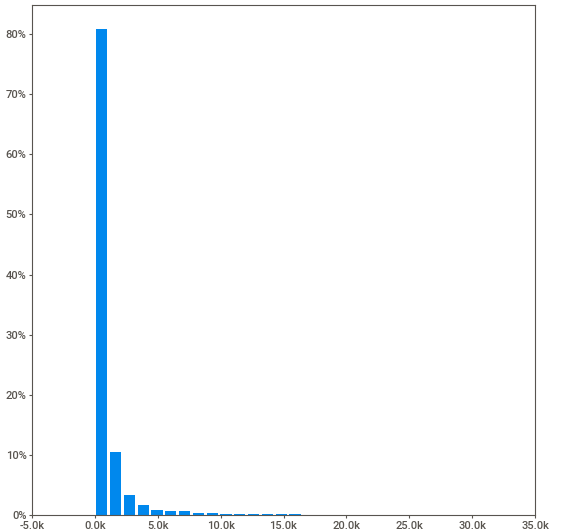
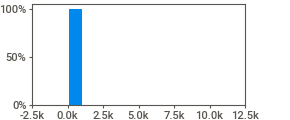
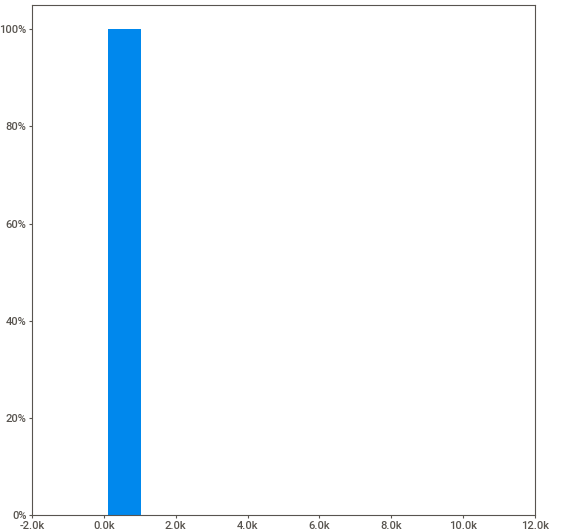
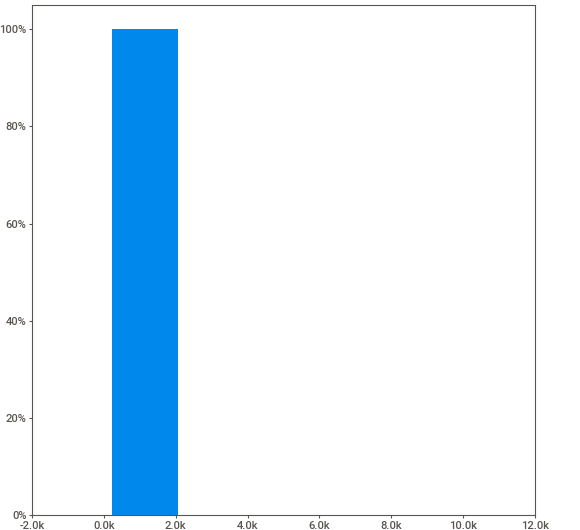
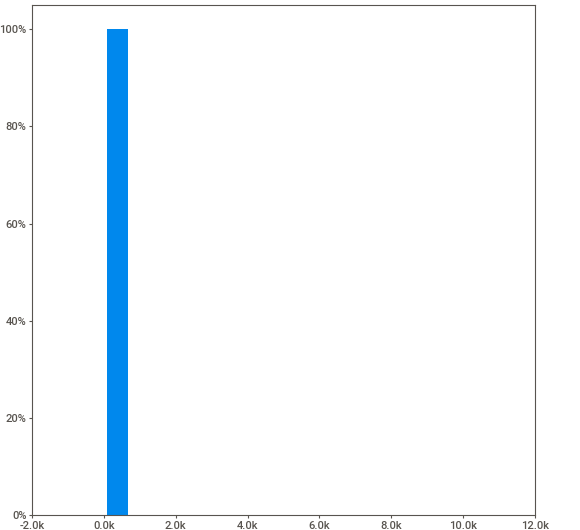
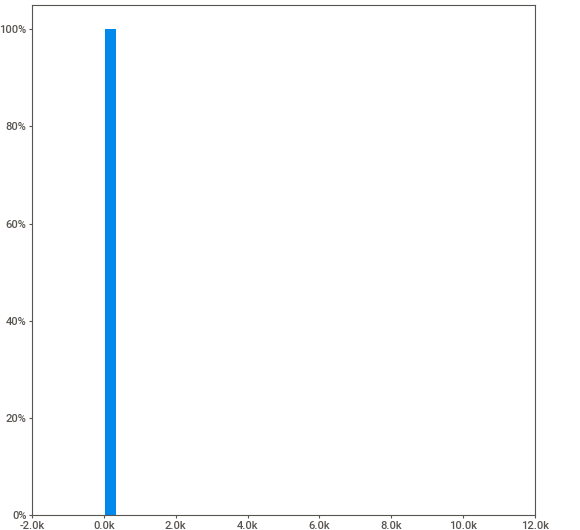
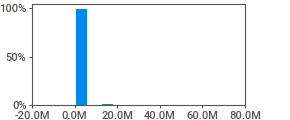
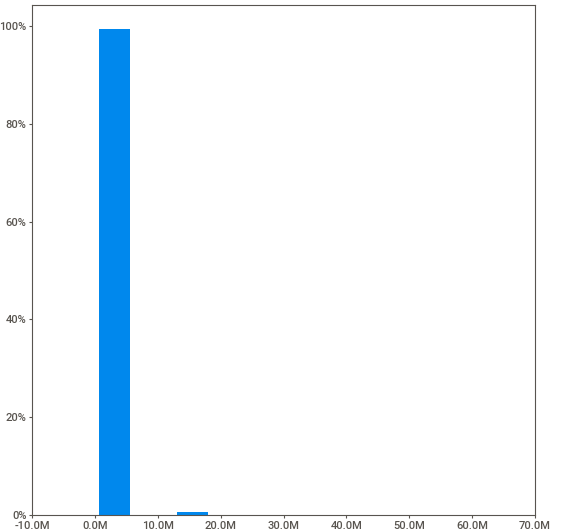
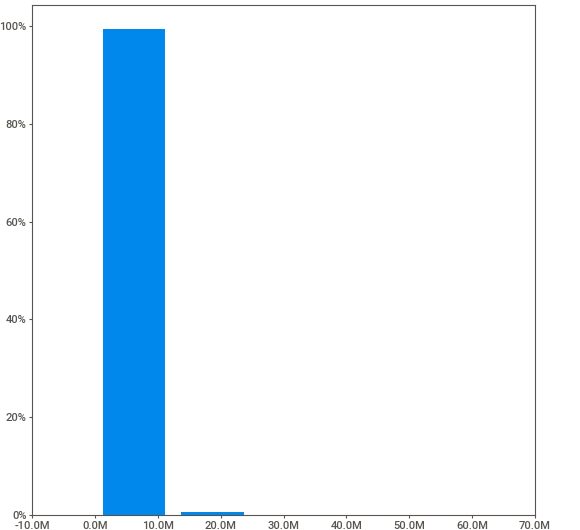
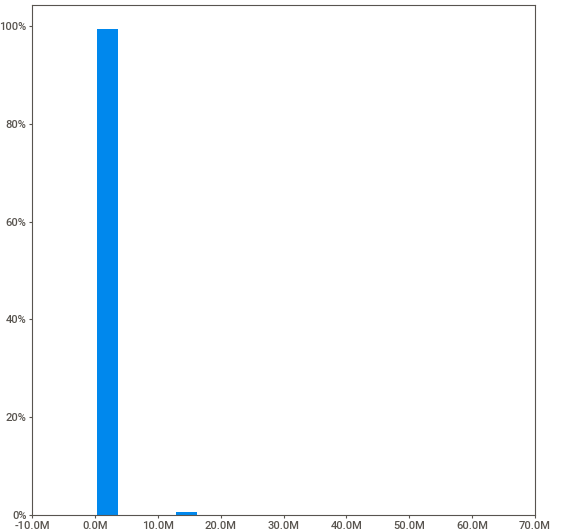
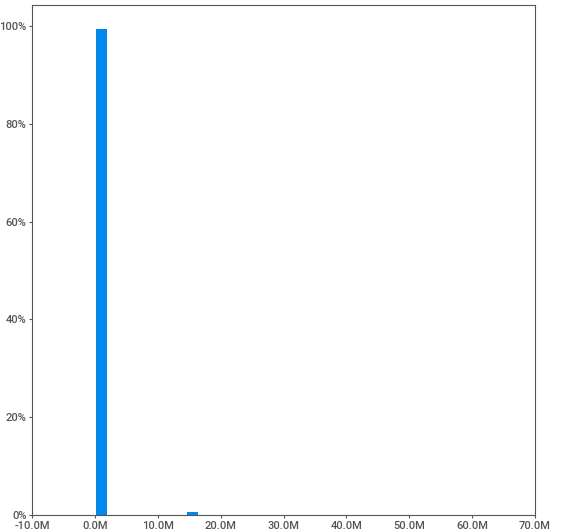
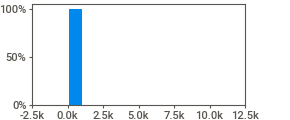
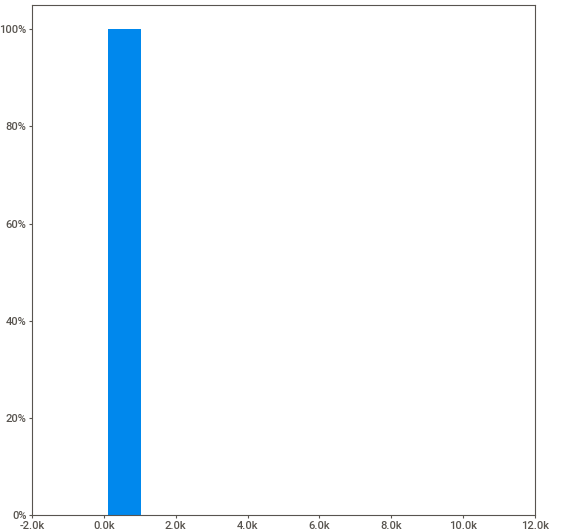
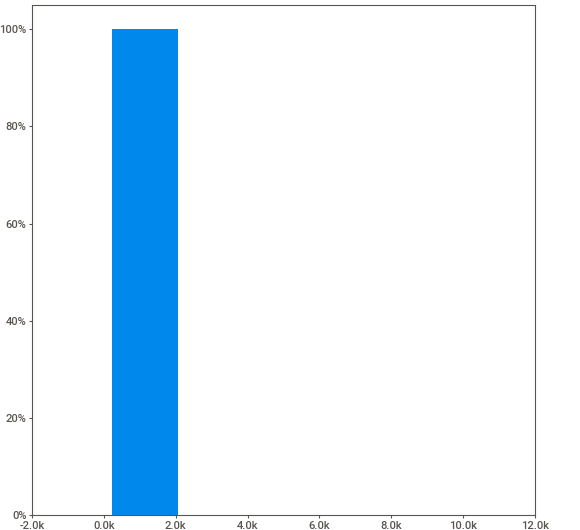
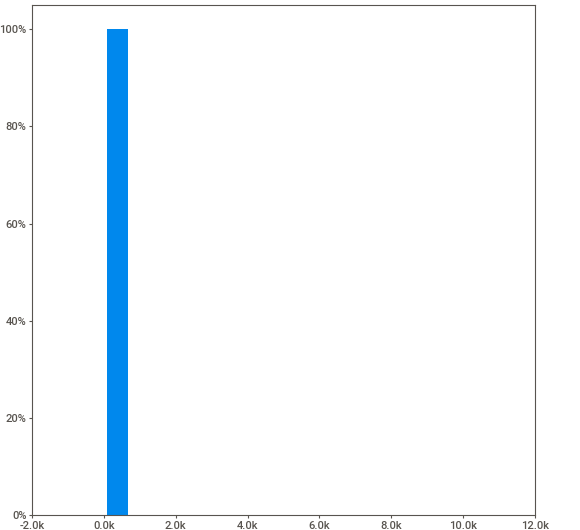
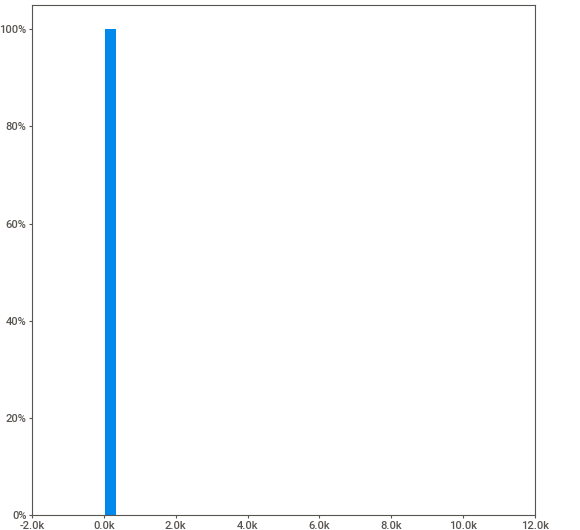
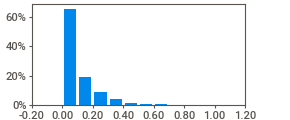
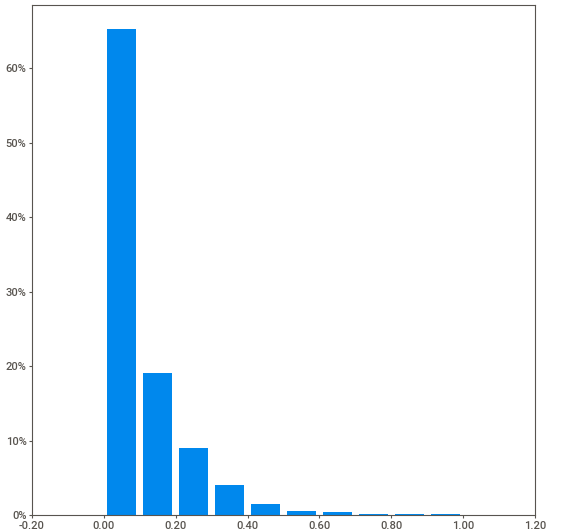
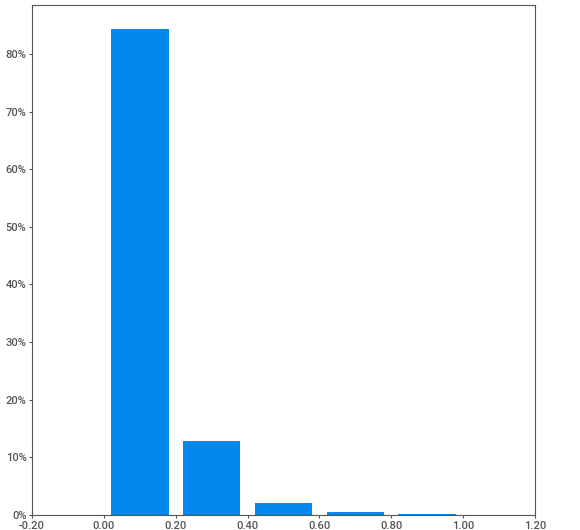
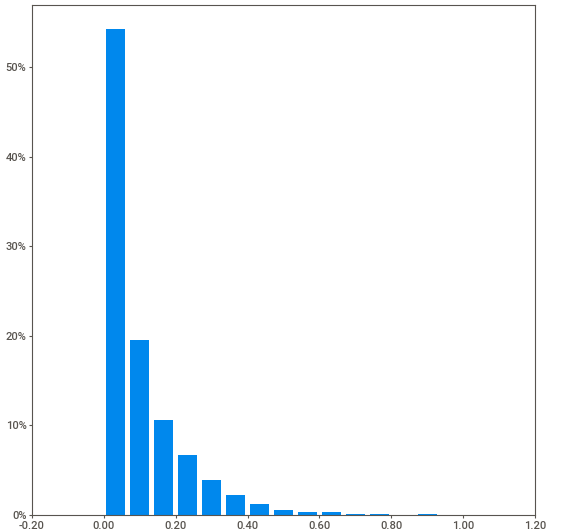
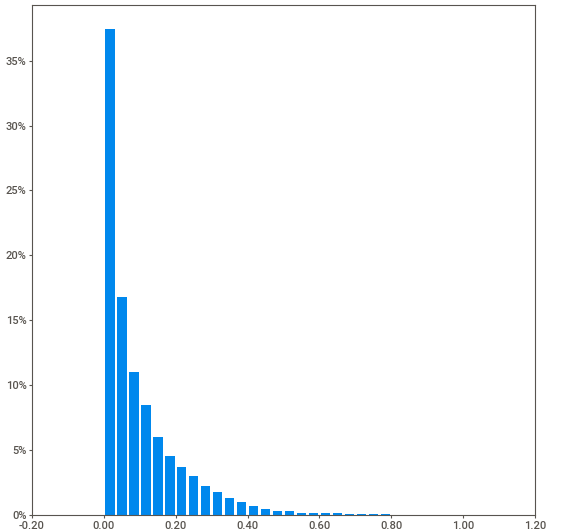
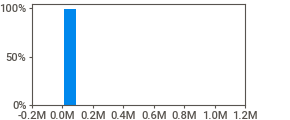
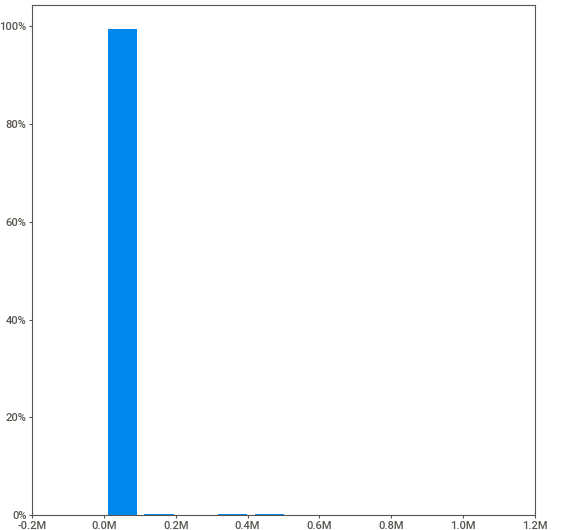
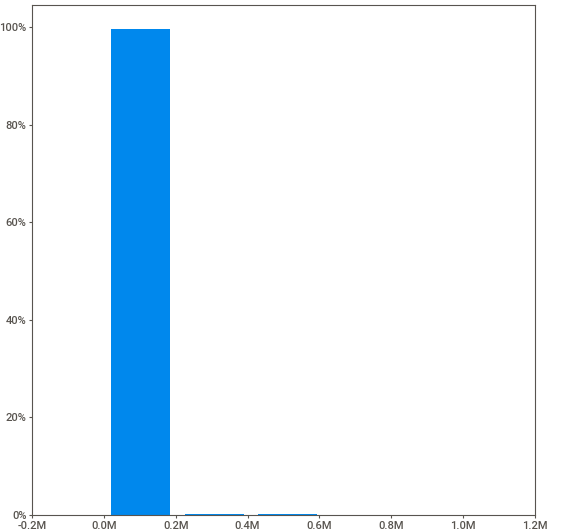
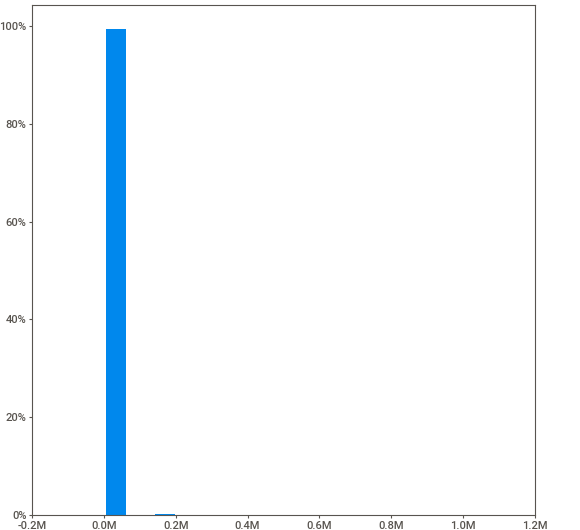
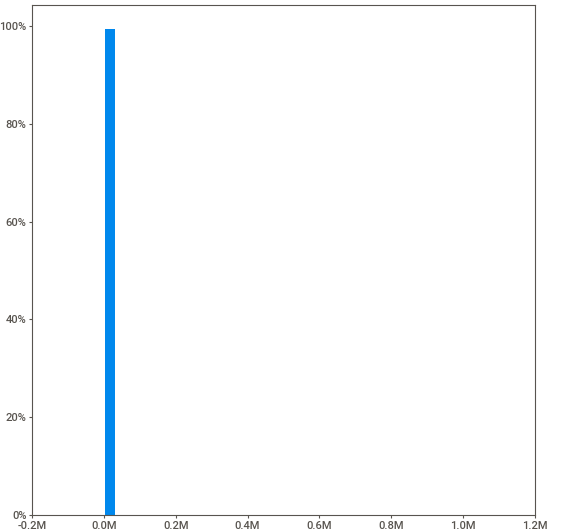
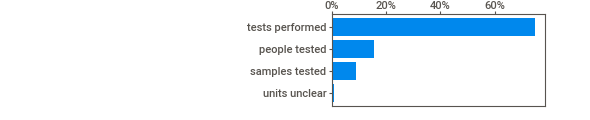
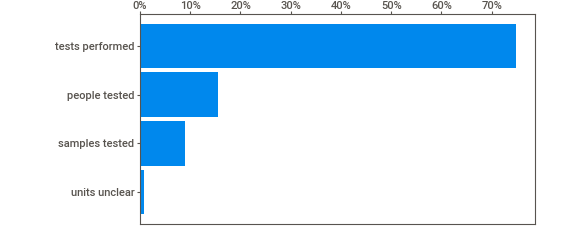
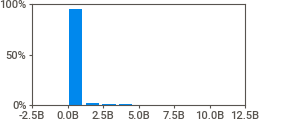
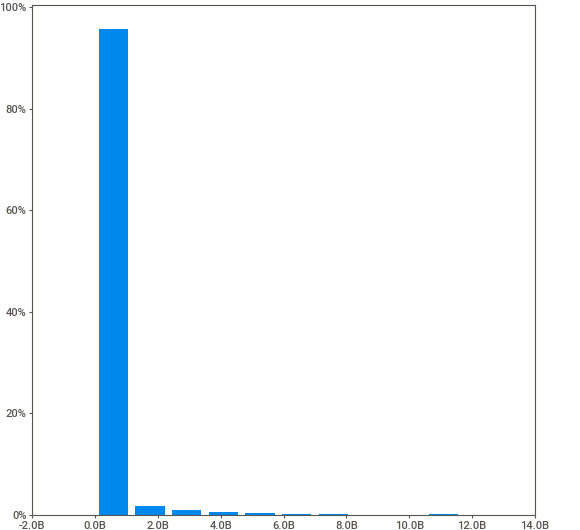
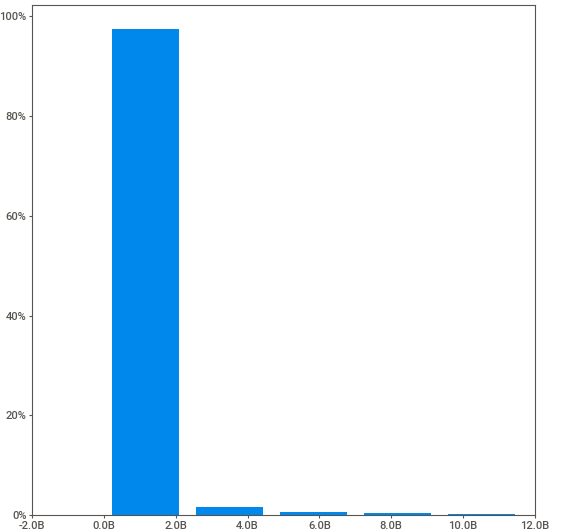
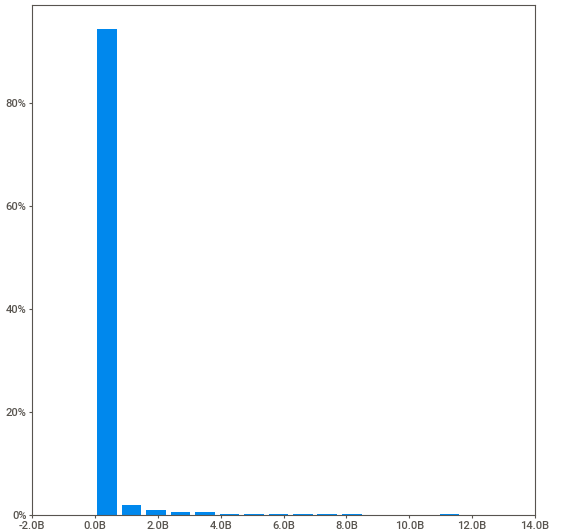
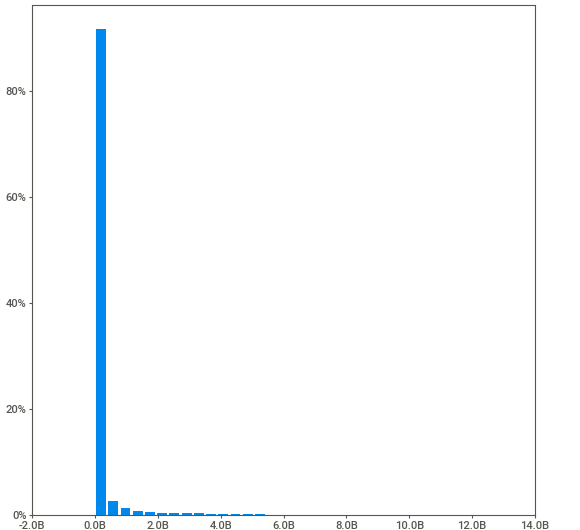
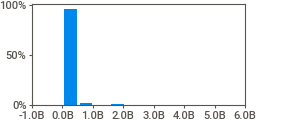
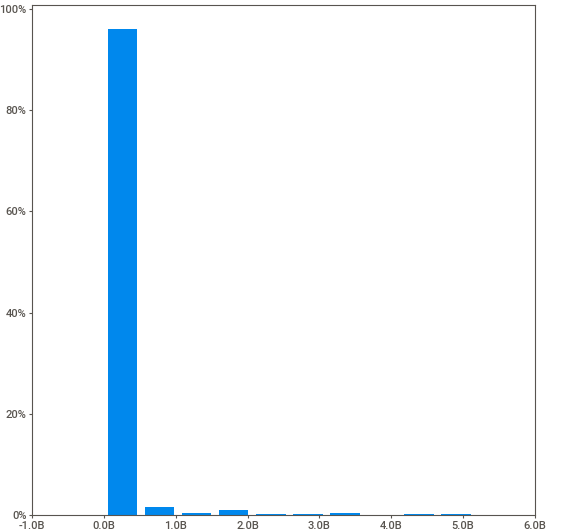
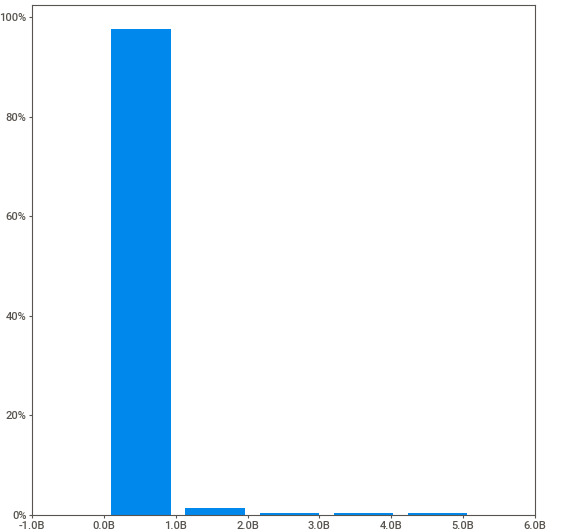
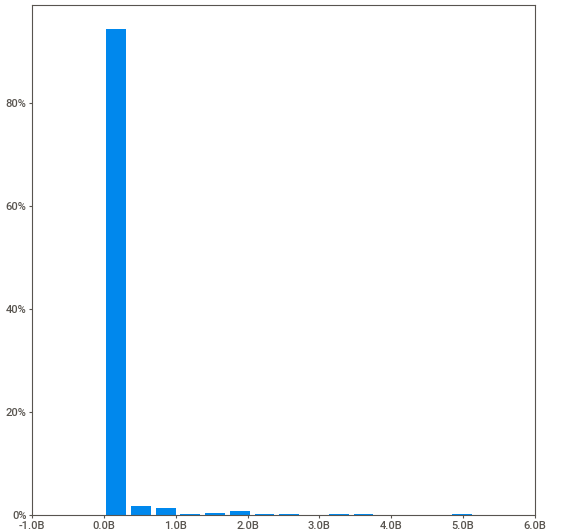
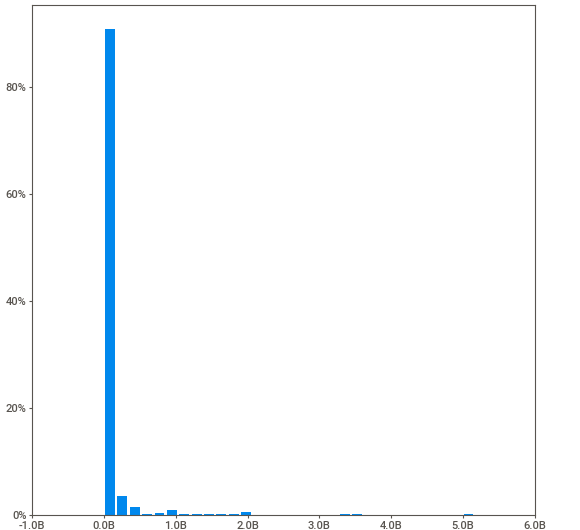
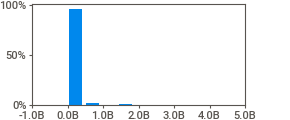
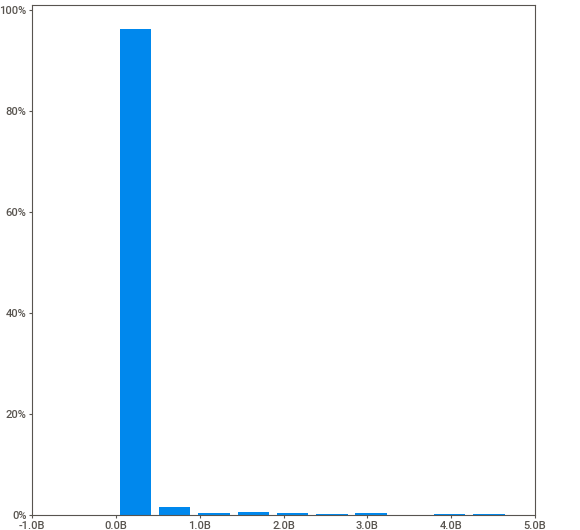
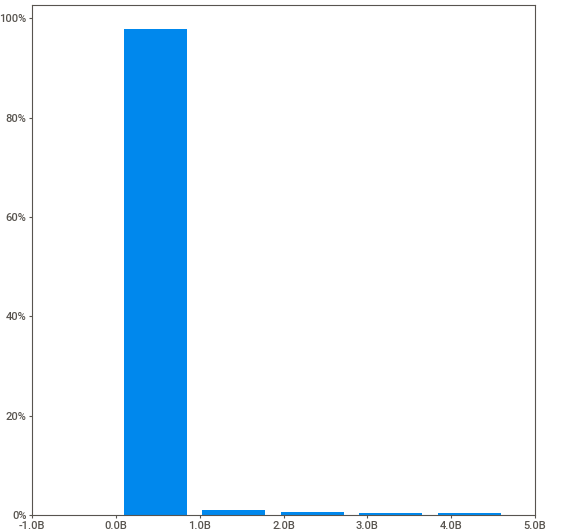
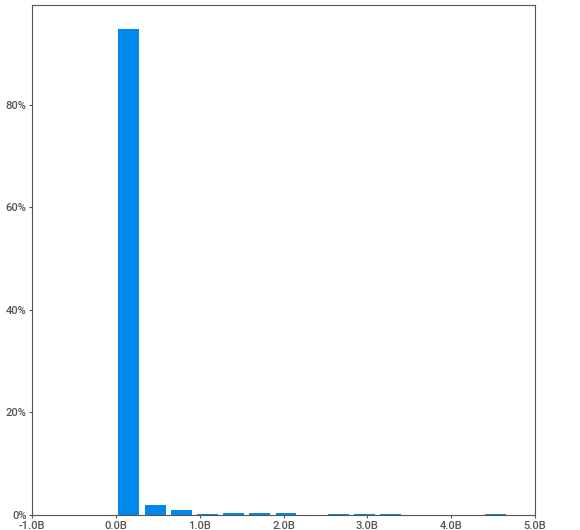
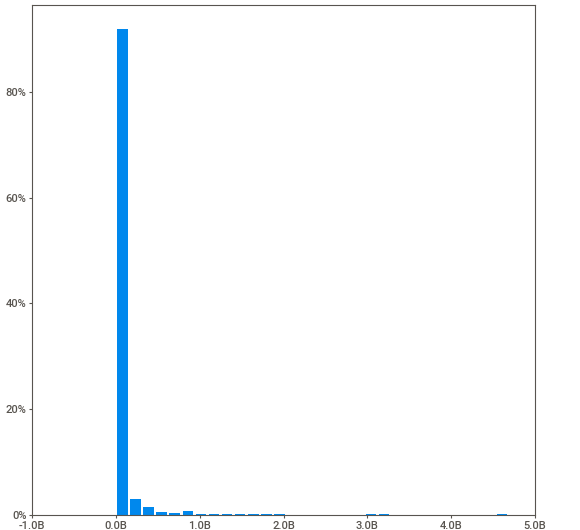
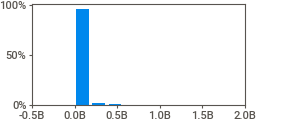
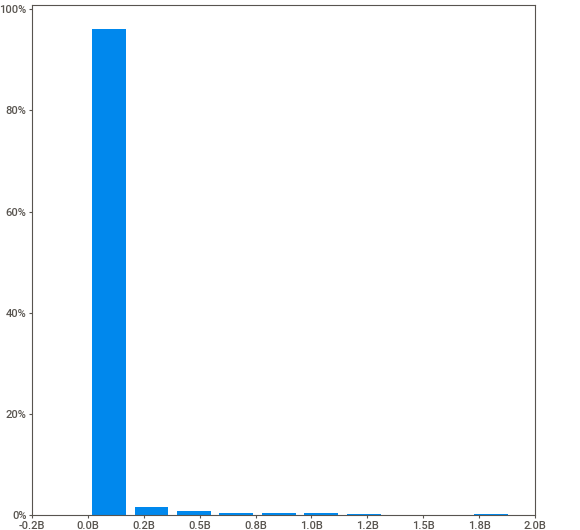
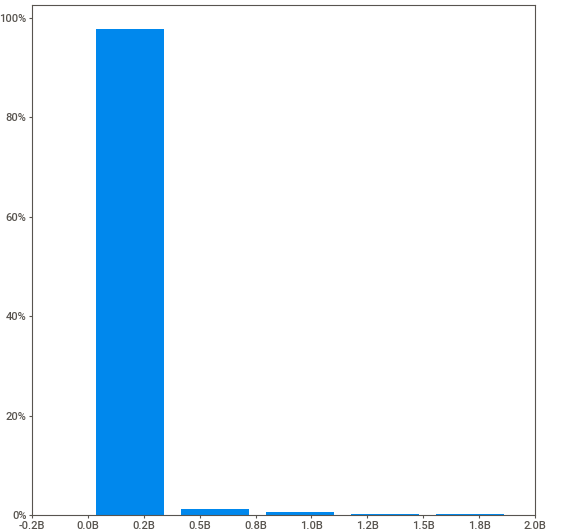
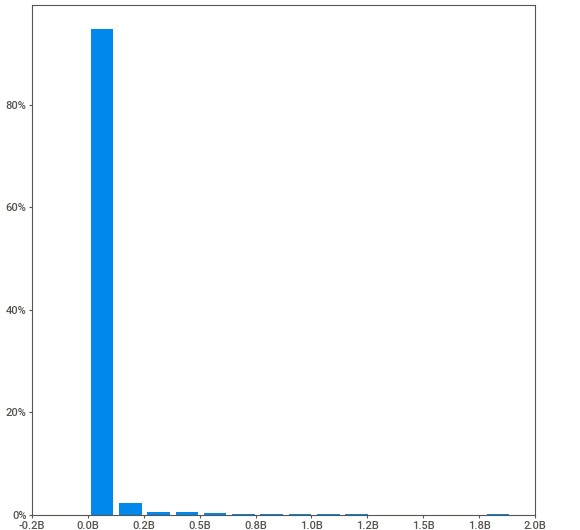
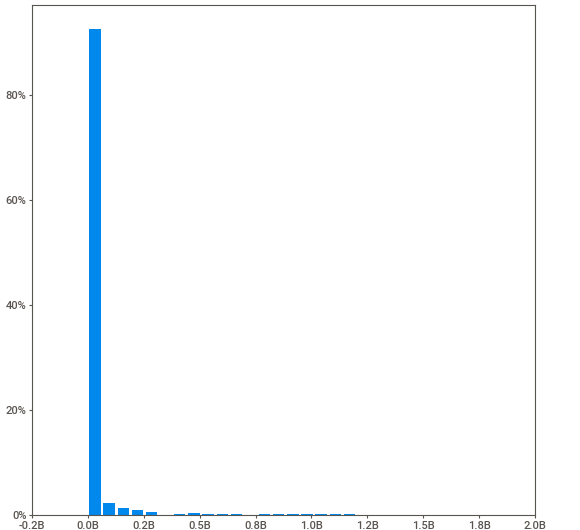
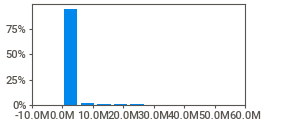
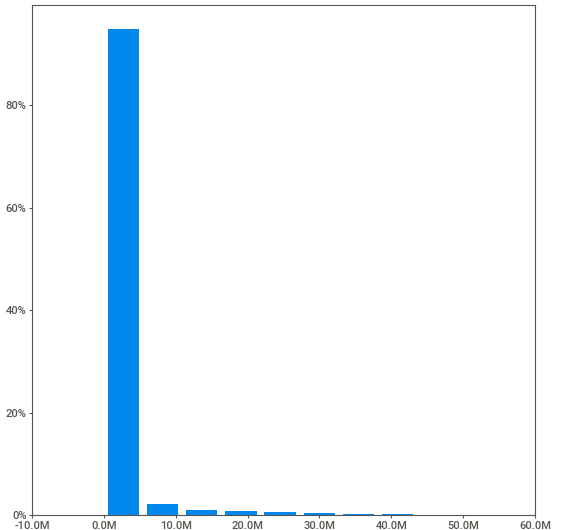
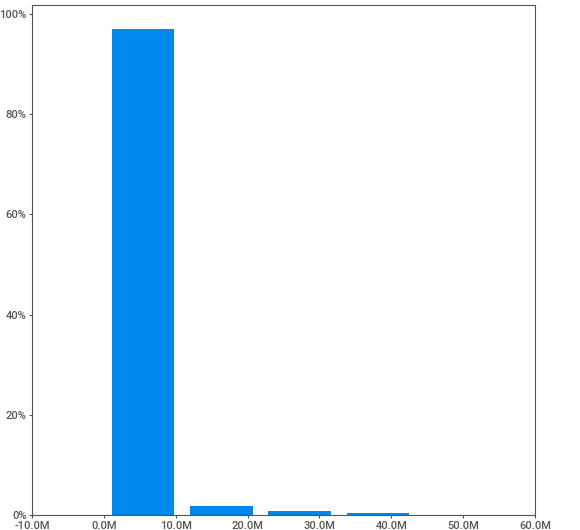
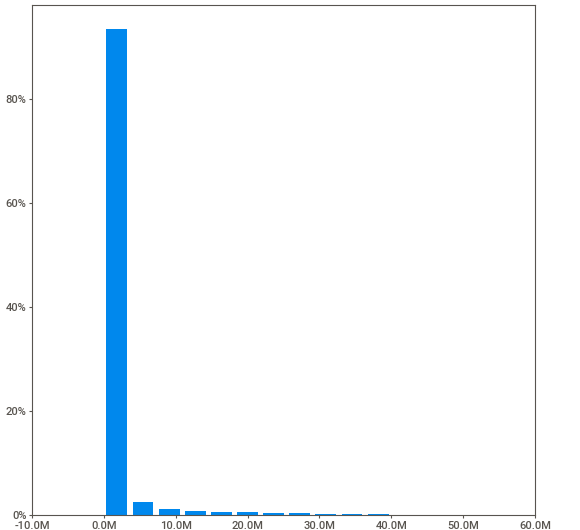
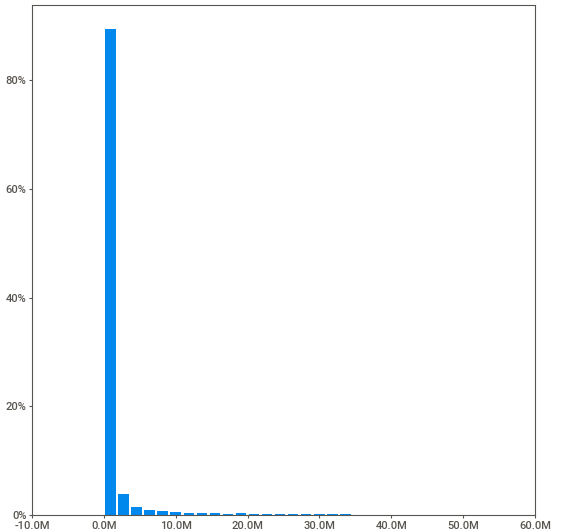
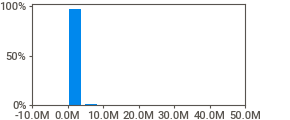
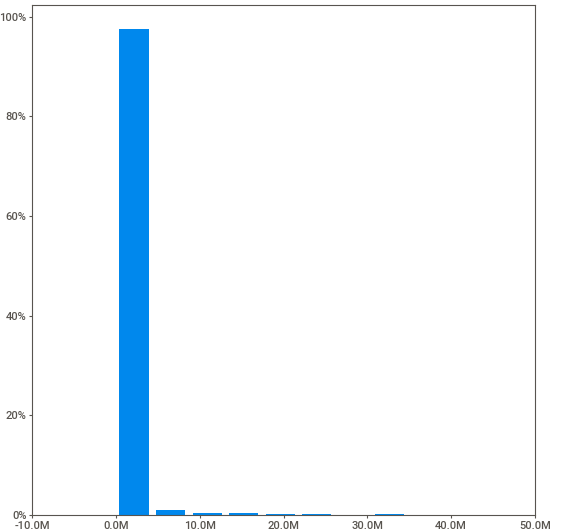
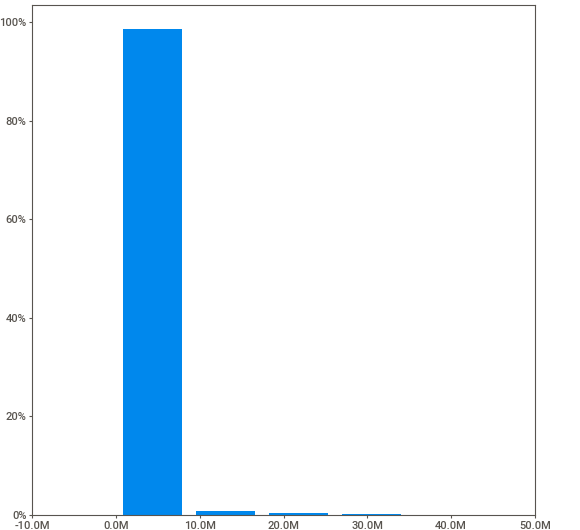
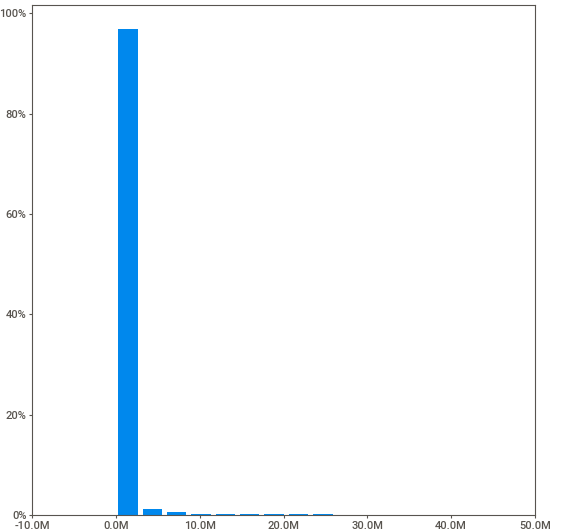
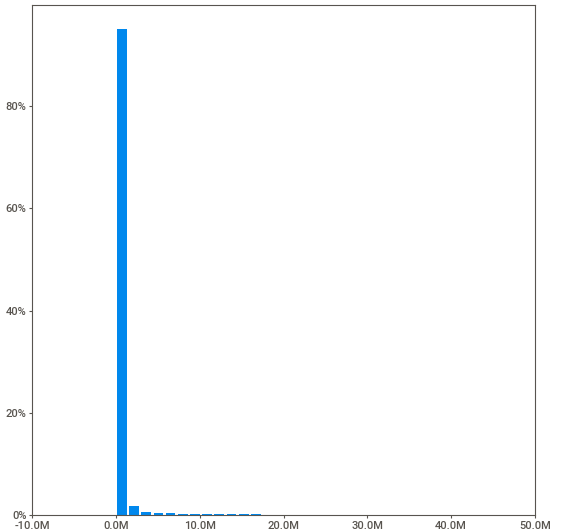
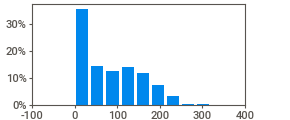
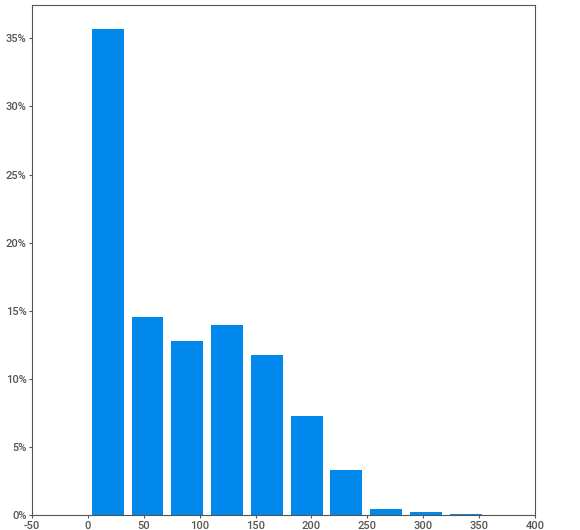
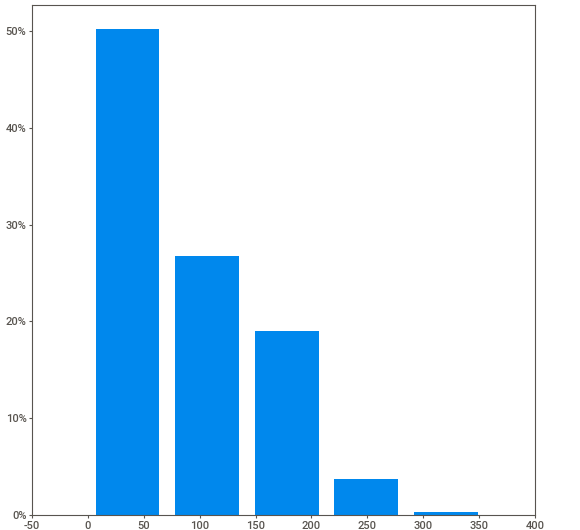
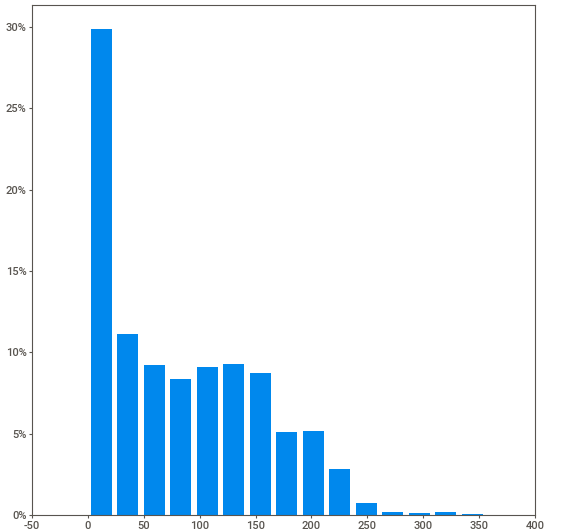
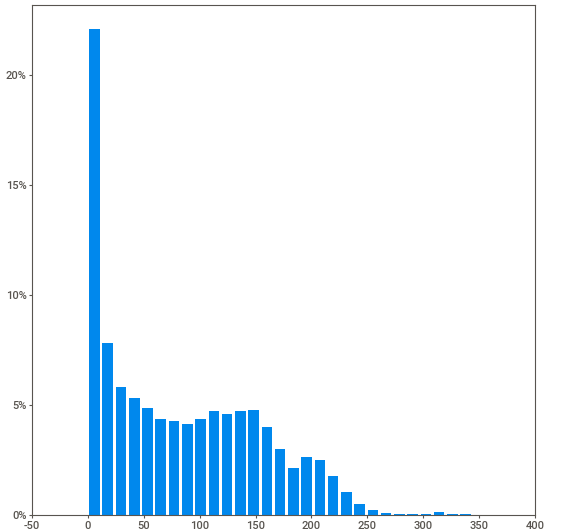
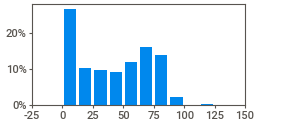
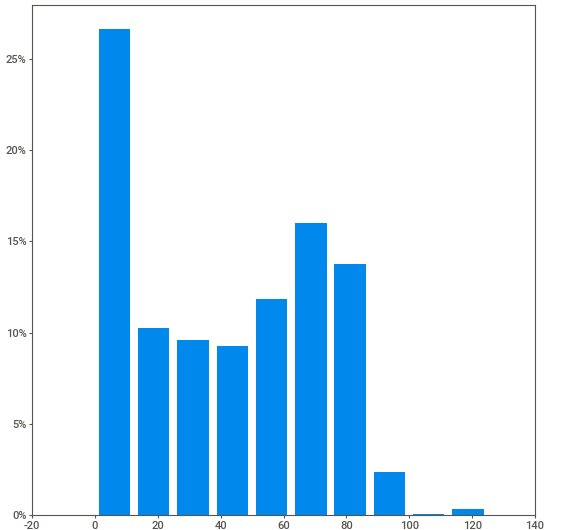
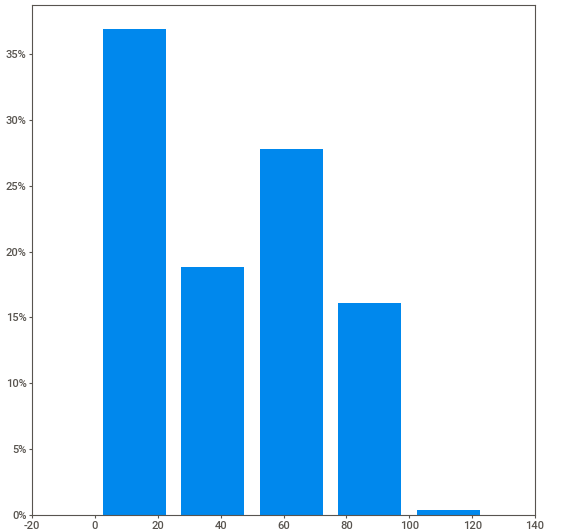
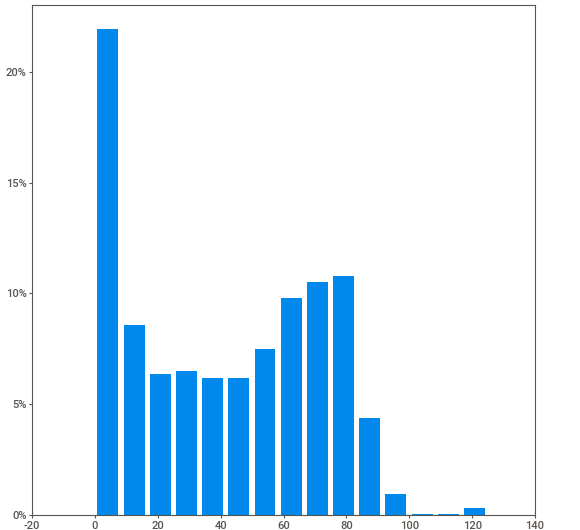
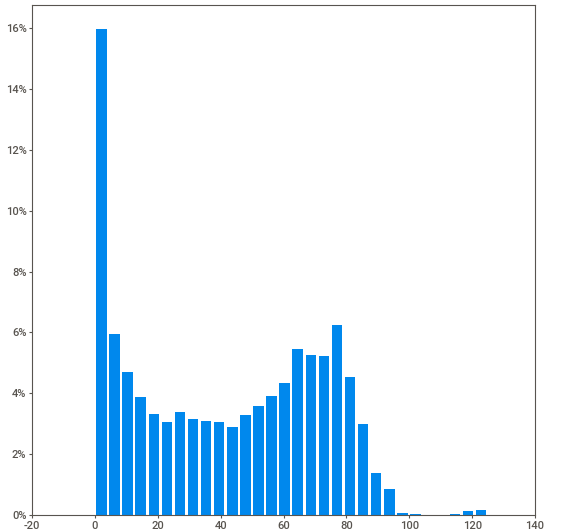
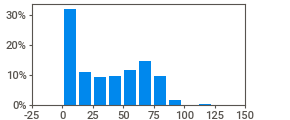
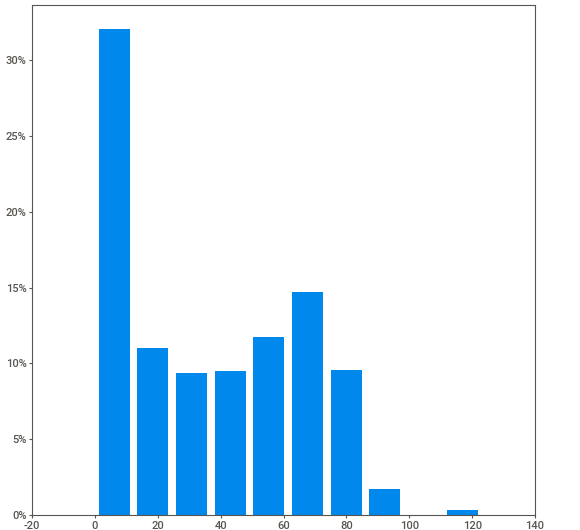
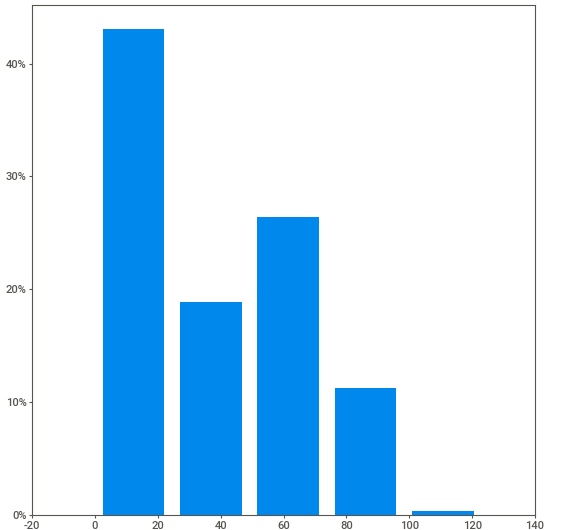
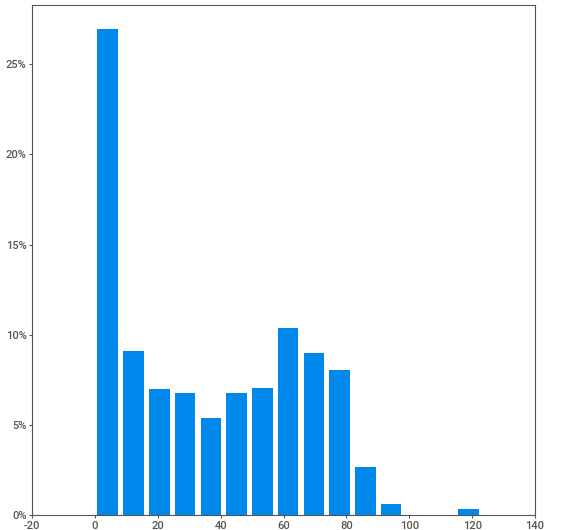
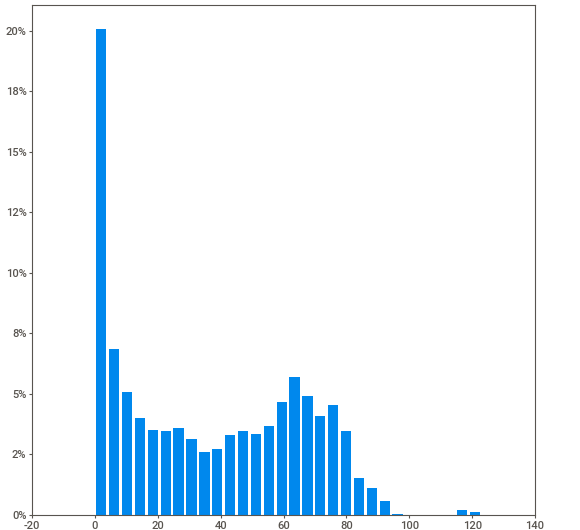
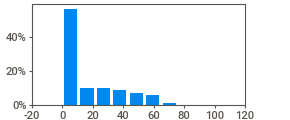
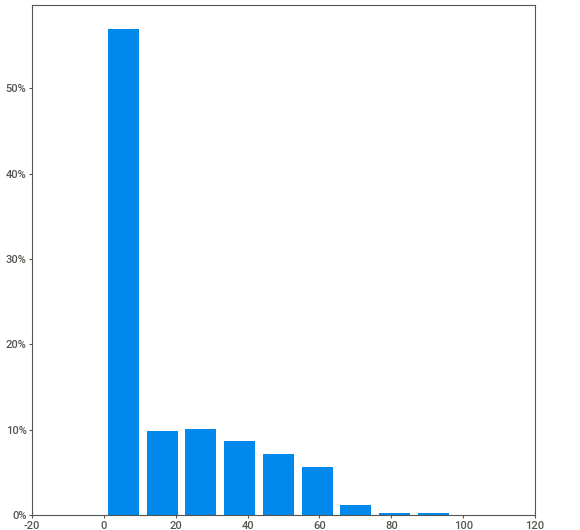
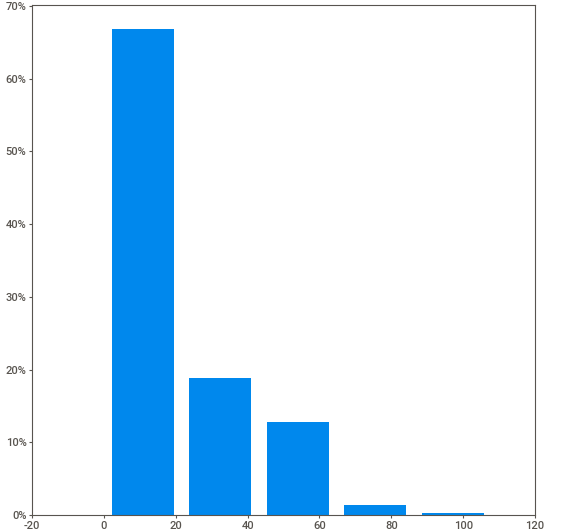
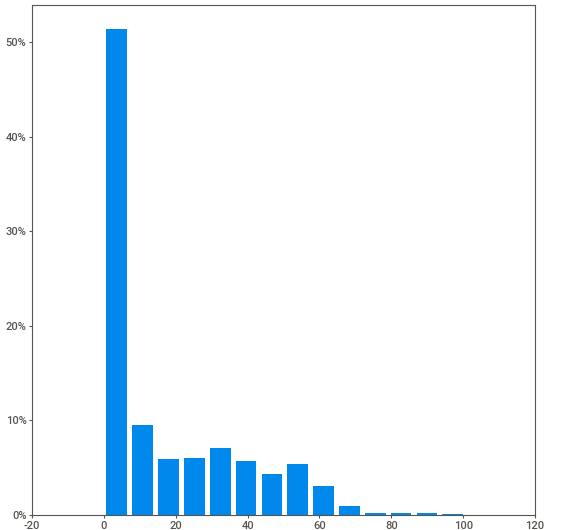
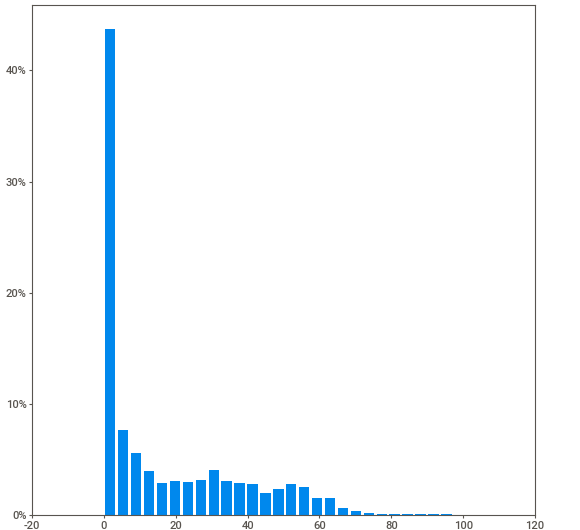
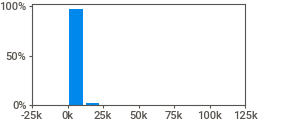
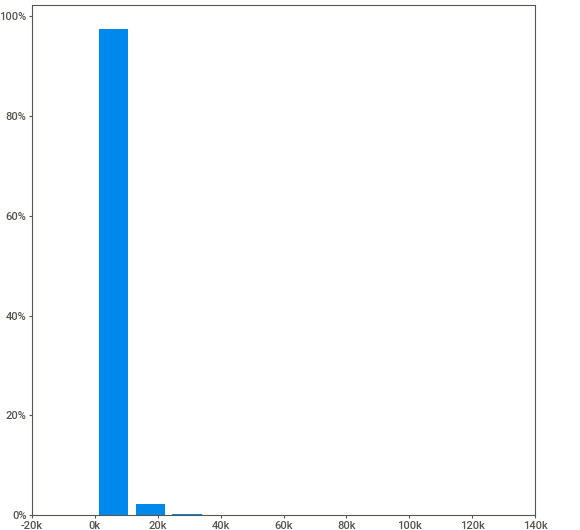
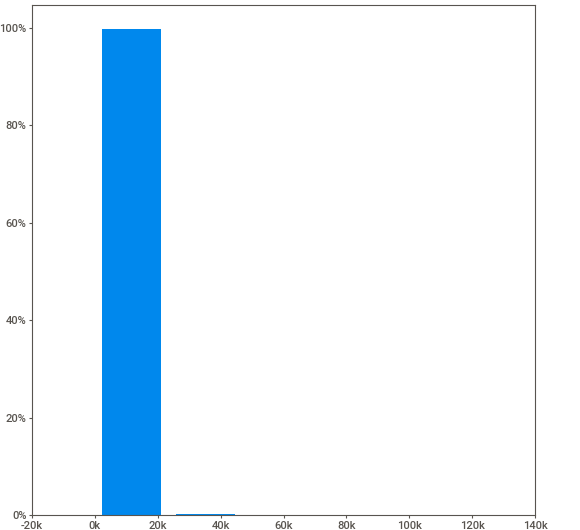
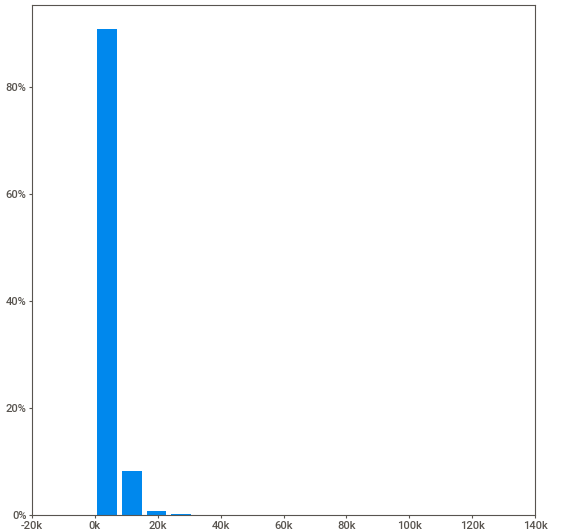
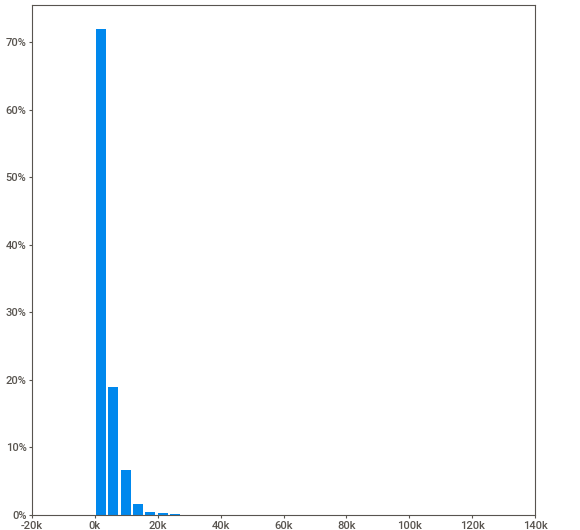
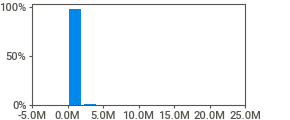
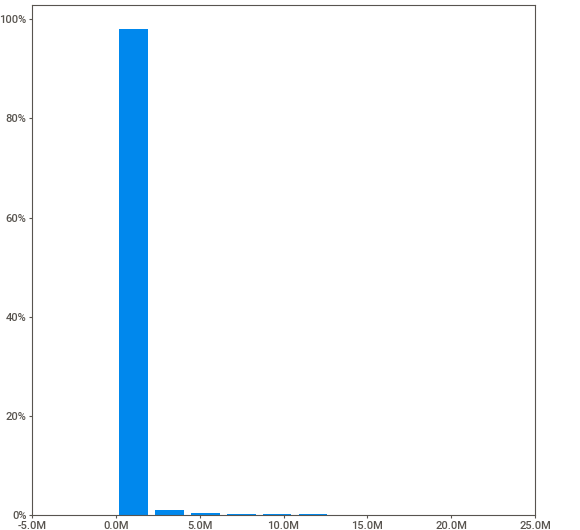
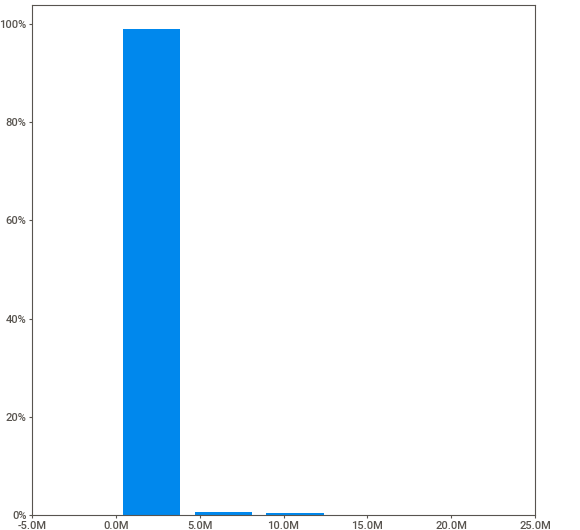
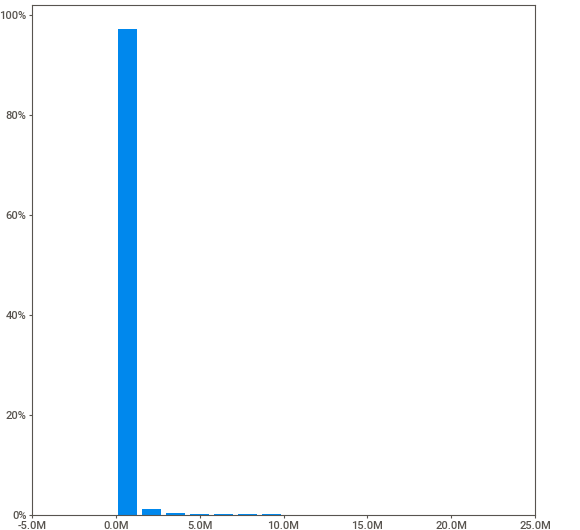
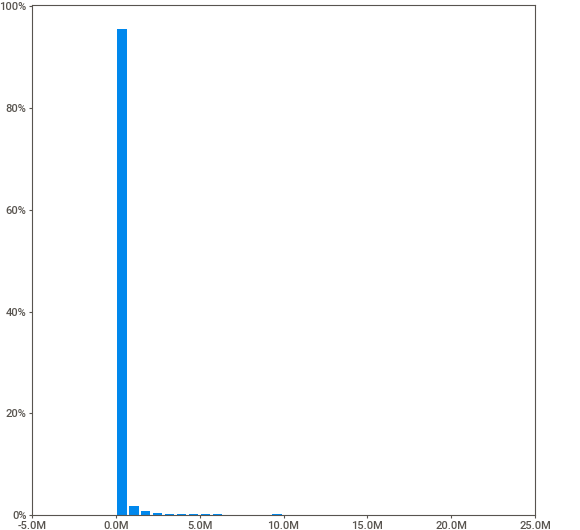
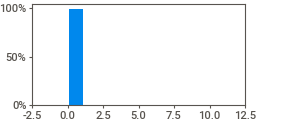
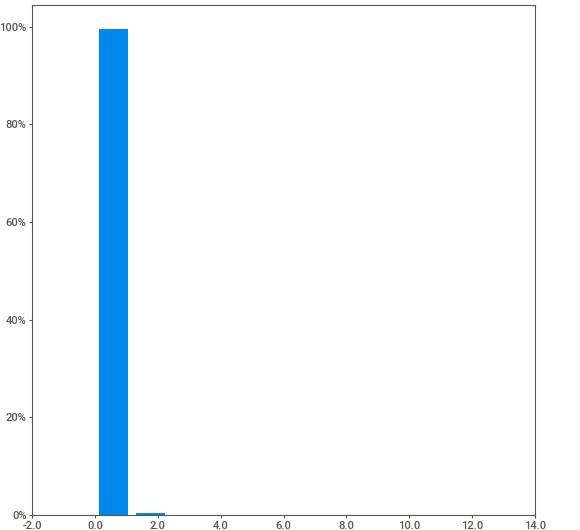
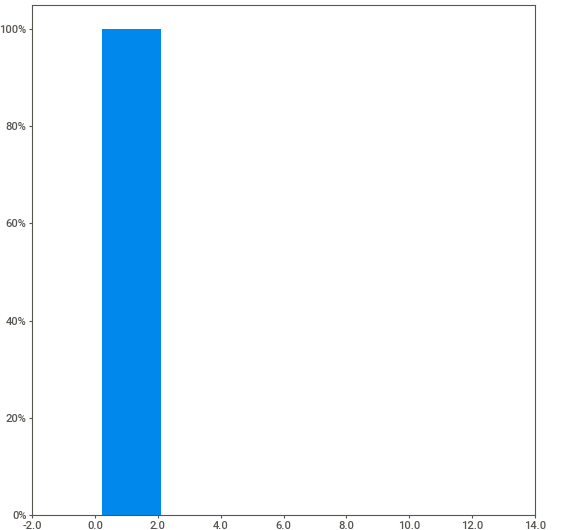
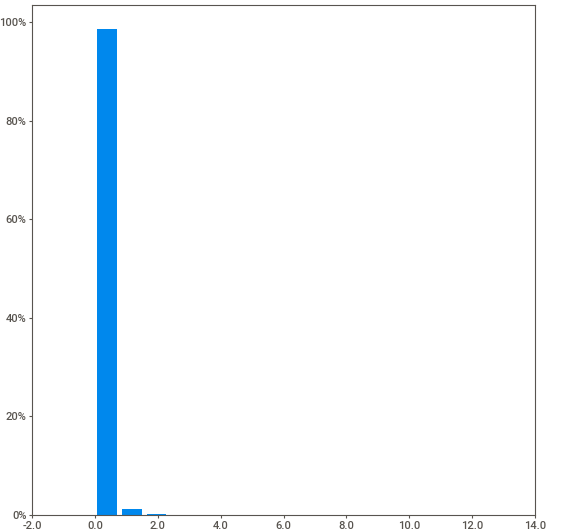
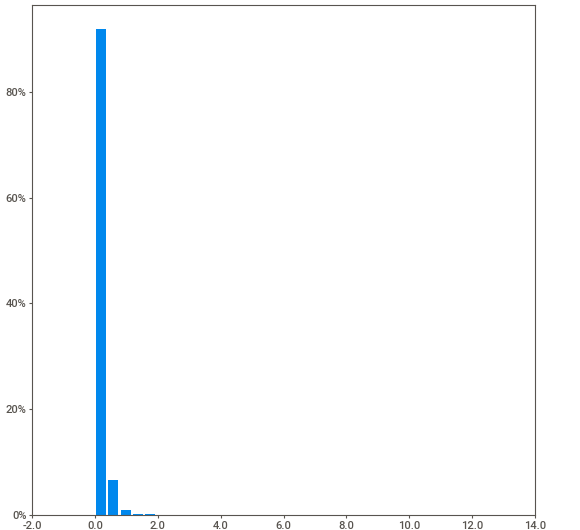
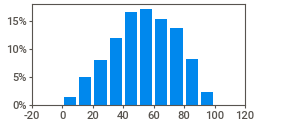
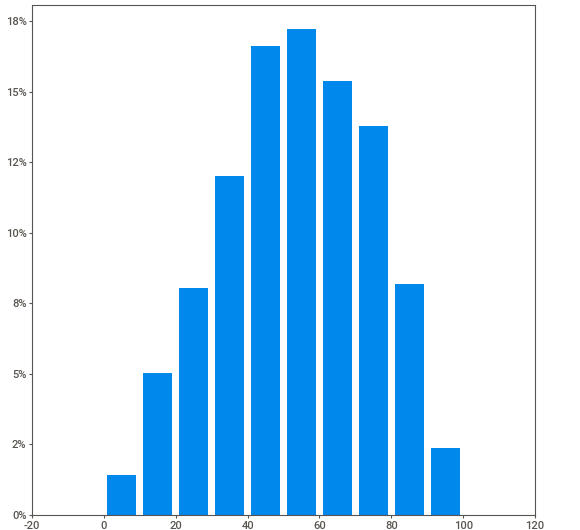
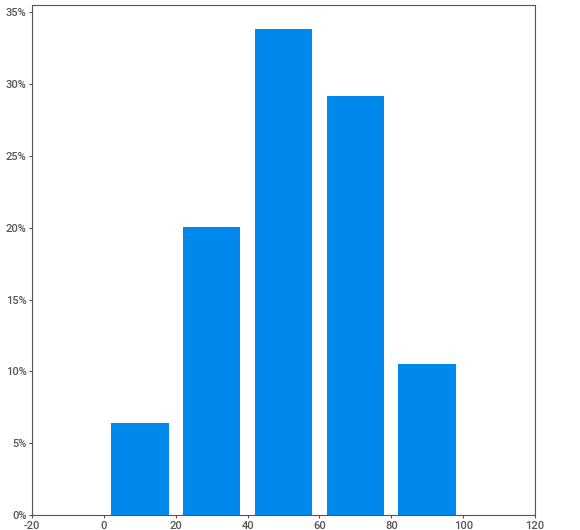
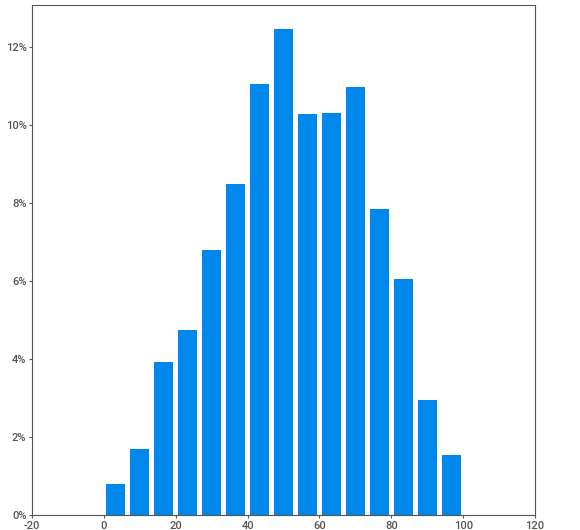
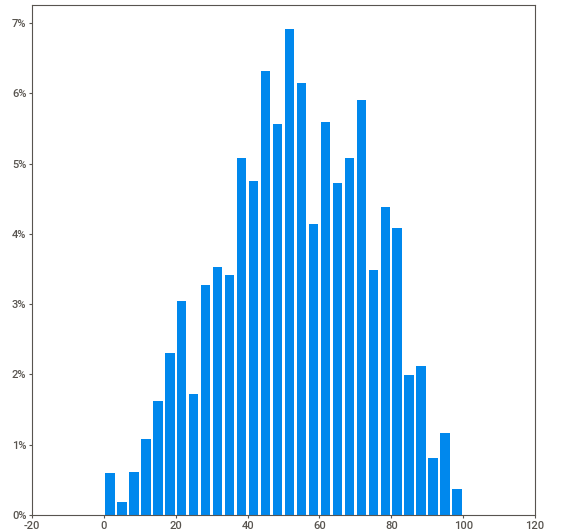
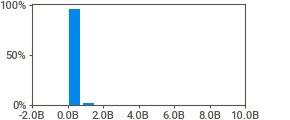
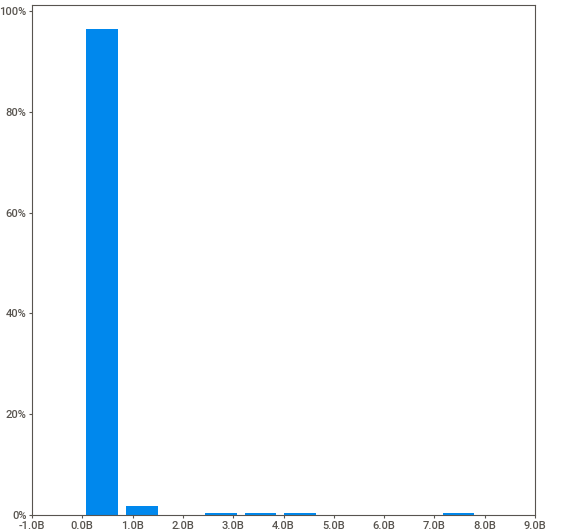
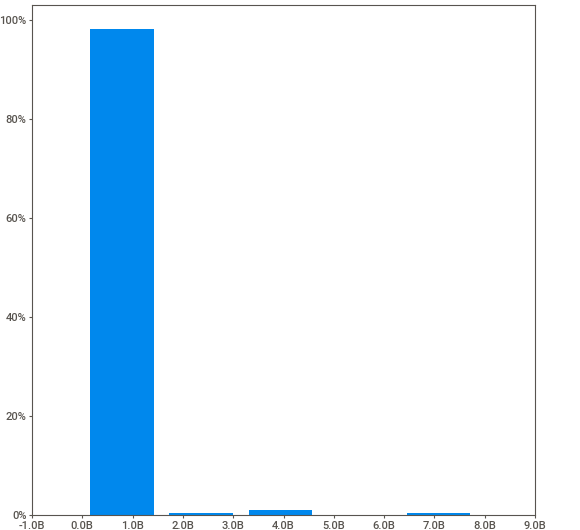
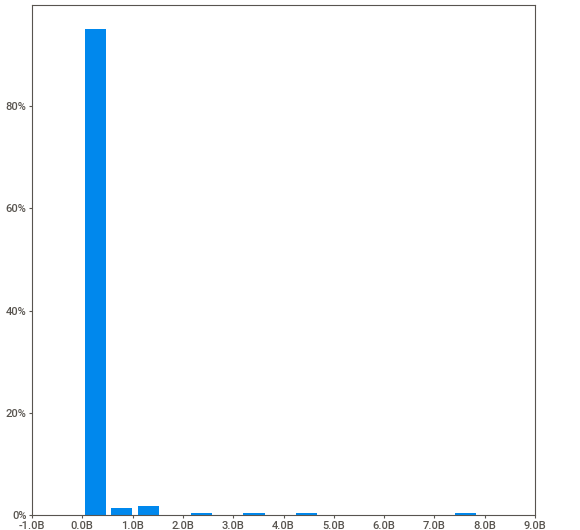
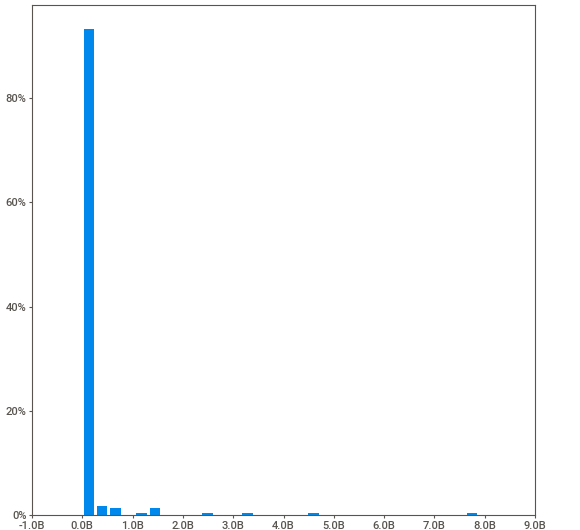
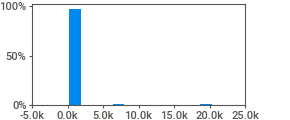
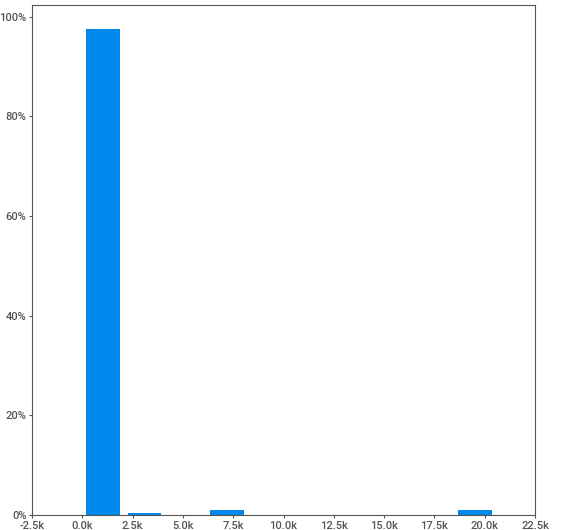
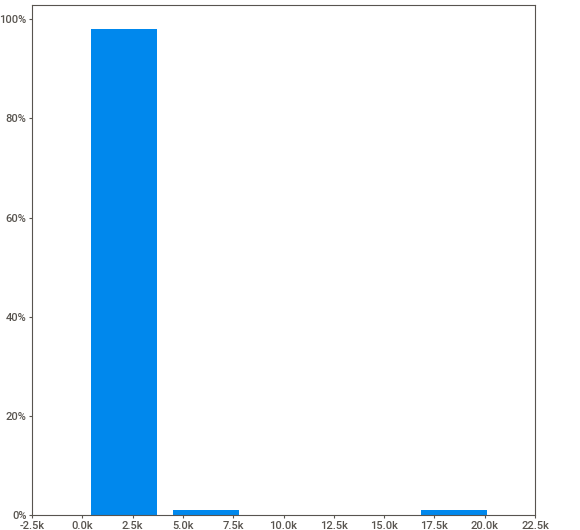
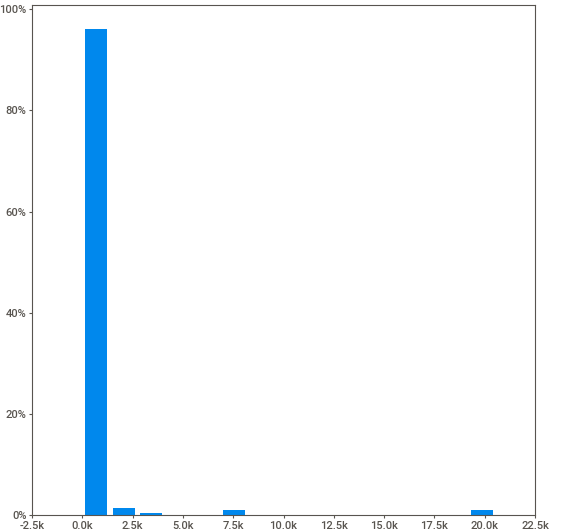
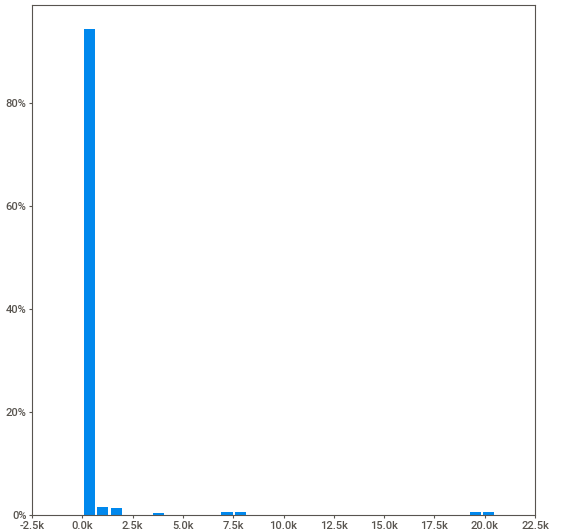
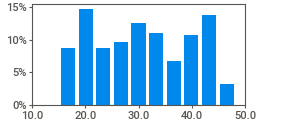
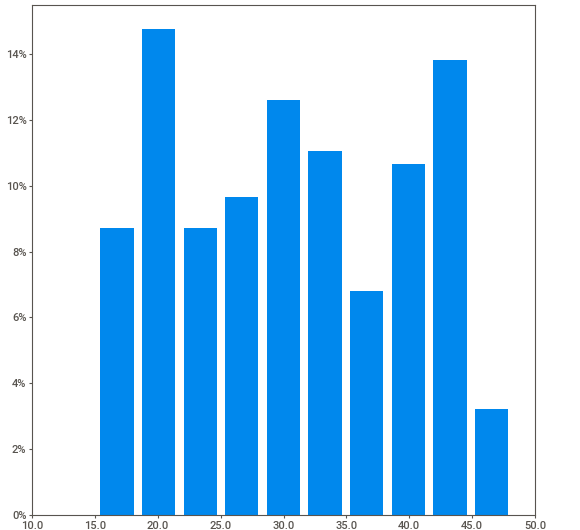
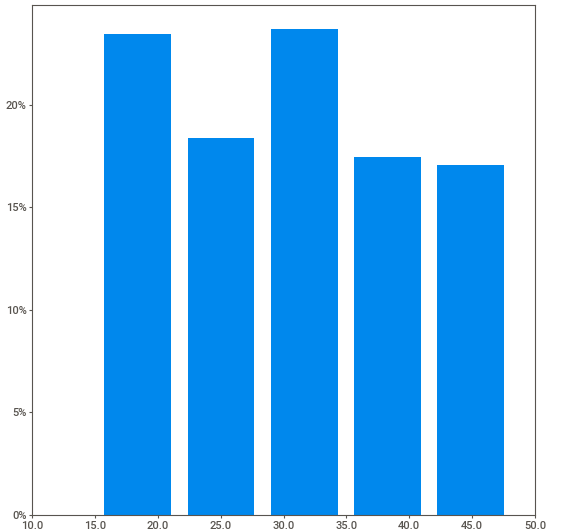
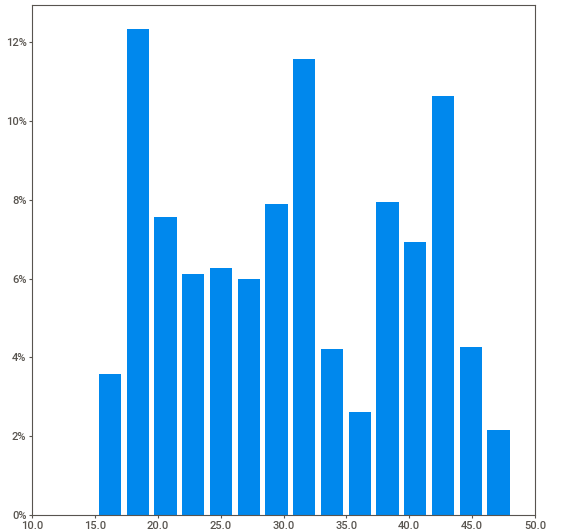
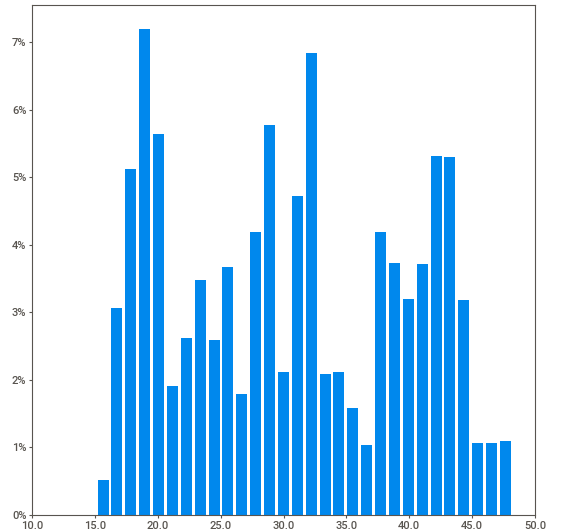
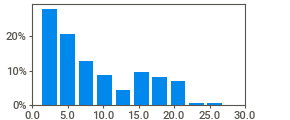
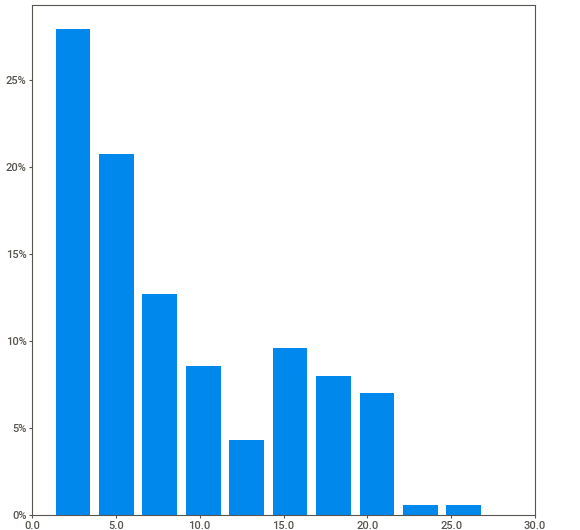
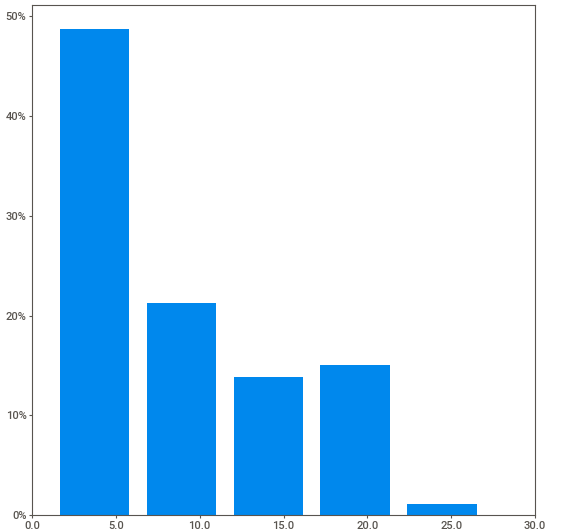
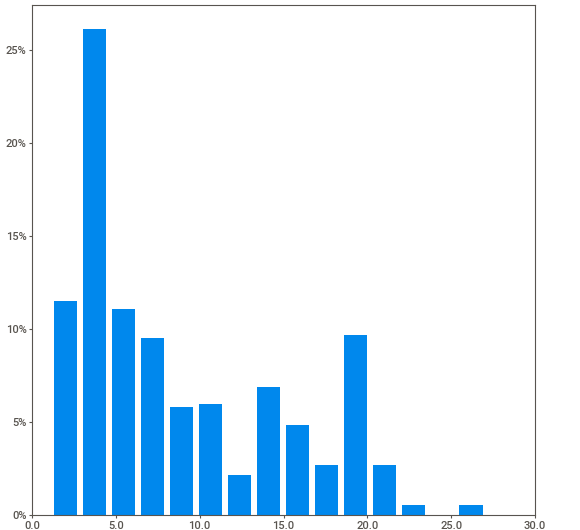
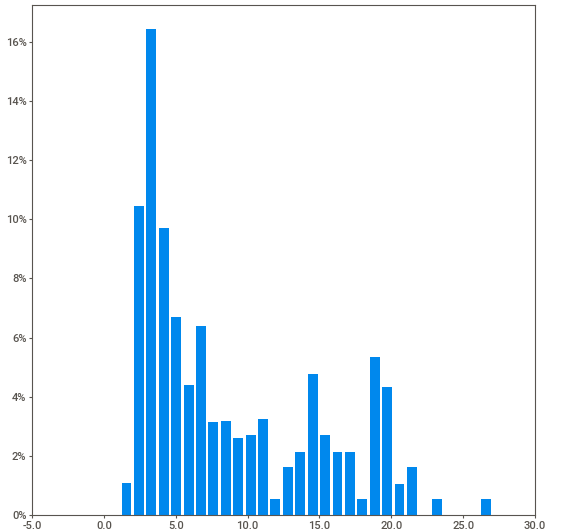
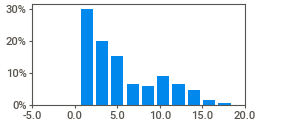
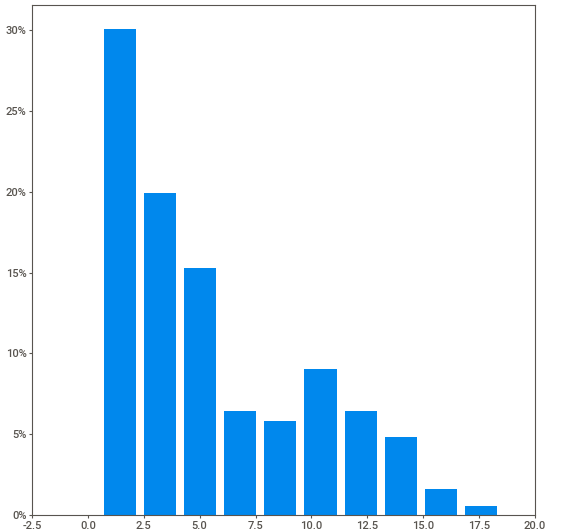
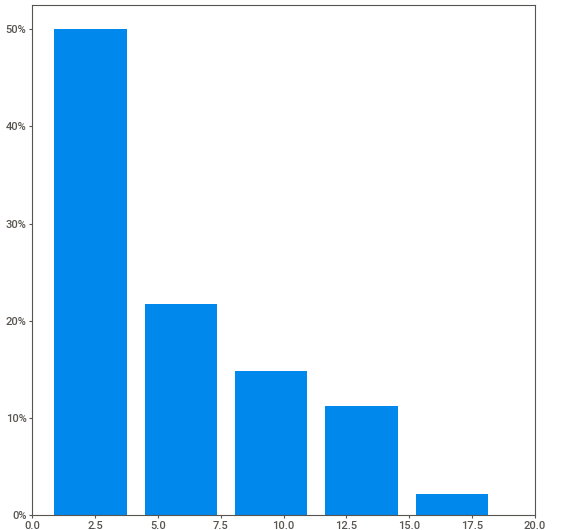
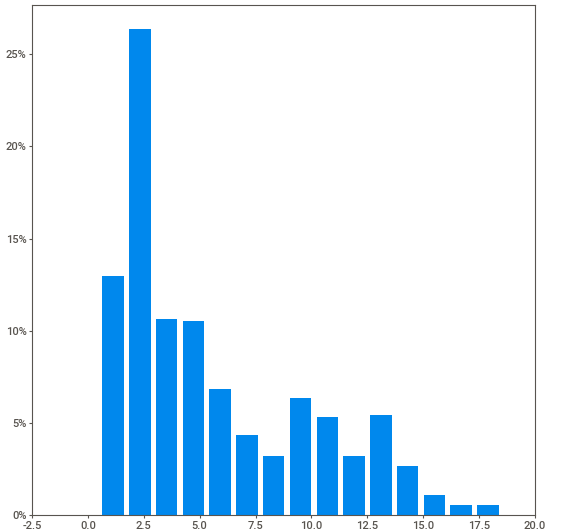
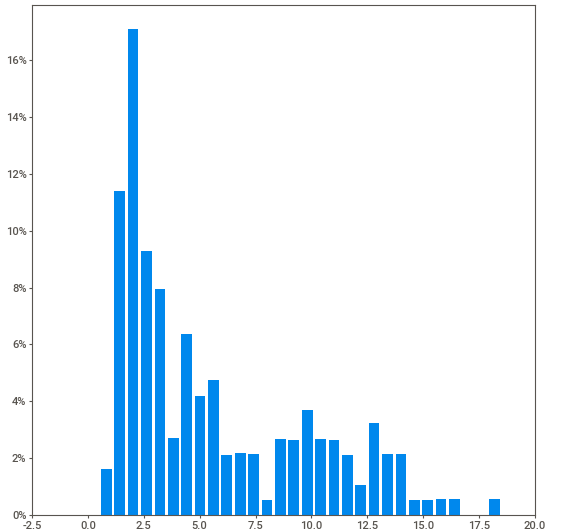
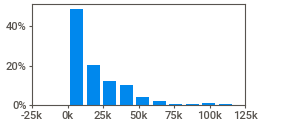
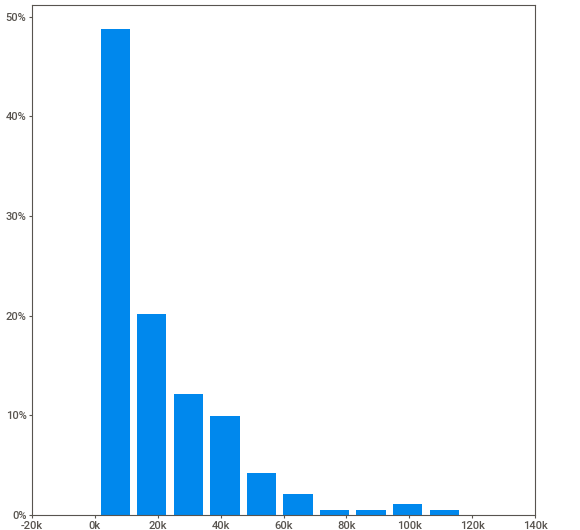
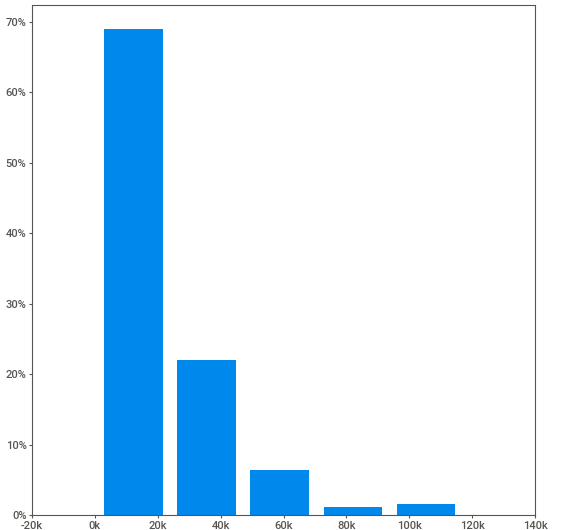
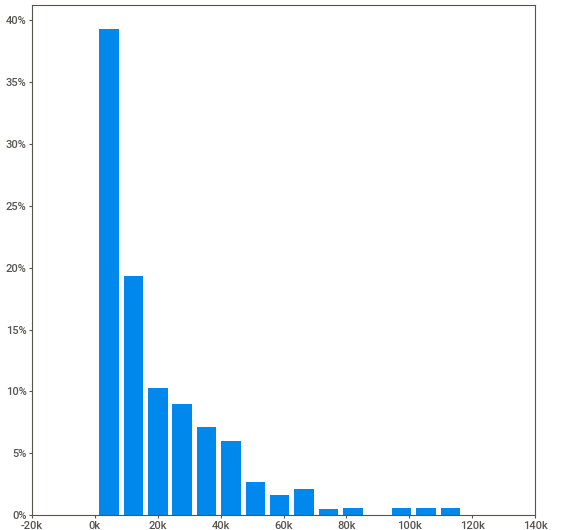
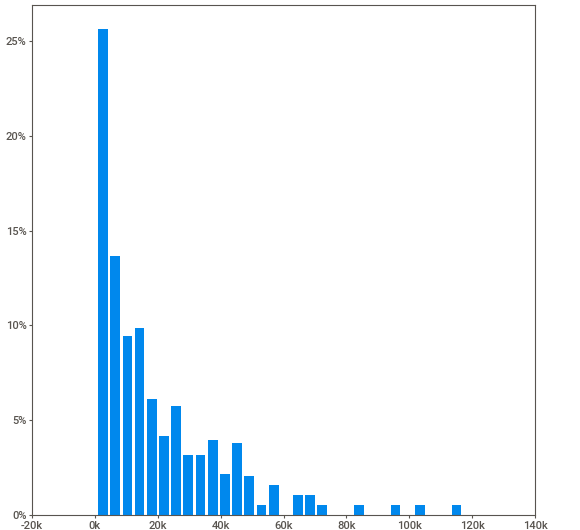
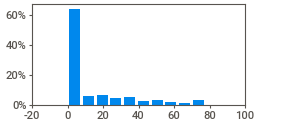
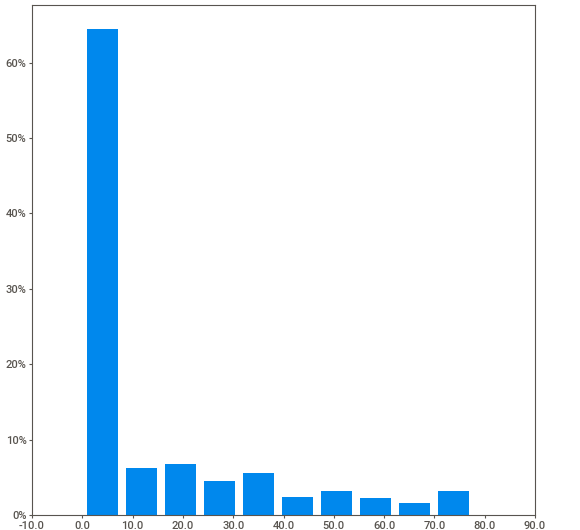
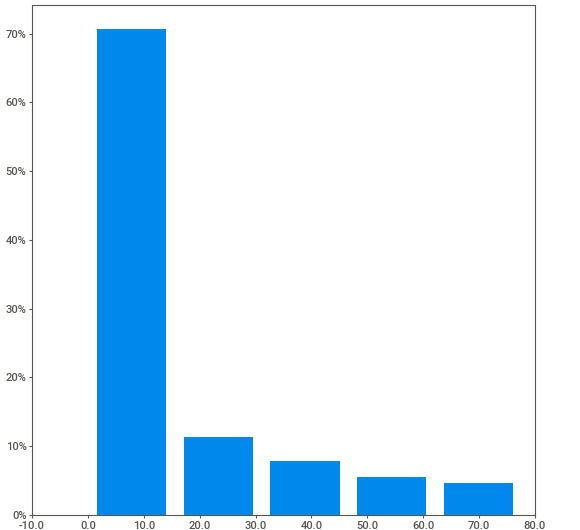
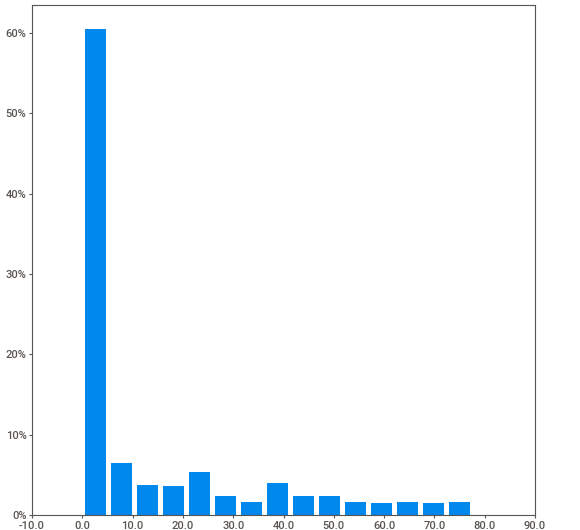
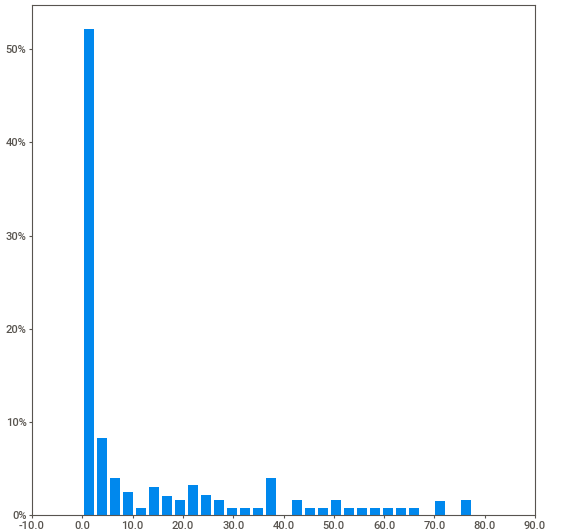
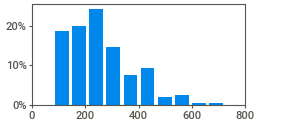
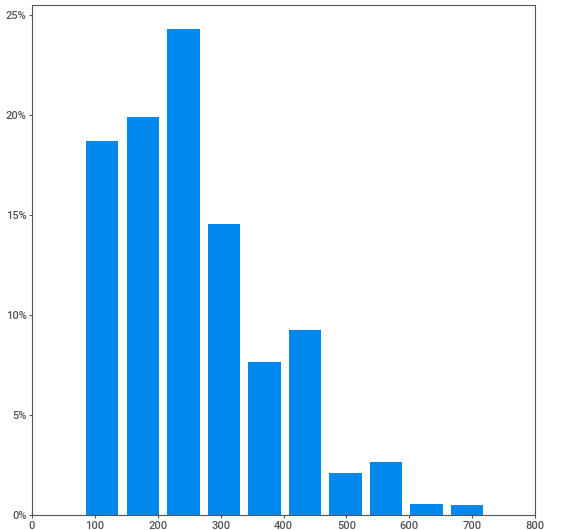
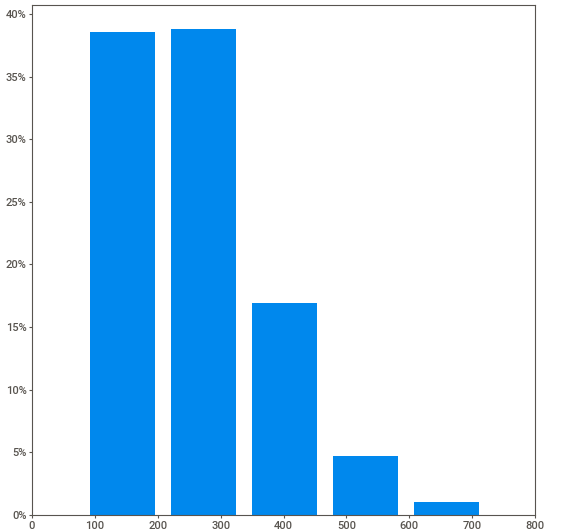
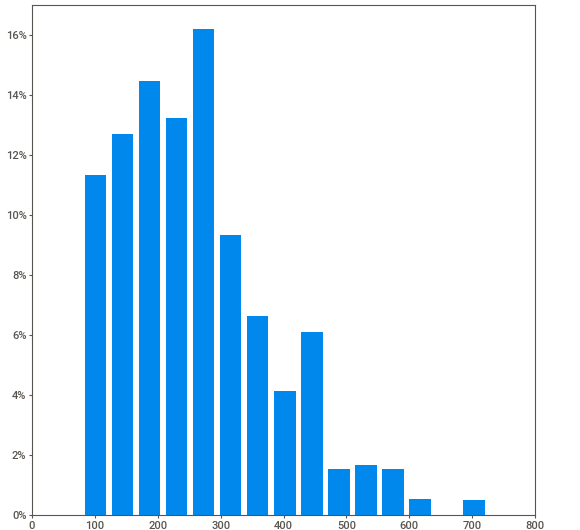
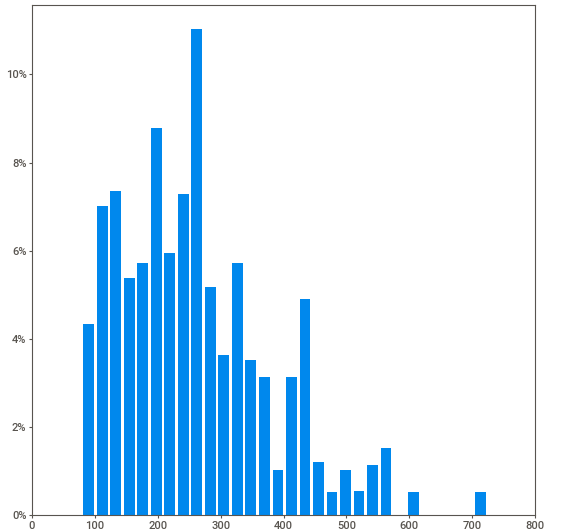
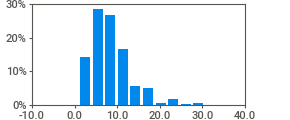
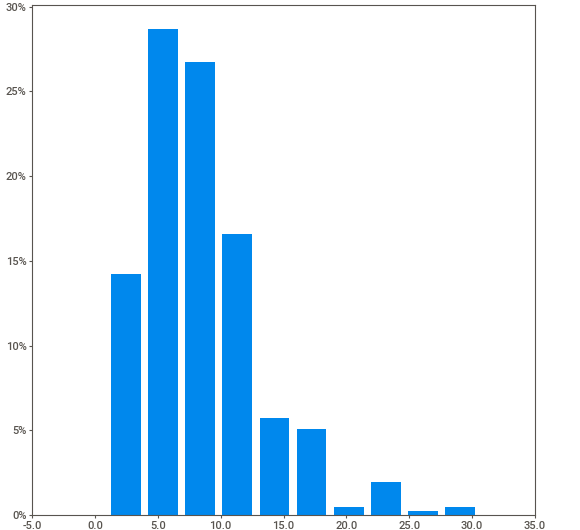
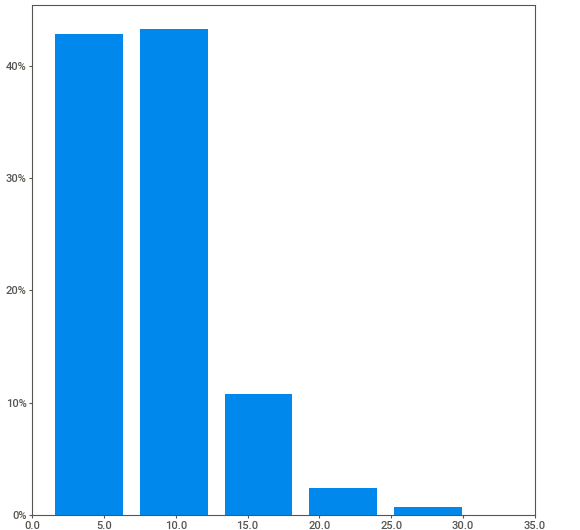
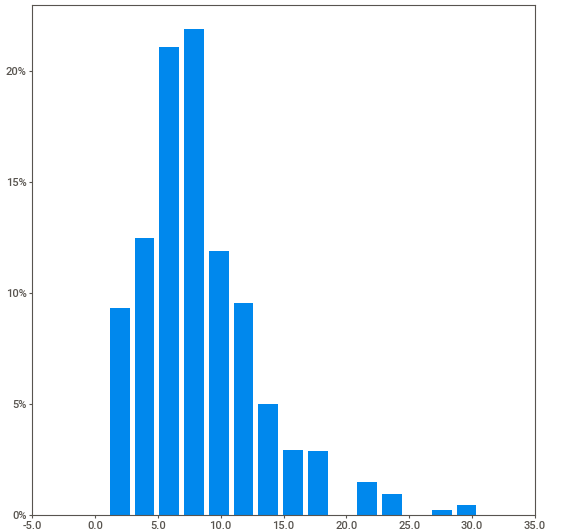
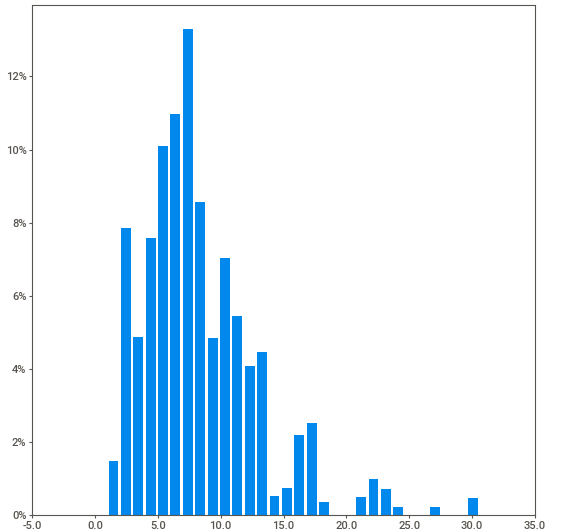
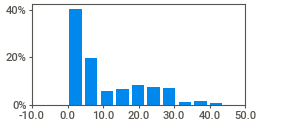
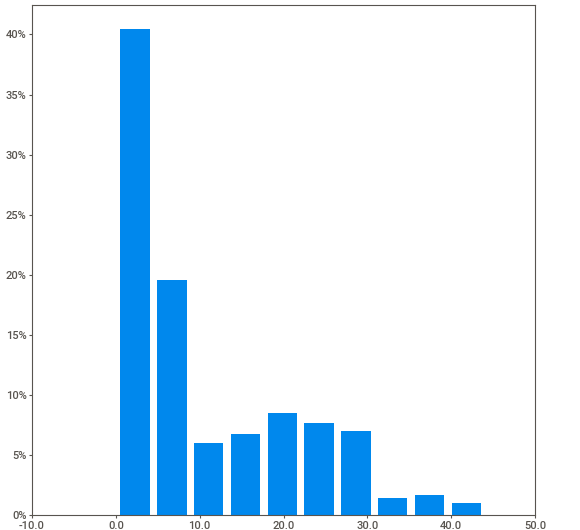
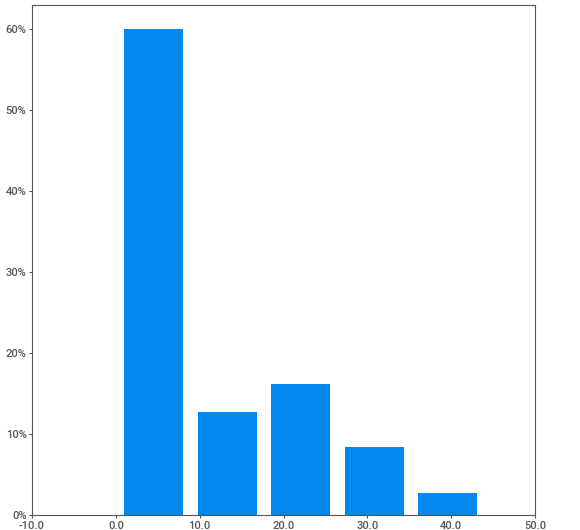
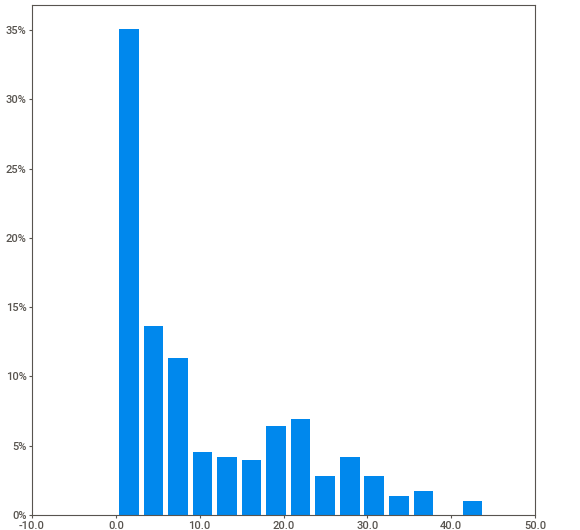
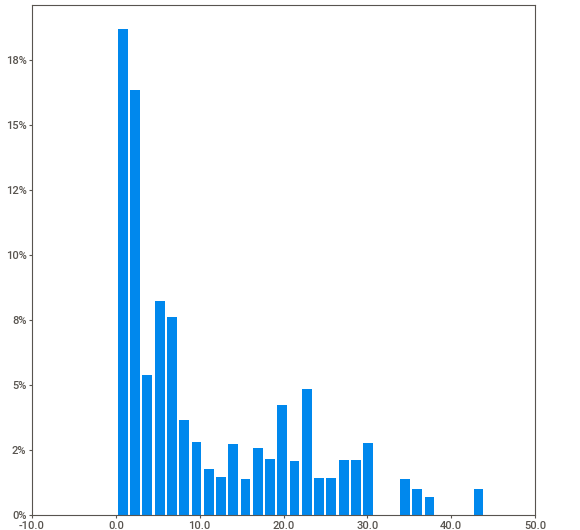
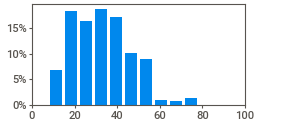
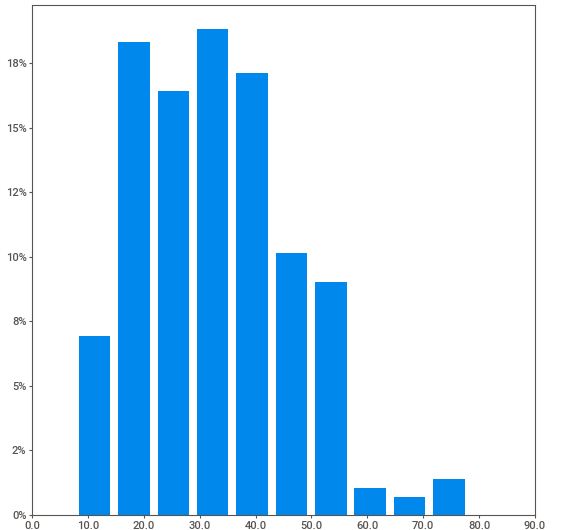
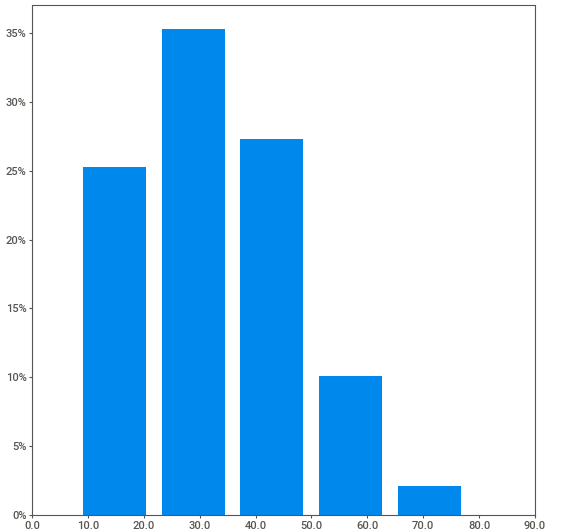
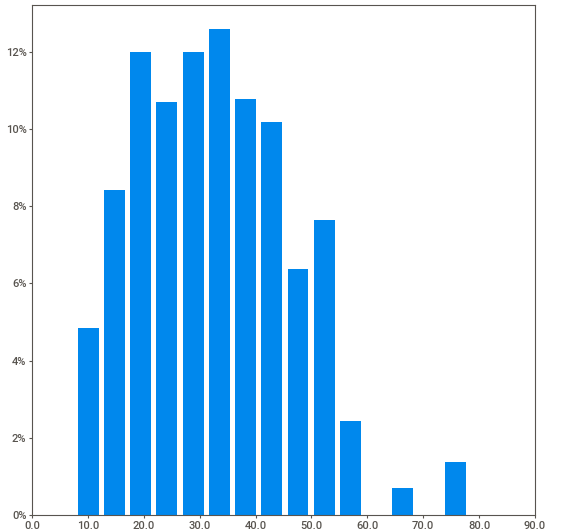
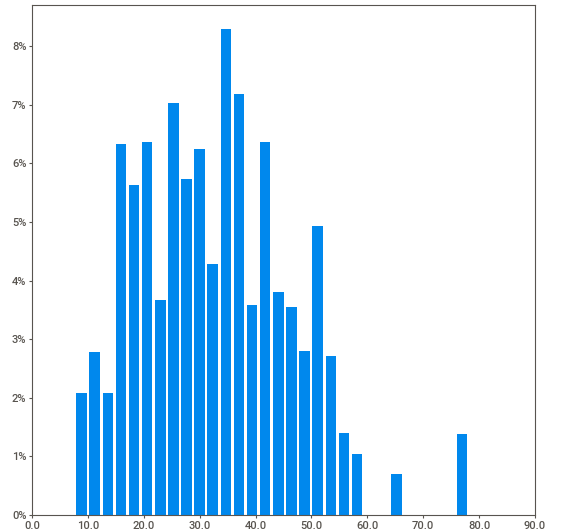
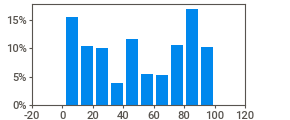
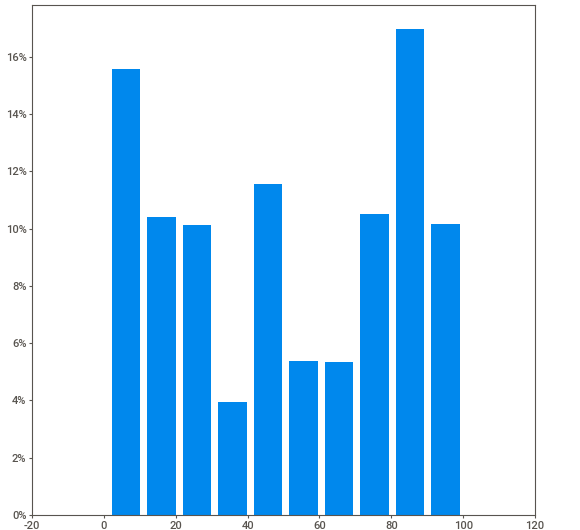
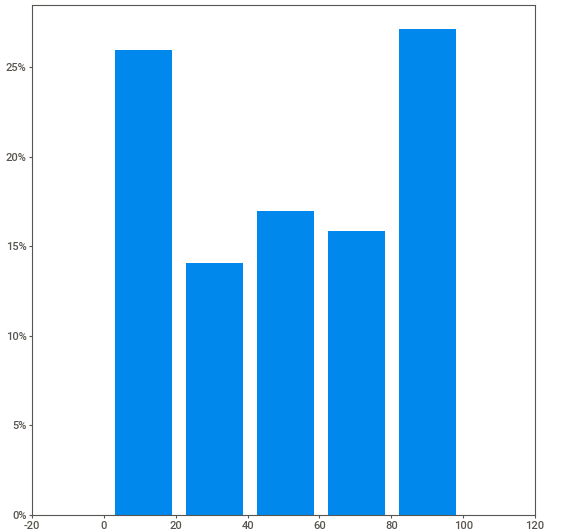
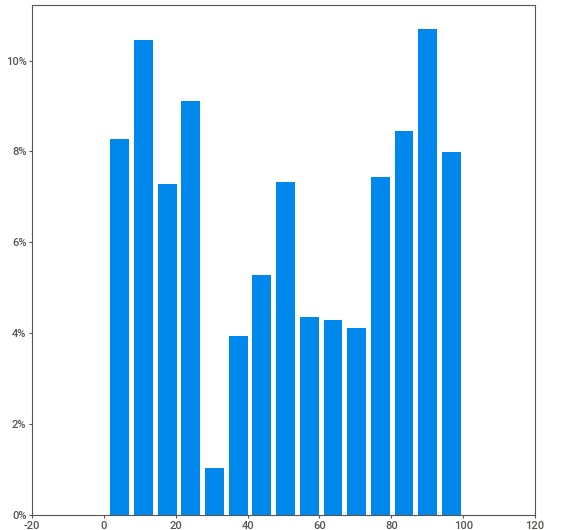
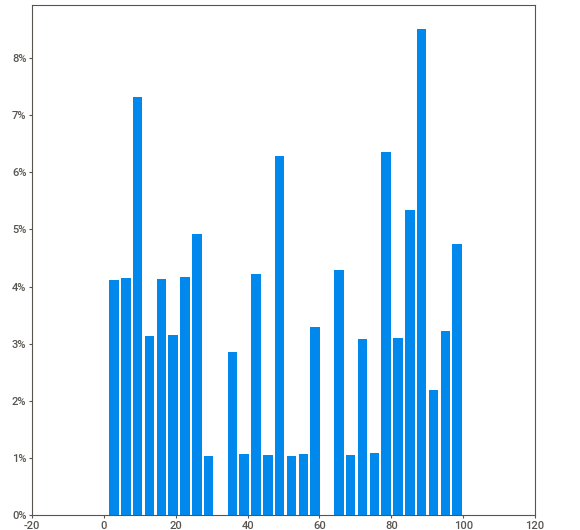
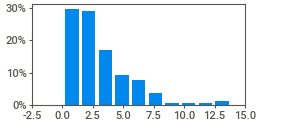
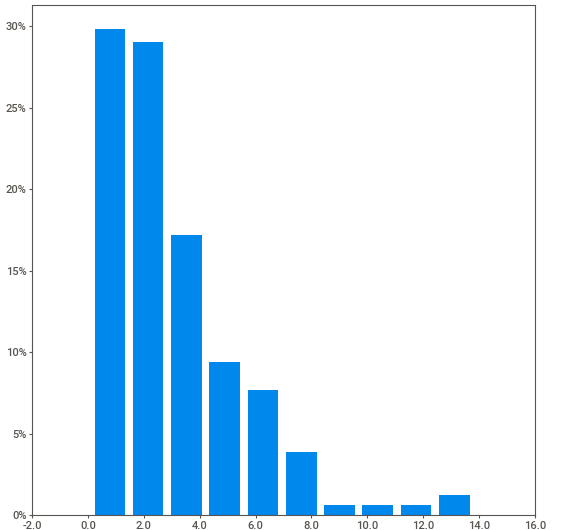
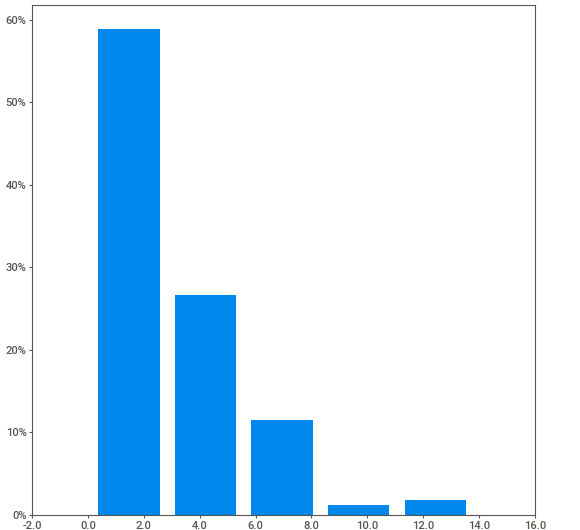
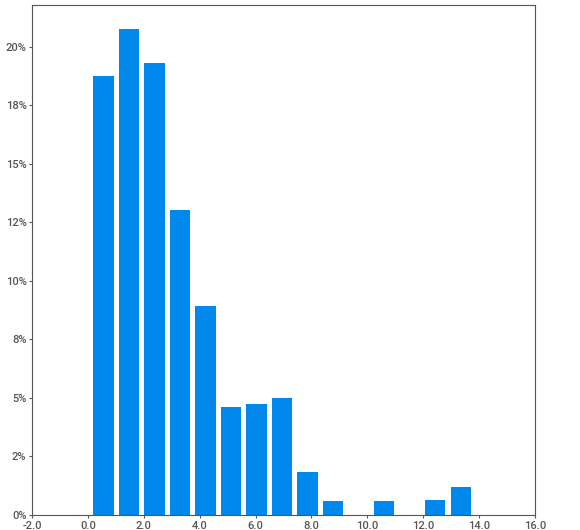
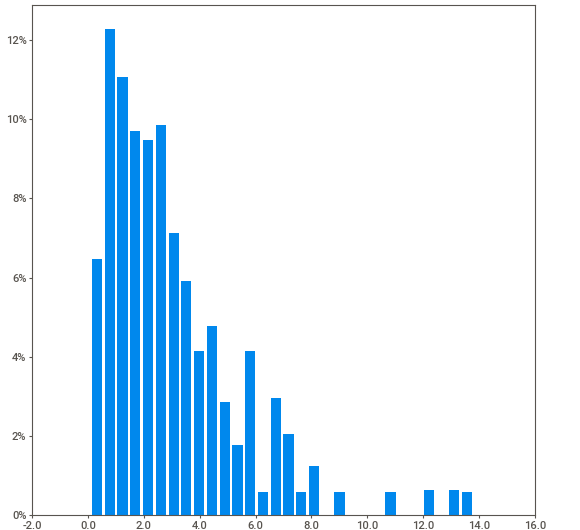
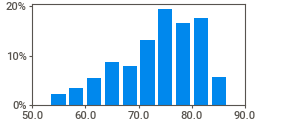
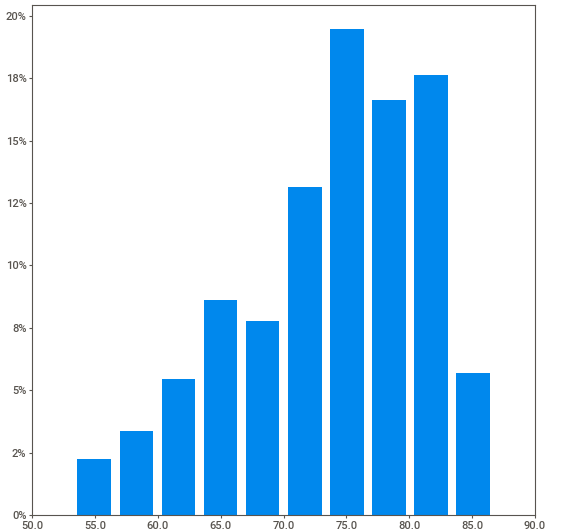
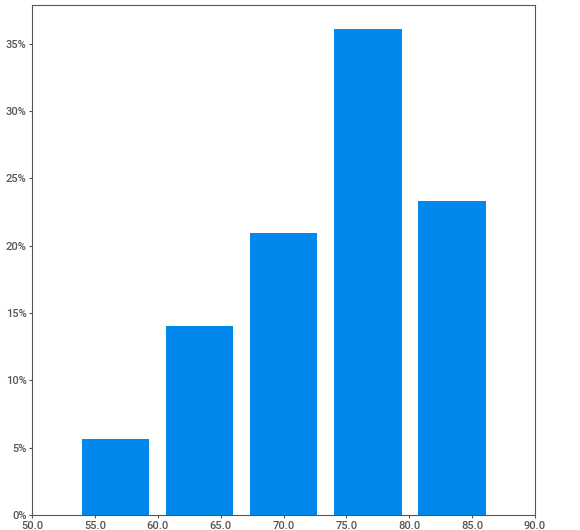
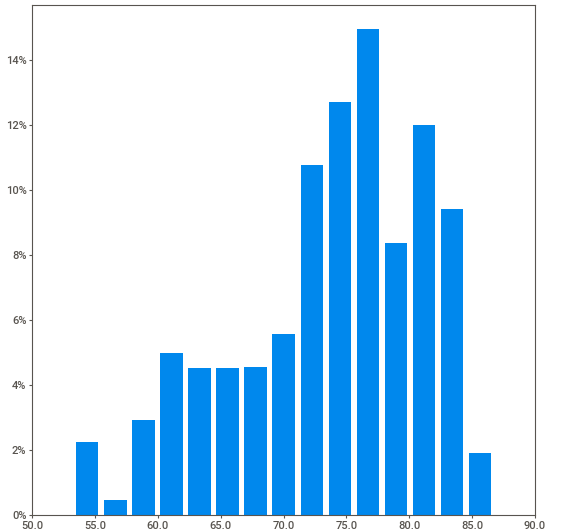
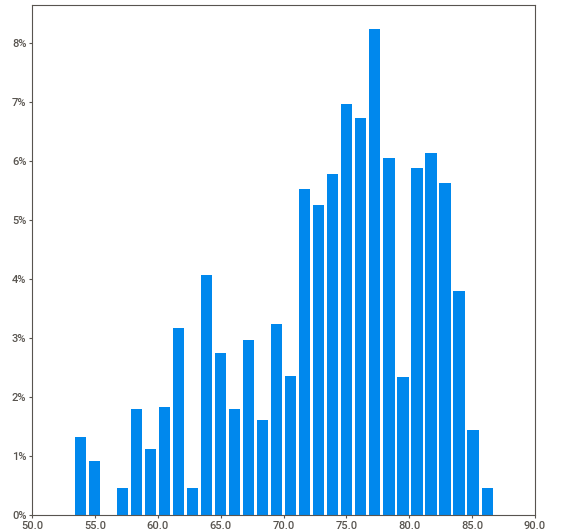
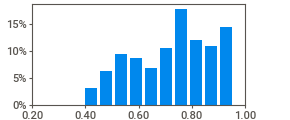
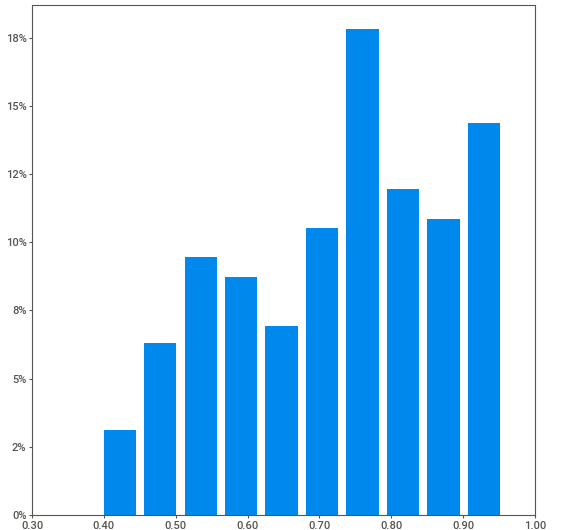
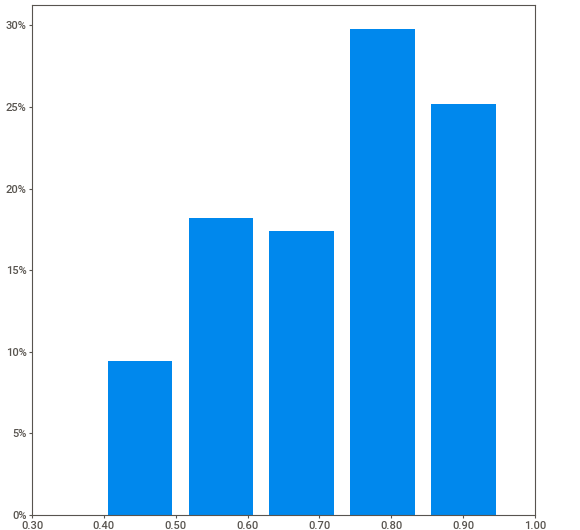
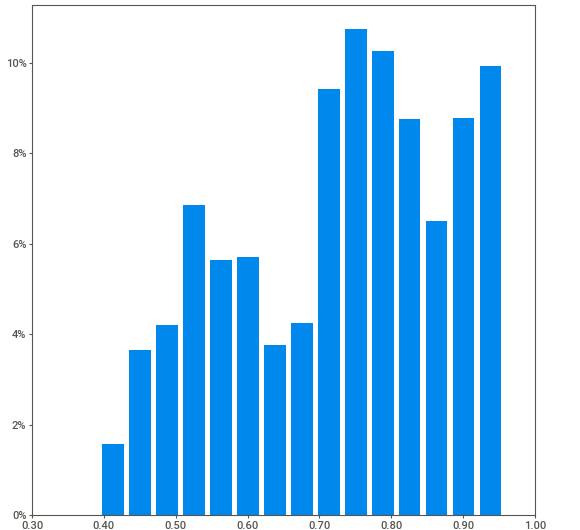
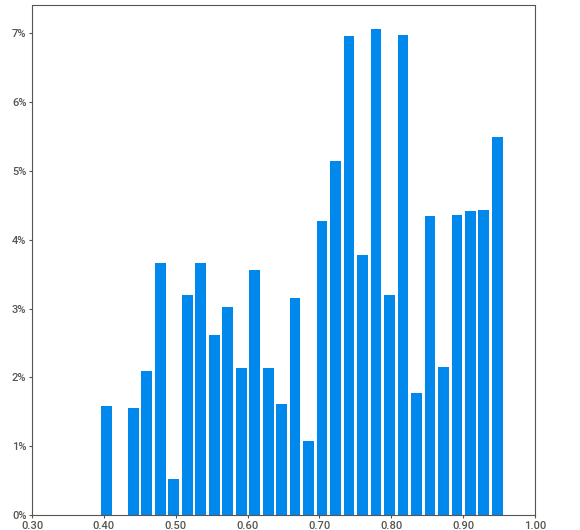
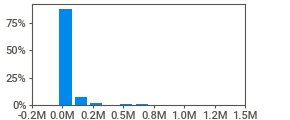
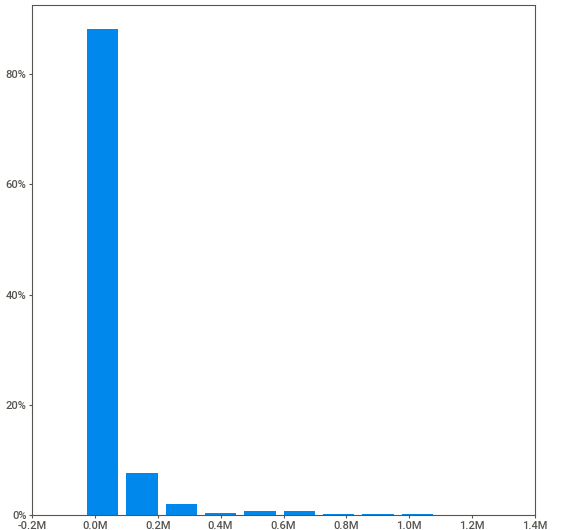
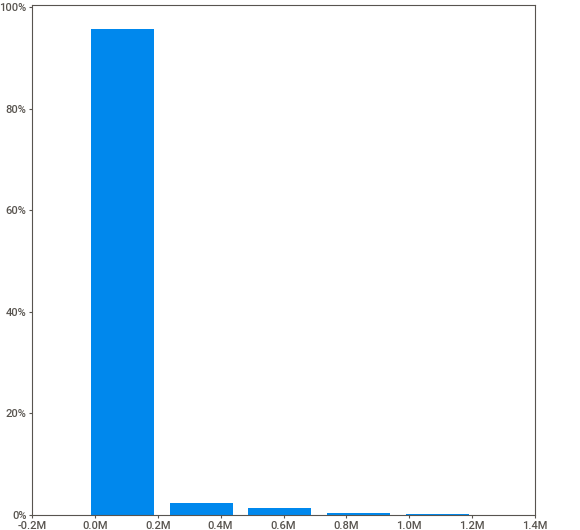
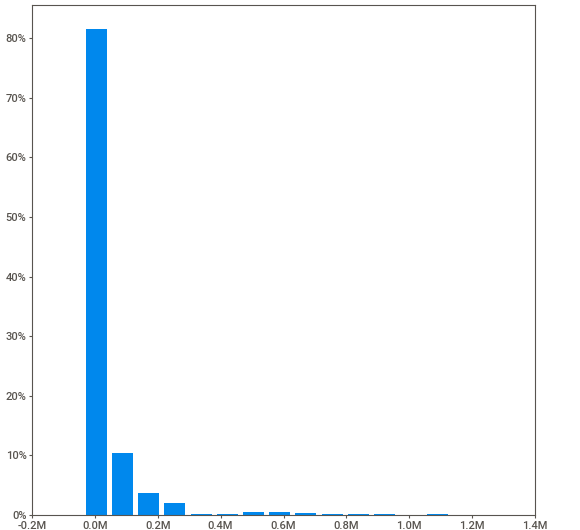
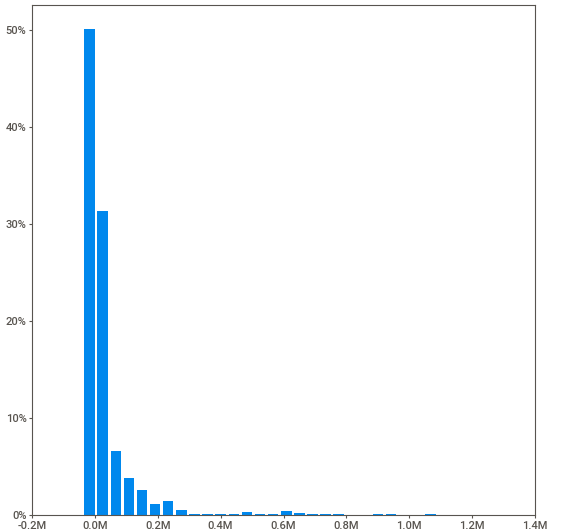
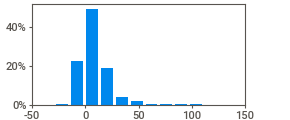
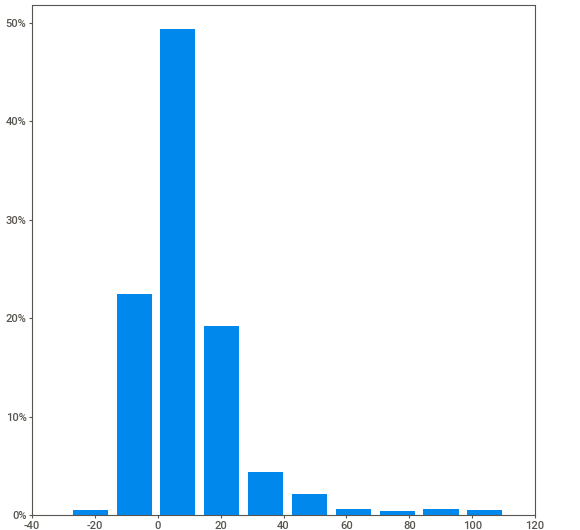
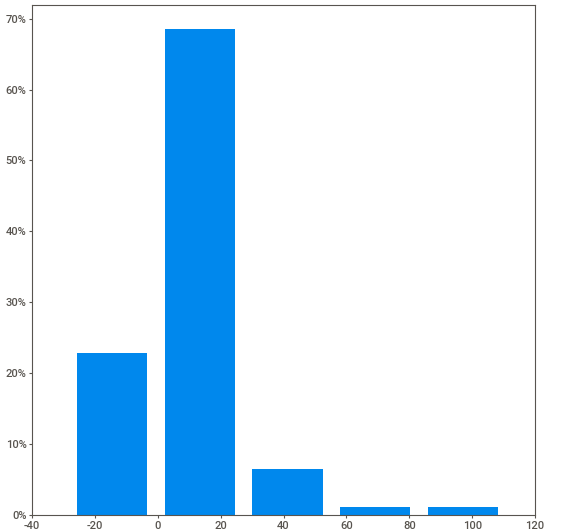
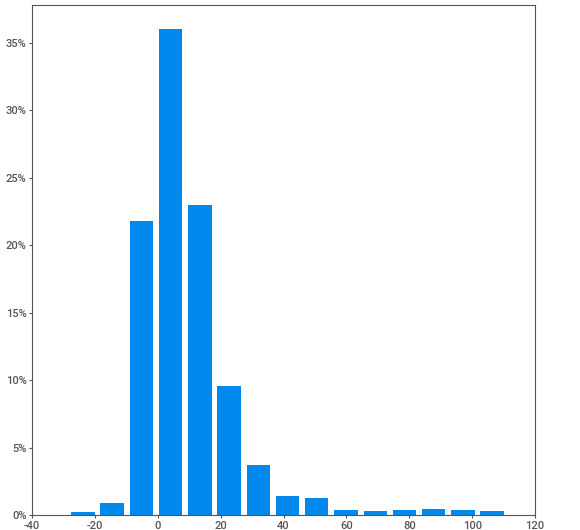
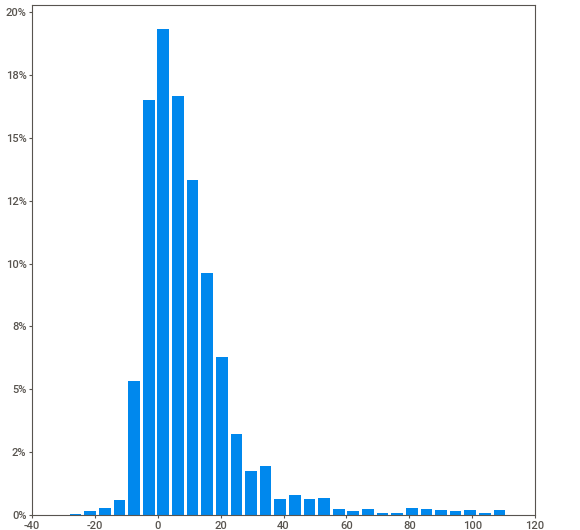
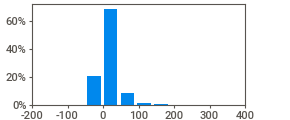
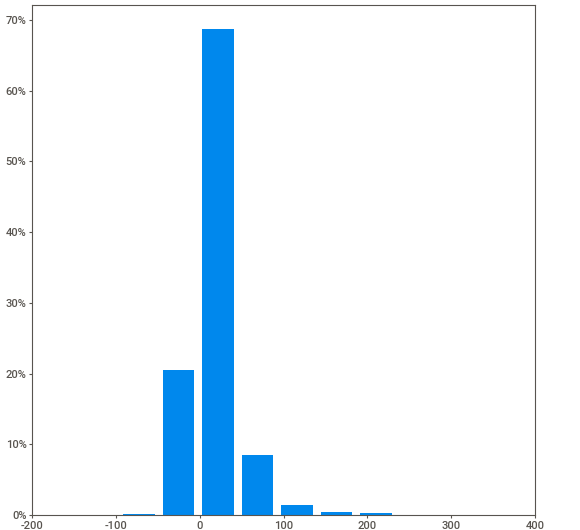
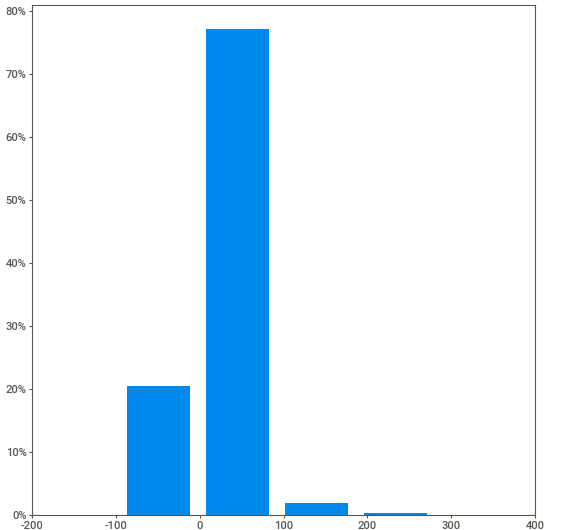
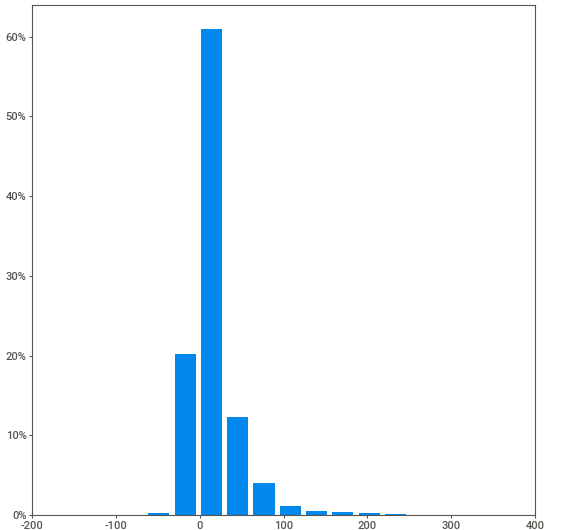
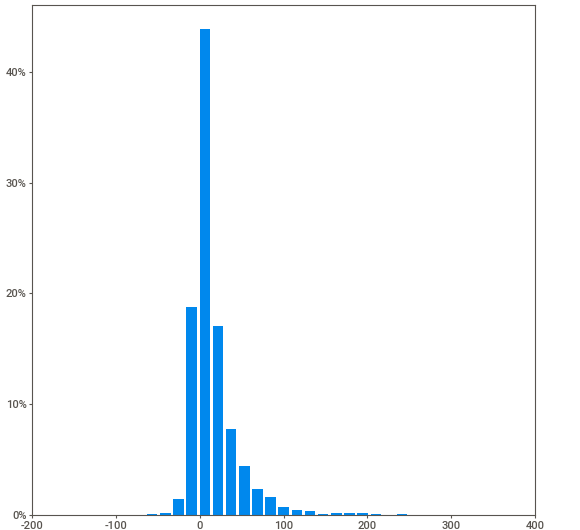
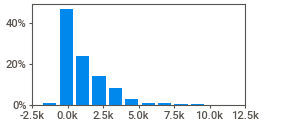
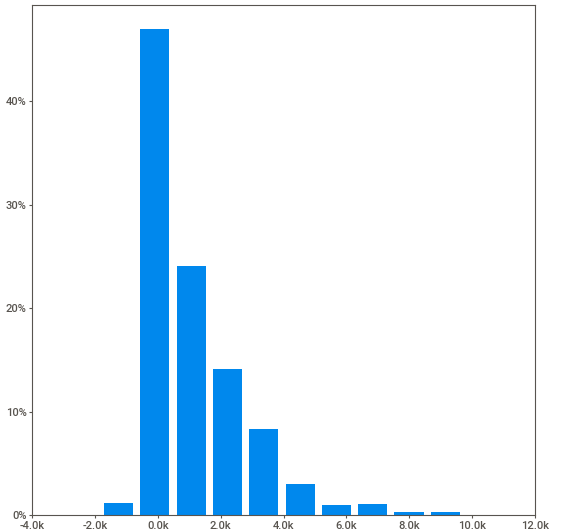
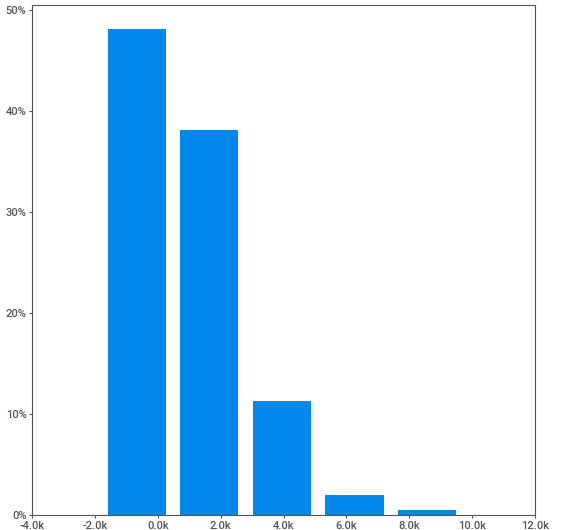
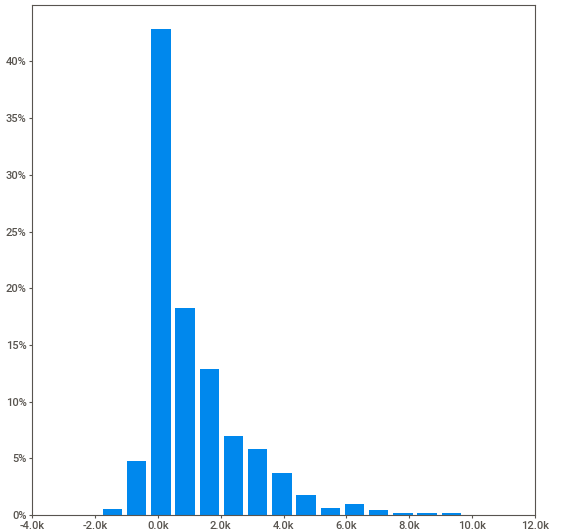
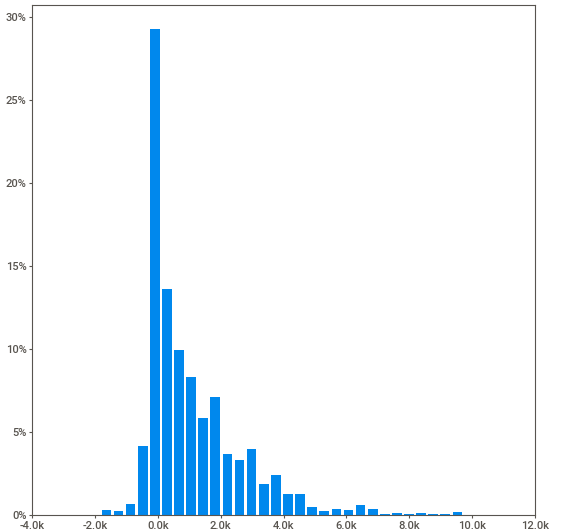
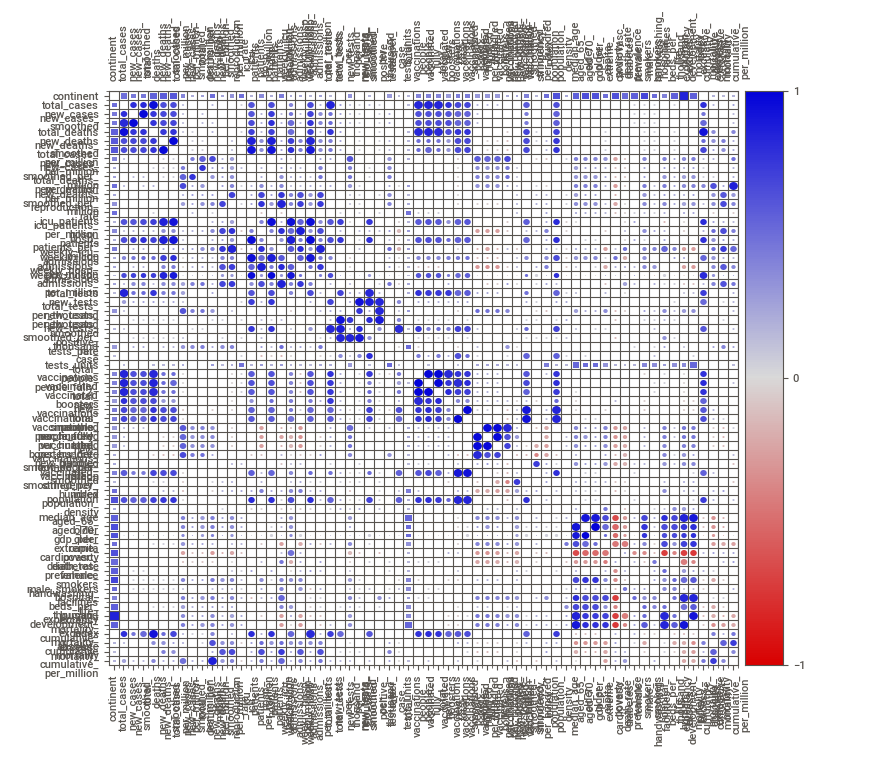
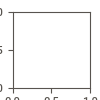

In [6]:
my_report.show_notebook()

Notamos que hay bastantes casillas con valores nulos cuyo origen es la manera en la que se construyo el dataset, sin embargo no tenemos que llenarlos, basta con hacer uso inteligente de la data para no cometer errores en nuestros tratamientos.

In [7]:
datos.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

In [8]:
datos['log_total_cases'] = np.log(datos['total_cases'])
datos['date'] = pd.to_datetime(datos['date'])

world = datos[datos['iso_code'] == 'OWID_WRL']
western_countries = ['Europe', 'North America', 'South America']
datos = datos[datos['continent'].isin(western_countries)]
datos

iso_code      continent   location       date  total_cases  new_cases  \
1625        ALB         Europe    Albania 2020-02-25          NaN        NaN   
1626        ALB         Europe    Albania 2020-02-26          NaN        NaN   
1627        ALB         Europe    Albania 2020-02-27          NaN        NaN   
1628        ALB         Europe    Albania 2020-02-28          NaN        NaN   
1629        ALB         Europe    Albania 2020-02-29          NaN        NaN   
...         ...            ...        ...        ...          ...        ...   
180626      VEN  South America  Venezuela 2022-05-06     522625.0       38.0   
180627      VEN  South America  Venezuela 2022-05-07     522672.0       47.0   
180628      VEN  South America  Venezuela 2022-05-08     522749.0       77.0   
180629      VEN  South America  Venezuela 2022-05-09     522749.0        0.0   
180630      VEN  South America  Venezuela 2022-05-10     522749.0        0.0   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
1625                   NaN           NaN         NaN                  NaN   
1626                   NaN           NaN         NaN                  NaN   
1627                   NaN           NaN         NaN                  NaN   
1628                   NaN           NaN         NaN                  NaN   
1629                   NaN           NaN         NaN                  NaN   
...                    ...           ...         ...                  ...   
180626              45.714        5709.0         0.0                0.143   
180627              49.571        5709.0         0.0                0.000   
180628              45.000        5709.0         0.0                0.000   
180629              45.000        5709.0         0.0                0.000   
180630              33.571        5709.0         0.0                0.000   

        ...  male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
1625    ...          51.2                     NaN                        2.89   
1626    ...          51.2                     NaN                        2.89   
1627    ...          51.2                     NaN                        2.89   
1628    ...          51.2                     NaN                        2.89   
1629    ...          51.2                     NaN                        2.89   
...     ...           ...                     ...                         ...   
180626  ...           NaN                     NaN                        0.80   
180627  ...           NaN                     NaN                        0.80   
180628  ...           NaN                     NaN                        0.80   
180629  ...           NaN                     NaN                        0.80   
180630  ...           NaN                     NaN                        0.80   

        life_expectancy  human_development_index  \
1625              78.57                    0.795   
1626              78.57                    0.795   
1627              78.57                    0.795   
1628              78.57                    0.795   
1629              78.57                    0.795   
...                 ...                      ...   
180626            72.06                    0.711   
180627            72.06                    0.711   
180628            72.06                    0.711   
180629            72.06                    0.711   
180630            72.06                    0.711   

        excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
1625                                     NaN                          NaN   
1626                                     NaN                          NaN   
1627                                     NaN                          NaN   
1628                                     NaN                          NaN   
1629                                  -190.8                        -4.34   
...                                      ...                 

## Explorando la curva de contagios para un Pais en particular

<AxesSubplot:xlabel='date'>

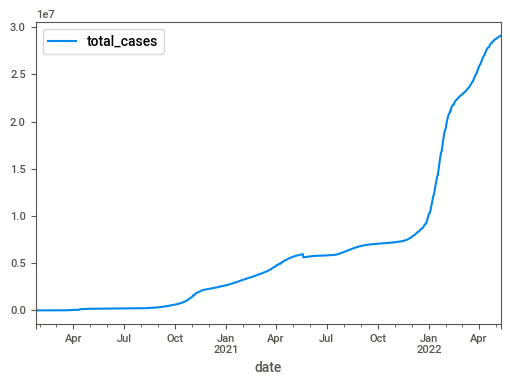

In [9]:
france = datos[datos['iso_code'] == 'FRA']
france.plot(x= 'date', y = 'total_cases')

La figura no parece precisamente exponencial, vemos como hay disparos en los contagios por temporadas.

<AxesSubplot:xlabel='date'>

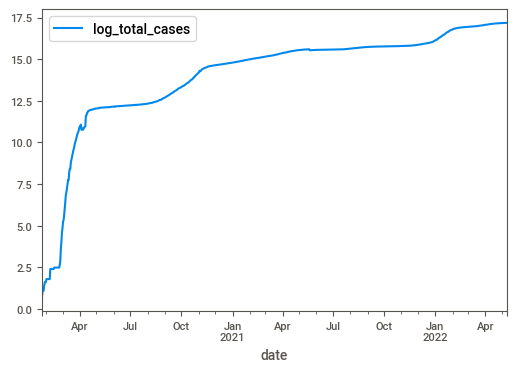

In [10]:
france.plot(x='date', y='log_total_cases')

Cuando observamos la evolucion logaritmica no apreciamos una evolucion que precisamente siga una linea recta, todo lo contrario, tenemos temporadas de crecimiento disparado y otras con valles.

<AxesSubplot:xlabel='date'>

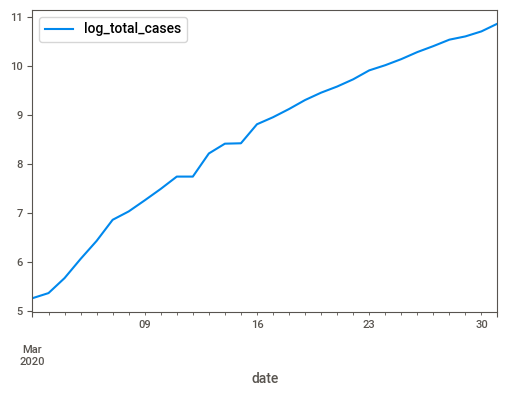

In [11]:
france[(france.date < datetime(2020, 4, 1)) & (france.date > datetime(2020, 3, 1))].plot(x='date', y='log_total_cases')

Acotando el periodo de tiempo estudiado podemos observar un comportamiento linear, sin embargo esta pendiente cambia bastante dependiendo del periodo que escojamos, ya que hay varios tramos en los que se podria observar una evolucion lineal (de los casos logaritmicos claro esta).

Que tienen en comun Francia, Canada y el Reino Unido?. Registraron su caso cero alrededor de la misma fecha, ademas de contar con condiciones economicas, politicas y culturales similares.

<AxesSubplot:xlabel='date'>

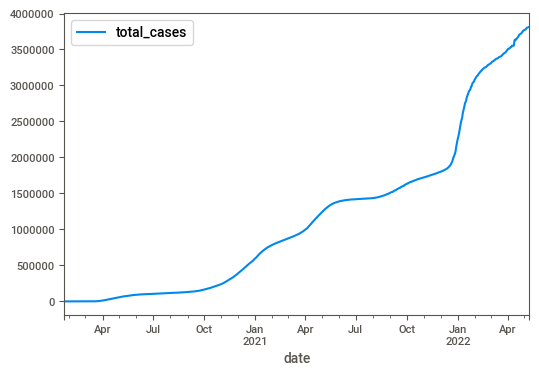

In [12]:
canada = datos[datos['iso_code'] == 'CAN']
canada.plot(x= 'date', y = 'total_cases')

<AxesSubplot:xlabel='date'>

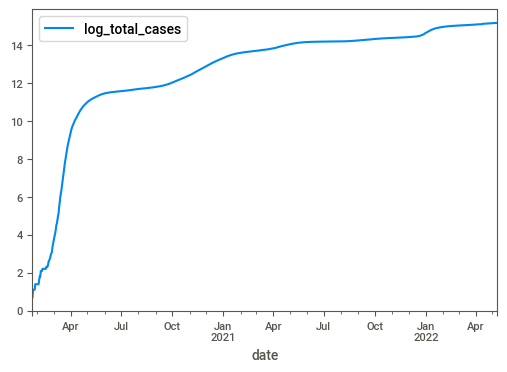

In [13]:
canada.plot(x='date', y='log_total_cases')

<AxesSubplot:xlabel='date'>

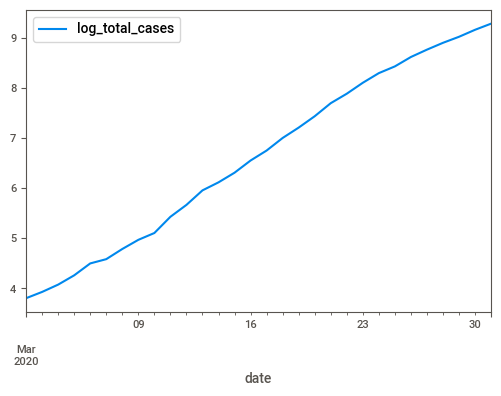

In [14]:
canada[((canada.date) < datetime(2020, 4, 1)) & ((canada.date) > datetime(2020, 3, 1))].plot(x='date', y='log_total_cases')

<AxesSubplot:xlabel='date'>

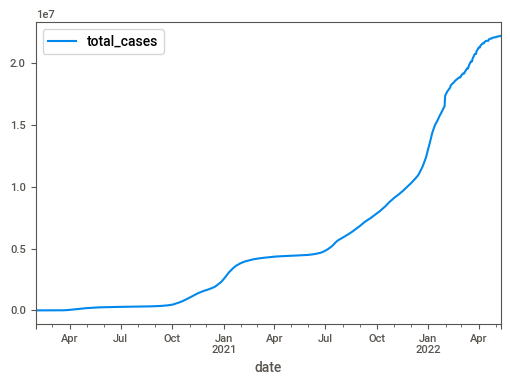

In [15]:
united_kingdom = datos[datos['iso_code'] == 'GBR']
united_kingdom.plot(x= 'date', y = 'total_cases')

<AxesSubplot:xlabel='date'>

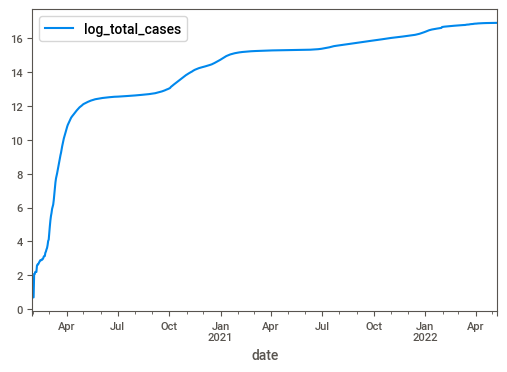

In [16]:
united_kingdom.plot(x='date', y='log_total_cases')

<AxesSubplot:xlabel='date'>

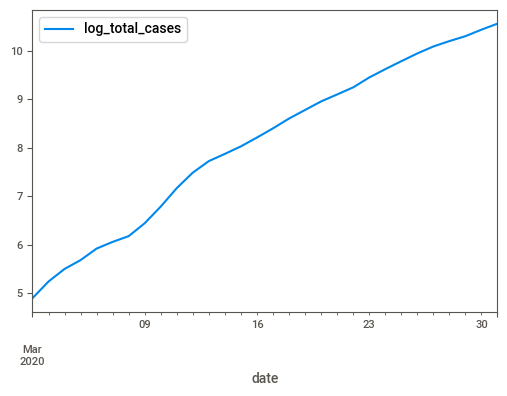

In [17]:
united_kingdom[((united_kingdom.date) < datetime(2020, 4, 1)) & ((united_kingdom.date) > datetime(2020, 3, 1))].plot(x='date', y='log_total_cases')

Se observa la misma tendencia alrededor de las mismas fechas. Al inicio, durante la primera semana del caso cero, la curva parece no crecer con lo esperado, pero despues de esta semana y durante un mes, se observa un crecimiento exponencial que se sostiene.

Se crea una funcion para obtener el dia cero de un pais dado.

In [18]:
def get_day_zero(country_df):
    day_zero = min(country_df[country_df.total_cases > 0].date)
    return day_zero

Vamos a mirar como evolucionan los contagios en Colombia, y a checar si tambien siguen con el mismo patron, una semana de rezago, seguido de 3 semanas de crecimiento exponencial (en algunos paises este crecimiento a veces se alarga mas alla del mes).

<AxesSubplot:xlabel='date'>

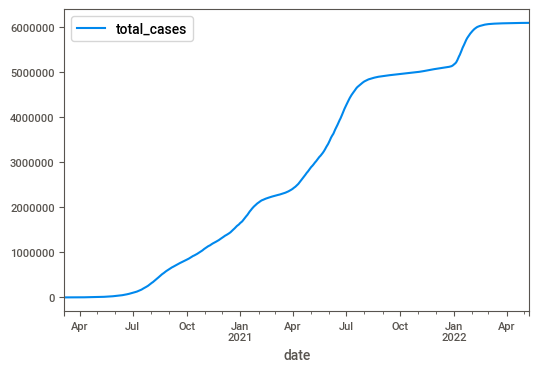

In [19]:
colombia = datos[datos['iso_code'] == 'COL']
colombia.plot(x= 'date', y = 'total_cases')

En Colombia no se observa un crecimiento exponencial tan claramente

<AxesSubplot:xlabel='date'>

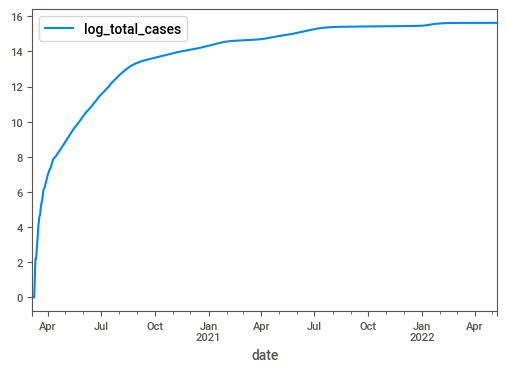

In [20]:
colombia.plot(x='date', y='log_total_cases')

In [21]:
day_zero = get_day_zero(colombia)
one_week_after = day_zero + pd.Timedelta('7 days')
end_of_lineal_growth = one_week_after + pd.Timedelta('24 days')

<AxesSubplot:xlabel='date'>

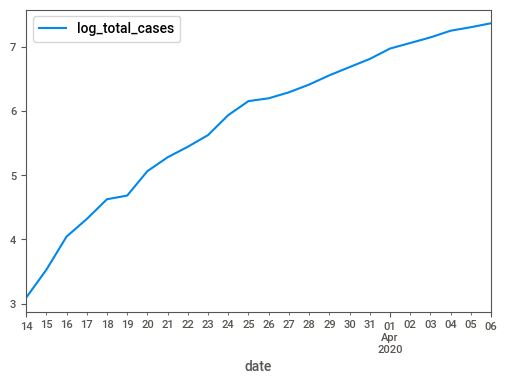

In [22]:
colombia[(colombia.date <= end_of_lineal_growth) & (colombia.date > one_week_after)].plot(x='date', y='log_total_cases')

Si bien la grafica no es totalmente lineal, no parece una aproximacion descabellada, ademas que conociendo esto podemos generalizar nuestro proceso para todos los paises en el dataset!!.

Creamos una funcion para generar el intervalo de crecimiento exponencial a partir del dia de paciente cero en cada pais. Tambien creamos la funcion exponencial que vamos a ajustar.

In [23]:
def get_exponential_interval(country_df):
    day_zero = get_day_zero(country_df)
    one_week_after = day_zero + pd.Timedelta('7 days')
    one_month_after = one_week_after + pd.Timedelta('24 days')
    return one_week_after , one_month_after

In [24]:
def exponencial(t,k,t0):
  C = np.exp(k*(t-t0))
  return C

Creamos una funcion que automatice todo el proceso, a partir del dataset original con señalar unicamente el codigo ISO calculamos el parametro K para cada pais durante el periodo de crecimiento exponencial.
Agregamos tambien un r2_score con el fin de calificar que tan bien se ajusta nuestra funcion a los datos reales de cada pais.

In [25]:
def pandemic_modeler(origin_df, country_code):
    country_df = origin_df[origin_df.iso_code == country_code].copy()
    start_date, end_date = get_exponential_interval(country_df)
    exponential_country_df = country_df[(country_df.date <= end_date) & (country_df.date > start_date)].copy()
    days = pd.Series(np.arange(7, len(exponential_country_df)+7 ))
    popt, pcov = curve_fit(exponencial, days, exponential_country_df.total_cases)
    predicted_cases = exponencial(days, popt[0], popt[1])
    score = r2_score(exponential_country_df.total_cases, predicted_cases)
    return popt[0] , score
    

In [26]:
pandemic_modeler(datos, 'USA')

(0.02637656765304427, 0.8231541601618368)

In [27]:
pandemic_modeler(datos, 'BRA')

(0.19306979219001955, 0.9803912676778637)

In [28]:
pandemic_modeler(datos, 'ITA')

(0.3093627488005535, 0.9931596086730209)

La funcion parece funcionar perfectamente para los paises.

In [29]:
k_values = pd.DataFrame(columns=['Country', 'K', 'Rsquared'])

Creamos nuestro dataset usando la funcion, tambien usamos un error_handler para que ignore aquellos paises que no podemos modelar.

In [30]:
country_list = datos.iso_code.unique()
for i, country in enumerate(country_list):
    try:
        k, r2 = pandemic_modeler(datos, country)
    except:
        print(country + ' experienced error')
    k_values.loc[i] = [country, k, round(r2,2)]

AIA experienced error
GGY experienced error
JEY experienced error
PRI experienced error


/home/juancparra/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


SXM experienced error
VIR experienced error


Nuestro dataframe con valores de K fue creado satisfactoriamente!

In [31]:
k_values = k_values[~k_values['Country'].str.contains('OWID')]
k_values = k_values[k_values['Rsquared'] >= 0.8]
k_values

Country         K  Rsquared
0       ALB  0.076867      0.97
1       AND  0.131188      0.95
2       AIA  0.131188      0.95
3       ATG  0.082723      0.91
4       ARG  0.137870      0.97
..      ...       ...       ...
96      USA  0.026377      0.82
97      VIR  0.026377      0.82
98      URY  0.043782      0.91
99      VAT  0.083052      0.84
100     VEN  0.033663      0.91

[86 rows x 3 columns]

Eliminamos aquellos valores que no tiene un R2 por encima de 0.8.

<AxesSubplot:ylabel='K'>

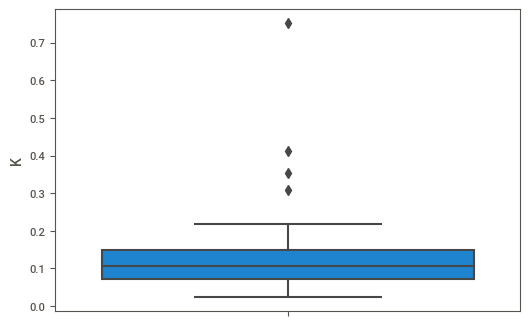

In [32]:
import seaborn
seaborn.boxplot(data = k_values, y = 'K')

Observamos la distribucion de nuestros valores K, vemos que hay cierto nivel de varianza entre paises.
Es muy complicado generalizar, ya que parece que el valor K depende de muchos factores, incluido medidas gubernamentales, vacunacion, densidad poblacional y factores culturales.

In [33]:
from scipy import stats
dof = len(k_values) - 1
mean = k_values['K'].mean()
std = k_values['K'].std
sem = stats.sem(k_values['K'])
confidence = 0.95

In [34]:
stats.t.interval(alpha = 1 - confidence, df = dof, loc = mean, scale = sem)

(0.12240977172059297, 0.12370354072599105)

Calculamos nuestro intervalo de confianza y obtenemos que K deberia estar alrededor de los 0.12.

## Datos del mundo
Ahora comparamos con los datos alrededor del mundo

<AxesSubplot:xlabel='date'>

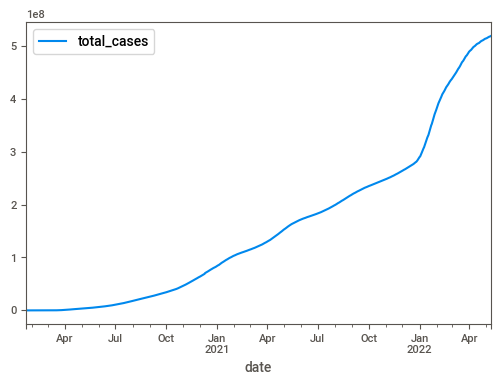

In [35]:
world.plot(x= 'date', y = 'total_cases')

<AxesSubplot:xlabel='date'>

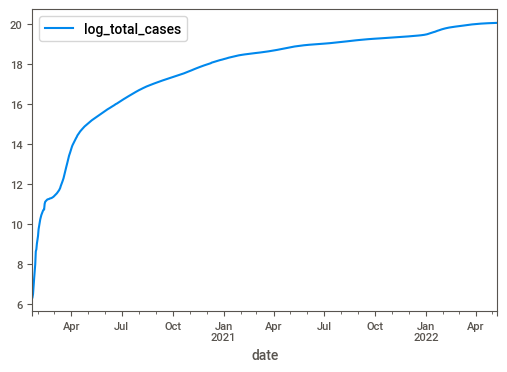

In [36]:
world.plot(x = 'date', y = 'log_total_cases')

<AxesSubplot:xlabel='date'>

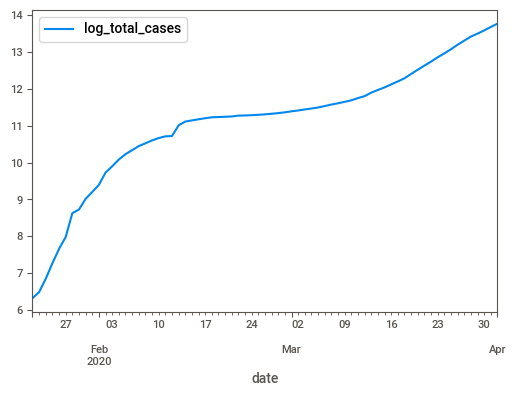

In [37]:
world[(world.date <= datetime(2020, 4, 1)) & (world.date > datetime(2019, 11 ,1))].plot(x='date', y='log_total_cases')

Observamos que pareciera qeu hubieran dos lineas rectas, es decir mas de un crecimiento exponencial, pero claramente con un diferente K. Por eso es que el metodo con el que estamos obteniendo el K no es del todo objetivo, depende bastante del periodo que vamos a evaluar, como vamos a ver a continuacion

<AxesSubplot:xlabel='date'>

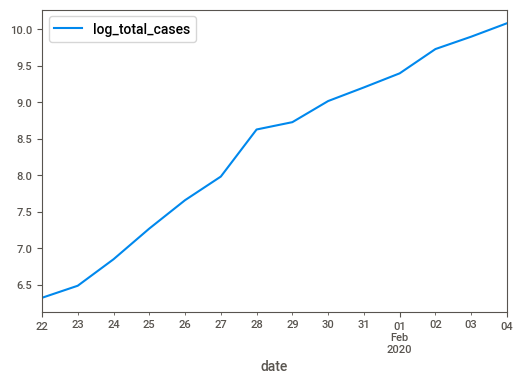

In [38]:
world[(world.date <= datetime(2020, 2, 4)) & (world.date > datetime(2020, 1 ,1))].plot(x='date', y='log_total_cases')

Observamos el primer intervalo de crecimiento exponencial, procedemos a calcular el K

In [39]:

exponential_world_df = world[(world.date <= datetime(2020,2,4)) & (world.date > datetime(2020,1,1))].copy()
days = pd.Series(np.arange(1, len(exponential_world_df)+1 ))
popt, pcov = curve_fit(exponencial, days, exponential_world_df.total_cases)
predicted_cases = exponencial(days, popt[0], popt[1])
score = r2_score(exponential_world_df.total_cases, predicted_cases)
    

In [40]:
popt[0] , score

(0.23696561267529107, 0.9897017929707872)

Obtenemos un valor de 0.23, cabe recalcar que nuestro intervalo de confianza surgio a partir de promedios, no ponderados, esto tiene mucho que ver con los resultados obtenidos

<AxesSubplot:xlabel='date'>

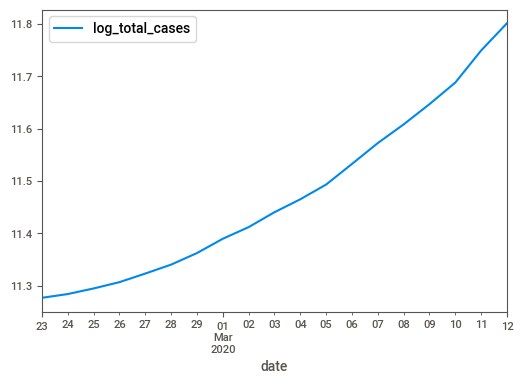

In [41]:
world[(world.date <= datetime(2020, 3, 12)) & (world.date > datetime(2020, 2 ,22))].plot(x='date', y='log_total_cases')

In [42]:
exponential_world_df = world[(world.date <= datetime(2020,3,12)) & (world.date > datetime(2020,2,22))].copy()
days = pd.Series(np.arange(1, len(exponential_world_df)+1 ))
popt, pcov = curve_fit(exponencial, days, exponential_world_df.total_cases)
predicted_cases = exponencial(days, popt[0], popt[1])
score = r2_score(exponential_world_df.total_cases, predicted_cases)

In [43]:
popt[0] , score

(0.030454460296094988, 0.9593121365442393)

Para otro periodo en donde tambien se observa un comportamiento exponencial notamos que K es diez veces menor!!, hace falta una metodologia mas robusta para su calculo

## Estrategia "Adopcion de vacunacion temprana"
Vamos a evaluar la metodologia de adoptar vacunacion temprana, se basa en medir el numero de vacunados por cada 100 habitantes y dividirlo en dos categorias basadas en percentiles. Los que estan por encima del percentil 50 son clasificados como early_vaxinators. Y creemos que los factores relacionados con esta medida son: El numero de muertes por cada millon de habitantes, el numero de casos por cada millon de habitantes, y el gdp del pais.

Creamos nuestras funciones para poder generar nuestro dataset base.

In [44]:
def year_after_vaxs(origin_df, country_code):
    country_df = origin_df[origin_df.iso_code == country_code].copy()
    day_zero = get_day_zero(country_df)
    year_after = day_zero + timedelta(days = 365)
    return country_df[country_df['date'] <= year_after]['total_vaccinations_per_hundred'].max()

def get_deaths(origin_df, country_code):
    country_df = origin_df[origin_df.iso_code == country_code].copy()
    return country_df['total_deaths_per_million'].max()

def get_cases(origin_df, country_code):
    country_df = origin_df[origin_df.iso_code == country_code].copy()
    return country_df['total_cases_per_million'].max()

def get_gdp(origin_df, country_code):
    country_df = origin_df[origin_df.iso_code == country_code].copy()
    return country_df['gdp_per_capita'].max()


Creamos nuestro dataset por paises con nuestras variables predictoras, haciendo uso de un ciclo con un error handler

In [45]:
prediction_df = pd.DataFrame(columns = ['country','vax_first_year', 'deaths', 'cases', 'gdp'])
for i, country in enumerate(country_list):
    try:
        vax_first_year = year_after_vaxs(datos, country)
        deaths = get_deaths(datos, country)
        cases = get_cases(datos, country)
        gdp = get_gdp(datos, country)
        prediction_df.loc[i] = [country, vax_first_year, deaths, cases, gdp]
    except:
        print(country + ' experienced error')
    

GGY experienced error
JEY experienced error
PRI experienced error
SXM experienced error
VIR experienced error


In [46]:
prediction_df

country  vax_first_year    deaths       cases        gdp
0       ALB            0.55  1217.223   95865.760  11803.431
1       AND            3.27  2003.775  539299.842        NaN
2       AIA           35.36   595.041  197289.256        NaN
3       ATG            0.00  1387.651   77617.292  21490.943
4       ARG            3.28  2822.644  199564.845  18933.907
..      ...             ...       ...         ...        ...
95      GBR           13.88  2593.278  325854.060  39753.244
96      USA            7.39  2997.906  246488.806  54225.446
98      URY            5.84  2069.637  258967.184  20551.409
99      VAT             NaN       NaN   35714.286        NaN
100     VEN            0.04   198.886   18211.112  16745.022

[96 rows x 5 columns]

In [47]:
prediction_df.dropna(inplace=True)
prediction_df

country  vax_first_year    deaths       cases        gdp
0       ALB            0.55  1217.223   95865.760  11803.431
3       ATG            0.00  1387.651   77617.292  21490.943
4       ARG            3.28  2822.644  199564.845  18933.907
6       AUT            6.46  2020.442  463304.948  45436.686
7       BHS            0.03  2010.511   85104.078  27717.847
..      ...             ...       ...         ...        ...
94      UKR            0.02  2587.238  115962.423   7894.393
95      GBR           13.88  2593.278  325854.060  39753.244
96      USA            7.39  2997.906  246488.806  54225.446
98      URY            5.84  2069.637  258967.184  20551.409
100     VEN            0.04   198.886   18211.112  16745.022

[75 rows x 5 columns]

<AxesSubplot:ylabel='vax_first_year'>

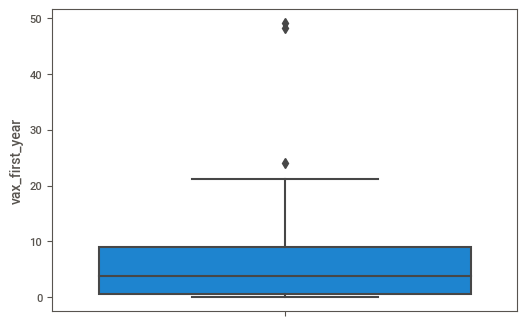

In [48]:
import seaborn
seaborn.boxplot(data = prediction_df, y = 'vax_first_year')

In [49]:
prediction_df['early_vax_response'] = pd.qcut(prediction_df['vax_first_year'], 2, labels = False)
prediction_df

country  vax_first_year    deaths       cases        gdp  \
0       ALB            0.55  1217.223   95865.760  11803.431   
3       ATG            0.00  1387.651   77617.292  21490.943   
4       ARG            3.28  2822.644  199564.845  18933.907   
6       AUT            6.46  2020.442  463304.948  45436.686   
7       BHS            0.03  2010.511   85104.078  27717.847   
..      ...             ...       ...         ...        ...   
94      UKR            0.02  2587.238  115962.423   7894.393   
95      GBR           13.88  2593.278  325854.060  39753.244   
96      USA            7.39  2997.906  246488.806  54225.446   
98      URY            5.84  2069.637  258967.184  20551.409   
100     VEN            0.04   198.886   18211.112  16745.022   

     early_vax_response  
0                     0  
3                     0  
4                     0  
6                     1  
7                     0  
..                  ...  
94                    0  
95                    1  
96                    1  
98                    1  
100                   0  

[75 rows x 6 columns]

Convertimos nuestra variable en una variable discreta haciendo uso de los percentiles.

In [50]:
prediction_df = prediction_df.reset_index(drop = True).drop(columns = ['vax_first_year'])
prediction_df

country    deaths       cases        gdp  early_vax_response
0      ALB  1217.223   95865.760  11803.431                   0
1      ATG  1387.651   77617.292  21490.943                   0
2      ARG  2822.644  199564.845  18933.907                   0
3      AUT  2020.442  463304.948  45436.686                   1
4      BHS  2010.511   85104.078  27717.847                   0
..     ...       ...         ...        ...                 ...
70     UKR  2587.238  115962.423   7894.393                   0
71     GBR  2593.278  325854.060  39753.244                   1
72     USA  2997.906  246488.806  54225.446                   1
73     URY  2069.637  258967.184  20551.409                   1
74     VEN   198.886   18211.112  16745.022                   0

[75 rows x 5 columns]

In [51]:
from sklearn.model_selection import train_test_split
y = prediction_df['early_vax_response'].copy()
X = prediction_df.drop(columns = ['early_vax_response', 'country'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

Creamos nuestros modelos logisticos individuales, y procedemos a ajustarlos usando un diccionario, asi nos ahorramos mucho trabajo.

In [53]:
lr_deaths = LogisticRegression()
lr_cases = LogisticRegression()
lr_gdp = LogisticRegression()

logistic_regressions = {lr_deaths: 'deaths', lr_cases: 'cases', lr_gdp: 'gdp'}

In [54]:
logistic_regressions.items()

dict_items([(LogisticRegression(), 'deaths'), (LogisticRegression(), 'cases'), (LogisticRegression(), 'gdp')])

In [55]:
accuracy_results = []
f1_scores = []
for logistic_regression, column in logistic_regressions.items():
    logistic_regression.fit( X_train[column].to_frame(), y_train)
    y_pred = logistic_regression.predict(X_test[column].to_frame())
    accuracy_results.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    

In [56]:
accuracy_results

[0.26666666666666666, 0.3333333333333333, 0.6666666666666666]

In [57]:
f1_scores

[0.35294117647058826, 0.5, 0.6153846153846154]

Obtuvimos unos resultados bastante mediocres, la mejor variable predictora es el GDP y tiene bastante sentido, los paises mas ricos son capaces de adquirir vacunas mas rapidamente, lo sorprendente es que no se ve la correlacion fuerte ni con las muertes ni con los casos de covid, tal vez porque hay otras variables en juego, como la densidad poblacional, la edad media de la poblacion, y medidas estatales adicionales adoptadas.

Probamos con todas las variables a la vez, sin embargo obtenemos los mismos resultados que con nuestro mejor predictor, el GDP.

In [58]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_all_attributes = accuracy_score(y_test, y_pred)
f1_score_all_attributes = f1_score(y_test, y_pred)

In [59]:
accuracy_all_attributes, f1_score_all_attributes

(0.6666666666666666, 0.6153846153846154)

## Pregunta -- Que factores principalmente afectan los muertos por millon de habitantes

In [60]:
deaths = datos[['new_deaths_smoothed_per_million', 'stringency_index', 'total_tests_per_thousand', 'total_vaccinations_per_hundred','population_density',
 'median_age', 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']].copy()

<AxesSubplot:>

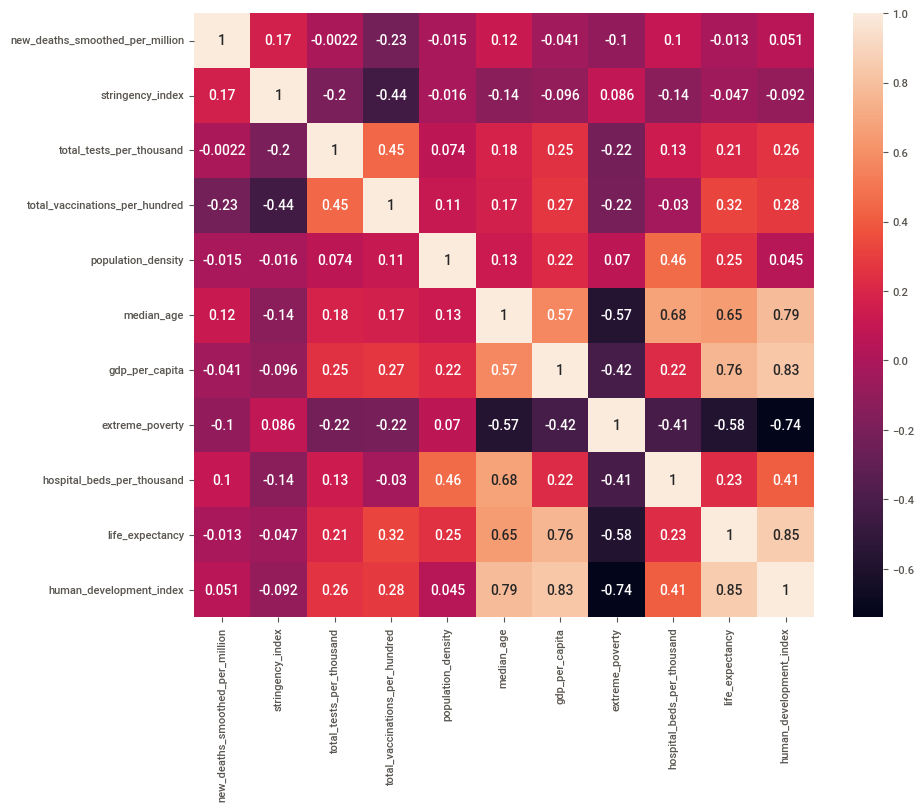

In [61]:
plt.figure(figsize = (10,8))
seaborn.heatmap(deaths.corr(), annot = True)

No vemos muchas correlaciones fuertes entre el numero de muertes, pero lo que si podemos recalcar, es que:
1. El factor con la mayor correlacion negativa con el numero de muertes es el de el numero total de vacunas aplicadas
2. EL factor con la mayor correlacion positiva con el numero de muertes es el de el indice de estringencia
3. La edad media de una poblacion tambien parece estar relacionada con el numero de muertes con correlacion positiva
4. Increiblemente la pobreza extrema tiene una correlacion negativa, hay que tomar este dato con cuidado porque puede suceder que los paises mas pobres no tengan acceso a unas cifras de muertos por COVID exactas
5. La densidad poblacional no parece guardar correlacion con el numero de muertos

# Informe COVID en el mundo

## El Valor K

El parametro K es un factor de transmisibilidad del virus, a mayores valores de K podemos decir que es mas facil contraer el virus. Los gobiernos de todo el mundo se esfuerzan por disminuir este factor en sus estados, con el fin de no colapsar el sistema de salud y que a su vez lo infectados terminen como victimas mortales del Coronavirus.

En este proyecto analizar y calcular el valor K para cada pais, se construyo una metodologia, que si bien no es la mas robusta brinda resultados satisfactorios y generalizables que aumentan la precision del calculo de K debido a que aumentamos el tamaño de la muestra y no requiere de output humano.

Podemos notar que el valor K se dispara durante los meses siguientes al caso cero, luego de esto los gobiernos son capaces de responder con ciertas medidas que pueden ser o no eficientes, o en efecto la disminucion de los contagios se da por cierto nivel de inmunizacion.

Algunos paises comparten comportamientos similares en sus curvas de contagio, tienen ciertas variaciones principalmente causadas por sus contextos locales.

Despues de calcular el valor K para cada pais, se promedio con el fin de hallar un estimado global, aplicando un intervalo de confianza del 95%, tambien cabe señalar las limitaciones de esta metodologia, y es, que no todos los estados son iguales, algunos tienen mas peso sobre las dinamicas globales que otro, en nuestro caso, le damos el mismo peso a cada estado.

K ->0.12

![Asimptomatic covid](sized_slide_silentspread.jpg)

Es una tarea muy complicada medir a ciencia cierta el numero de infectados en un pais, por diversos factores culturales tanto como economicos y diferencias, asi qeu hacer comparativas se dificulta bastante, por ejemplo; los paises mas pobres pueden tener menores reportes de casos de COVID 19 por que hay un menor numero de tests disponibles, o es mas dificil diagnosticar la enfermedad, o los propios estados pueden no estar preparados para la elaboracion de cifras oficiales. Es por eso que es tan dificil conseguir un modelo que sea capaz de predecir con exactitud el rumbo de la pandemia.

## Adopcion temprana de la vacunacion

La vacunacion ha sido la medida principal tomada como metodo de mitigacion de impacto y de reduccion de la trasmision del COVID 19 por la mayoria de los estados. Observando algunos indicadores podriamos asegurar que un pais tomo o no un esfuerzo proactivo por vacunar a su poblacion temprano?

Precisamente se intento, no con mucho exito, o no por lo menos con los factores de impacto del virus. Para nadie es un secreto que aquellos paises mas ricos fueron los que tuvieron acceso a las vacunas de una manera mas rapida y ademas en mayores numeros, este fue el mejor factor predictor. Y si bien el numero de muertes por covid se disminuye conforme aumenta la porporcion de personas vacunadas en un pais como veremos mas adelante no fue un predictor tan fuerte para predecir si un pais habia adoptado la vacunacion temprana.

## Morbilidad y COVID

1. El factor con la mayor correlacion negativa con el numero de muertes es el de el numero total de vacunas aplicadas
2. EL factor con la mayor correlacion positiva con el numero de muertes es el de el indice de estringencia
3. La edad media de una poblacion tambien parece estar relacionada con el numero de muertes con correlacion positiva
4. Increiblemente la pobreza extrema tiene una correlacion negativa, hay que tomar este dato con cuidado porque puede suceder que los paises mas pobres no tengan acceso a unas cifras de muertos por COVID exactas
5. La densidad poblacional no parece guardar correlacion con el numero de muertos

La vacunacion parecer ser la mejor medida para frenar los impactos del COVID 19, especialmente para paises con unas poblacion con edades avanzadas.